# Import Functions

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

%matplotlib inline

# Step 1: Calibrate Camera

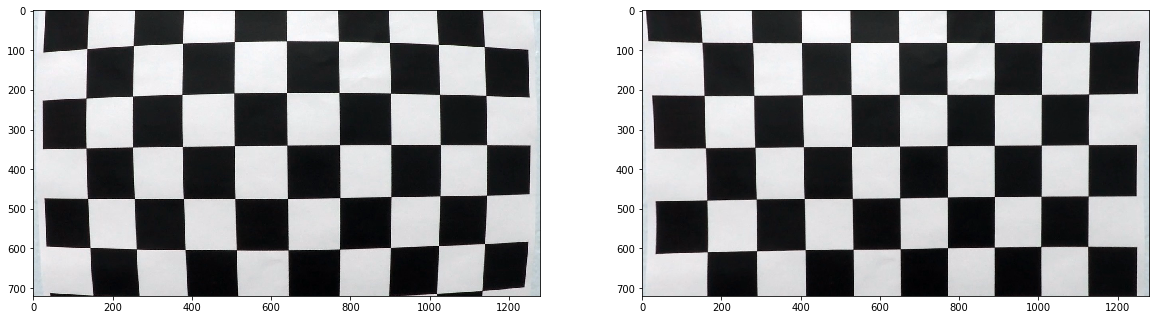

In [2]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (nx,ny), corners2,ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

example = 'camera_cal/calibration1.jpg'
img = cv2.imread(example)
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 0, (w,h))
undistorted = cv2.undistort(img, mtx, dist, None, newcameramtx)
fig = plt.figure(figsize = (20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(img)
fig.add_subplot(1, 2, 2)
plt.imshow(undistorted)

# Step 2: Pipeline Helper Functions

In [201]:

def undistort(img):
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 0, (w,h))
    return cv2.undistort(img, mtx, dist, None, newcameramtx)

def sobelx(img, ksize = 5, thresh = 20):
    sobelx = cv2.Sobel(img,cv2.CV_64F, 1, 0, ksize = ksize)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    ret, thresh = cv2.threshold(scaled_sobelx, thresh, 255, cv2.THRESH_BINARY)
    return thresh

def thresh_white(img, thresh = 208):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)
    return thresh

def thresh_hlS(img, thresh = 128):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    lower_S = np.array([0, 0, 128])
    upper_S = np.array([72 ,255, 255])
    return cv2.inRange(hls, lower_S, upper_S)

def thresh_yellow(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([15,80,80])
    upper_yellow = np.array([25,255,255])
    return cv2.inRange(hsv, lower_yellow, upper_yellow)

def thresh_green(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_green = np.array([20,10,10])
    upper_green = np.array([50,160,160])
    return cv2.inRange(hsv, lower_green,upper_green)

def transform(img):
    h, w = img.shape[:2]
    dx = 200
    pts1 = np.float32([[265, 685],[610, 440],[670, 440],[1050, 685]])
    pts2 = np.float32([[dx, w], [dx, 0], [h - dx, 0], [h - dx, w]])

    M = cv2.getPerspectiveTransform(pts1, pts2)

    return cv2.warpPerspective(img, M, (h, w))

def retransform(img):
    h, w = img.shape[:2]
    dx = 200
    pts1 = np.float32([[265, 685],[610, 440],[670, 440],[1050, 685]])
    pts2 = np.float32([[dx, h], [dx, 0], [w - dx, 0], [w - dx, h]])

    M = cv2.getPerspectiveTransform(pts2, pts1)

    return cv2.warpPerspective(img, M, (h, w))

def sliding_window(transformed, leftx_base, rightx_base, nwindows = 20):
    h, w = transformed.shape[:2]
    
    # Set height of windows
    window_height = np.int(h//nwindows)
    
    out_img = np.dstack((transformed, transformed, transformed))
    
    nonzero = transformed.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 40
    # Set minimum number of pixels found to recenter window
    minpix = 10
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    #do we search right and left?
    active_left = True
    active_right = True
    #momentum
    momentum_left = 0
    momentum_right = 0
    
    
    # Step through the windows one by one
    for window in range(nwindows):
        momentum_base_left = leftx_current
        momentum_base_right = rightx_current
        leftx_current += momentum_left
        rightx_current += momentum_right
        
        for _ in range(3):
        # Identify window boundaries in x and y (and right and left)
            win_y_low = int(h - (window+1)*window_height)
            win_y_high = int(h - window*window_height)
            win_xleft_low = int(leftx_current - margin)
            win_xleft_high = int(leftx_current + margin)
            win_xright_low = int(rightx_current - margin)
            win_xright_high = int(rightx_current + margin)
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        momentum_left = leftx_current - momentum_base_left
        momentum_right = rightx_current - momentum_base_right
        
        if active_left:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2)
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
        if active_right:
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2)
            right_lane_inds.append(good_right_inds)
        
        #recognize leaving the window left or right
        if leftx_current < margin // 2 and len(good_left_inds) < minpix:
            active_left = False
        if rightx_current > w - (margin // 2) and len(good_right_inds) < minpix:
            active_right = False

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit, right_fit = None, None
    if len(lefty) > 500:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(righty) > 500:
        right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fit, right_fit, out_img

def calcCurvature(ploty, fitx):
    #Step 7 Calculate curvature:
    # Define conversions in x and y from pixels space to meters
    length = np.max(ploty)
    ym_per_pix = 40/length # meters per pixel in y dimension
    xm_per_pix = 3.7/310 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*length*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

def checkSanity(ploty, left_fit, right_fit, left_fit_old = None, right_fit_old = None):
    sane = [True, True]
    if left_fit is not None: 
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        left_curve = calcCurvature(ploty, left_fitx)
    else:
        sane[0] = False
    if right_fit is not None:
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        right_curve = calcCurvature(ploty, right_fitx)
    else:
        sane[1] = False
    if left_fit is not None and right_fit is not None:
        distance = right_fitx[-1] - left_fitx[-1]
        curve_dist = abs(left_curve - right_curve)
        if distance < 270 or distance > 350:
            sane = [False, False]
        if curve_dist > 200 and (left_curve < 10000 or right_curve < 10000):
            sane = [False, False]
    else:
        distance = -1
        curve_dist = -1
    
    if sane == [True, True]:
        return sane, (distance, curve_dist, -1, -1)
    
    if left_fit_old is not None and left_fit is not None:
        left_fitx_old = left_fit_old[0]*ploty**2 + left_fit_old[1]*ploty + left_fit_old[2]
        left_curve_old = calcCurvature(ploty, left_fitx_old)
        distance_left = abs(left_curve - left_curve_old)
        if distance_left > 200 and (left_curve < 10000 or left_curve_old < 10000):
            sane[0] = False
        else:
            sane[0] = True
    else:
        distance_left = -1
    
    if right_fit_old is not None and right_fit is not None:
        right_fitx_old = right_fit_old[0]*ploty**2 + right_fit_old[1]*ploty + right_fit_old[2]
        right_curve_old = calcCurvature(ploty, right_fitx_old)
        distance_right = abs(right_curve - right_curve_old)
        if distance_right > 200 and (right_curve < 10000 or right_curve_old < 10000):
            sane[1] = False
        else:
            sane[1] = True
    else:
        distance_right = -1
        
    return sane, (distance, curve_dist, distance_left, distance_right)

def find_lanes(img, mask, left_fit_compare = None, right_fit_compare = None):
    h, w = img.shape[:2]
    
    #Step 3 ROI
    masked_binary = cv2.bitwise_and(img, mask)
    
    #Step 4 Transform
    transformed = transform(masked_binary)
    
    #Step 5 Sliding Window
    if left_fit_compare is not None:
        leftx_base = left_fit_compare[0]*w**2 + left_fit_compare[1]*w + left_fit_compare[2]
        cv2.circle(transformed, (int(leftx_base), w), 12, 255, -1)  #Mark the base
    if right_fit_compare is not None:
        rightx_base = right_fit_compare[0]*w**2 + right_fit_compare[1]*w + right_fit_compare[2]
        cv2.circle(transformed, (int(rightx_base), w), 12, 255, -1)
    
    if left_fit_compare is None or right_fit_compare is None or leftx_base < 0 or rightx_base >= h:
        histogram = np.sum(transformed[w//3:, h//6:(5*h)//6], axis=0)
        midpoint = np.int(h // 3)
        if left_fit_compare is None or leftx_base < 0:
            leftx_base = np.argmax(histogram[:midpoint]) + h // 6
        if right_fit_compare is None or rightx_base >= h:
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint + h // 3
        
    return sliding_window(transformed, leftx_base, rightx_base), (leftx_base, rightx_base)


# Step 3: Pipeline

### Test Images

test_images/straight_lines2.jpg Left 5865.78344834
test_images/straight_lines2.jpg Right 15435.622436
test_images/test5.jpg Right 879.88844575
test_images/test4.jpg Left 1054.76557143
test_images/test4.jpg Right 352.758067485
test_images/test1.jpg Right 354.443603353
test_images/test6.jpg Right 525.08086453
test_images/test3.jpg Right 377.589999248
test_images/test2.jpg Left 279.811101394
test_images/test2.jpg Right 424.839747744
test_images/straight_lines1.jpg Right 2650.81907113


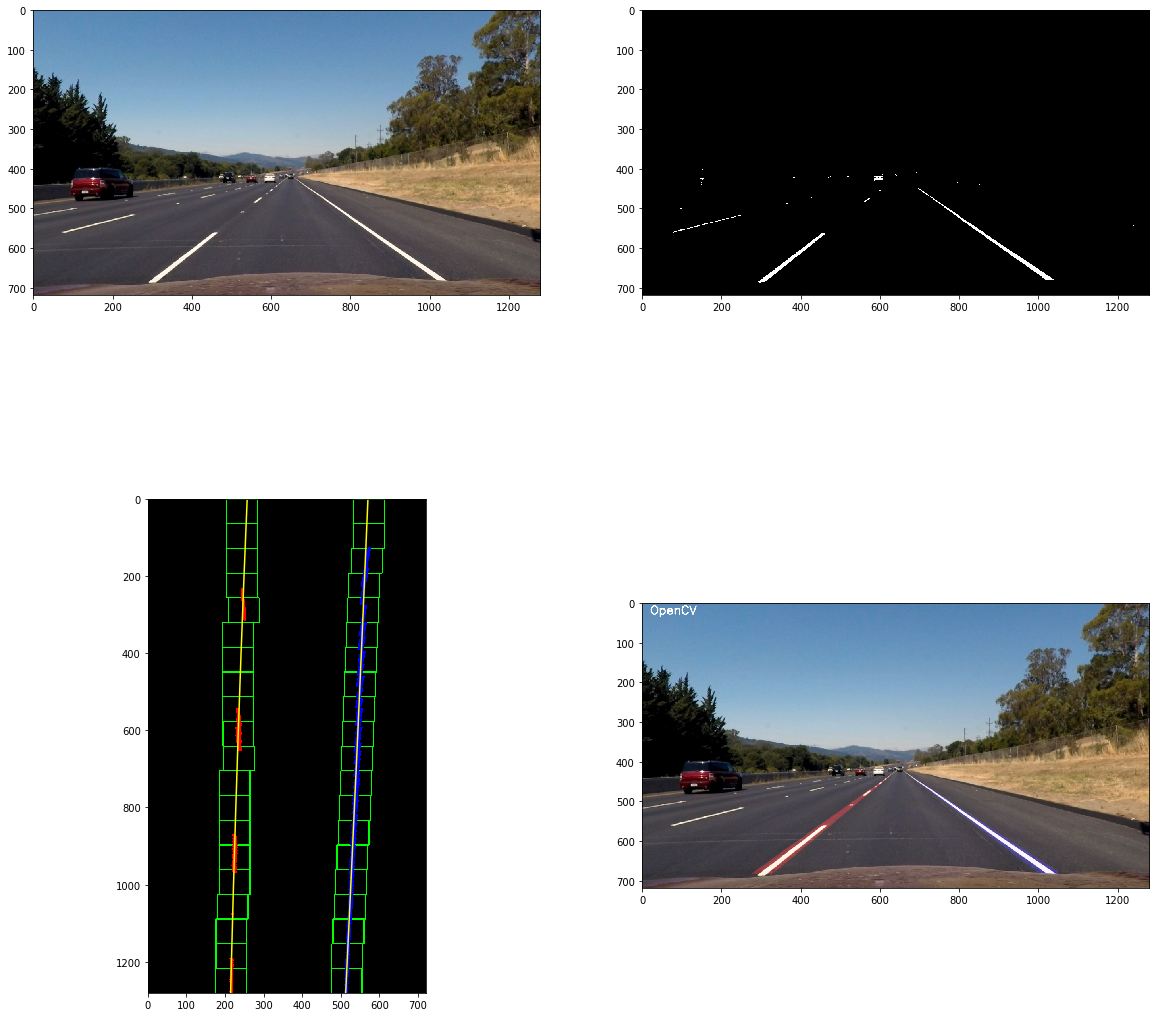

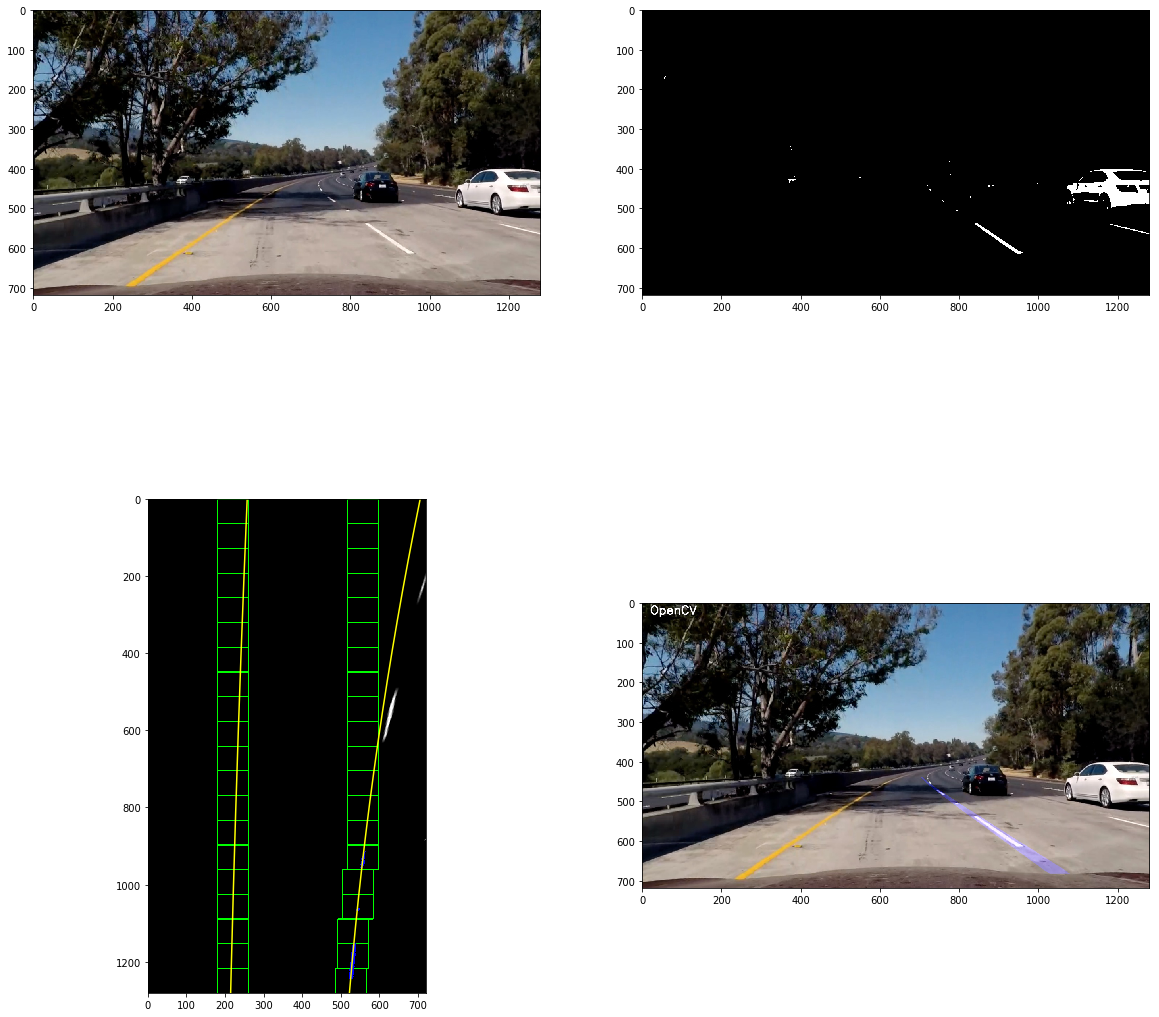

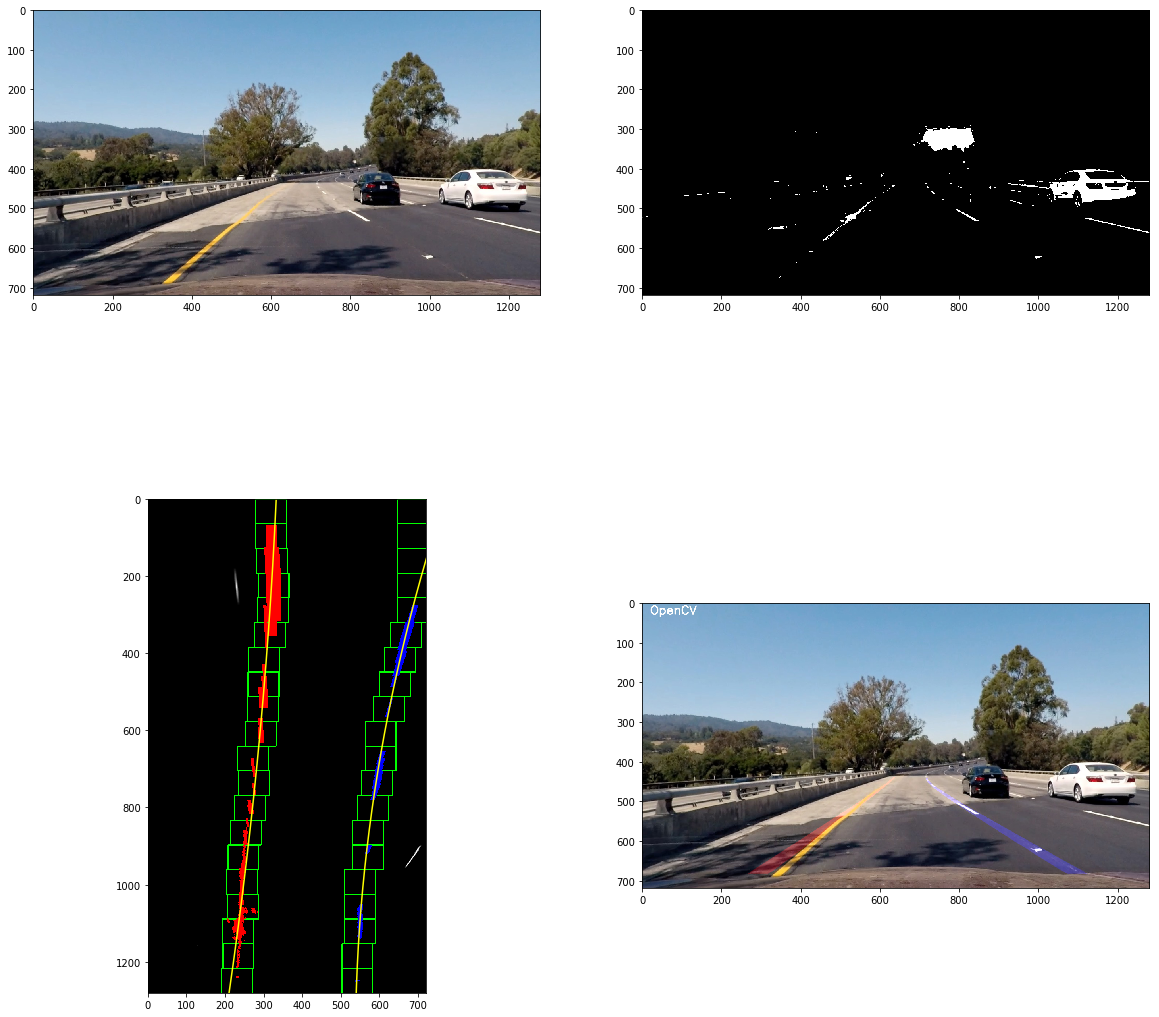

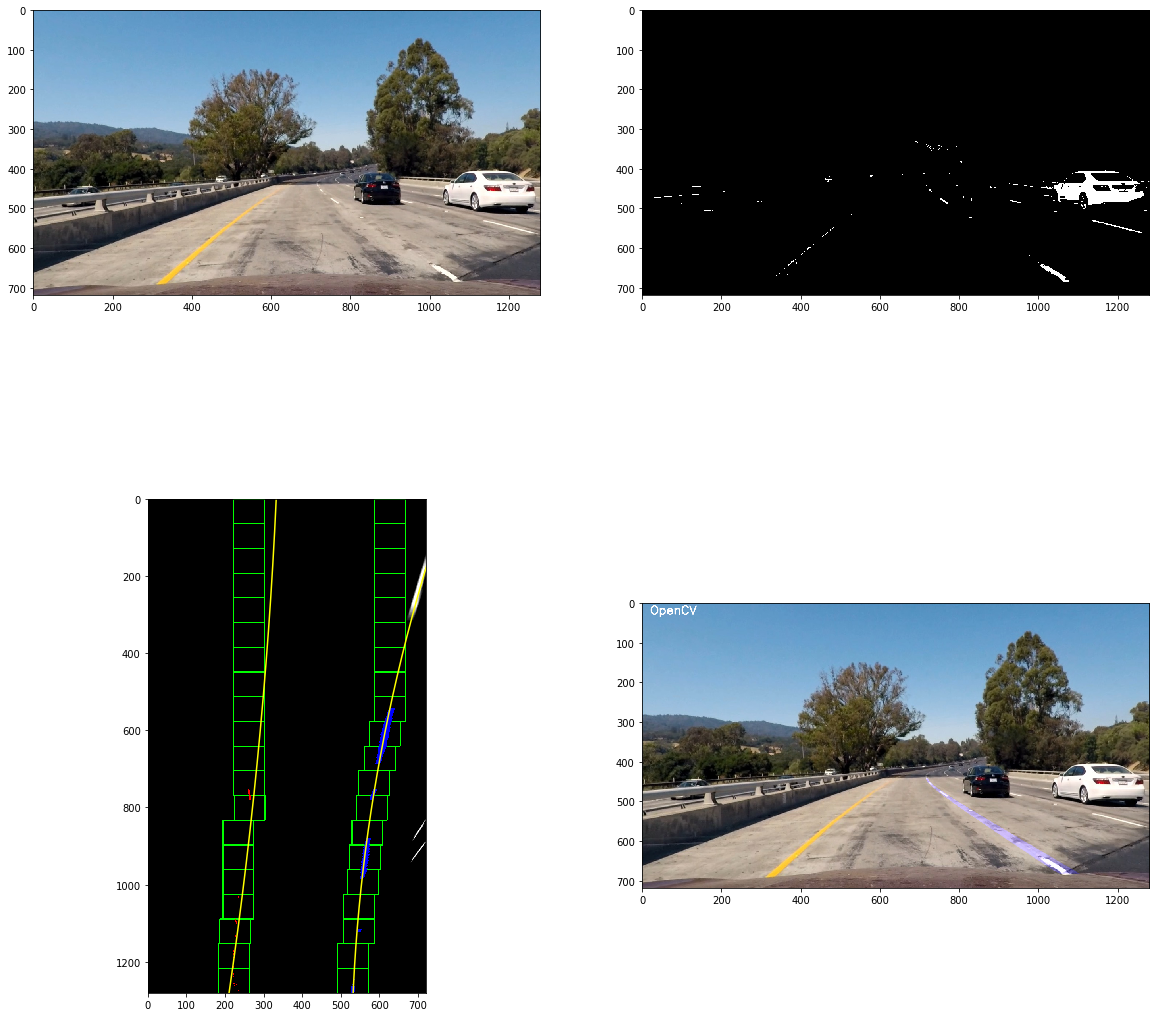

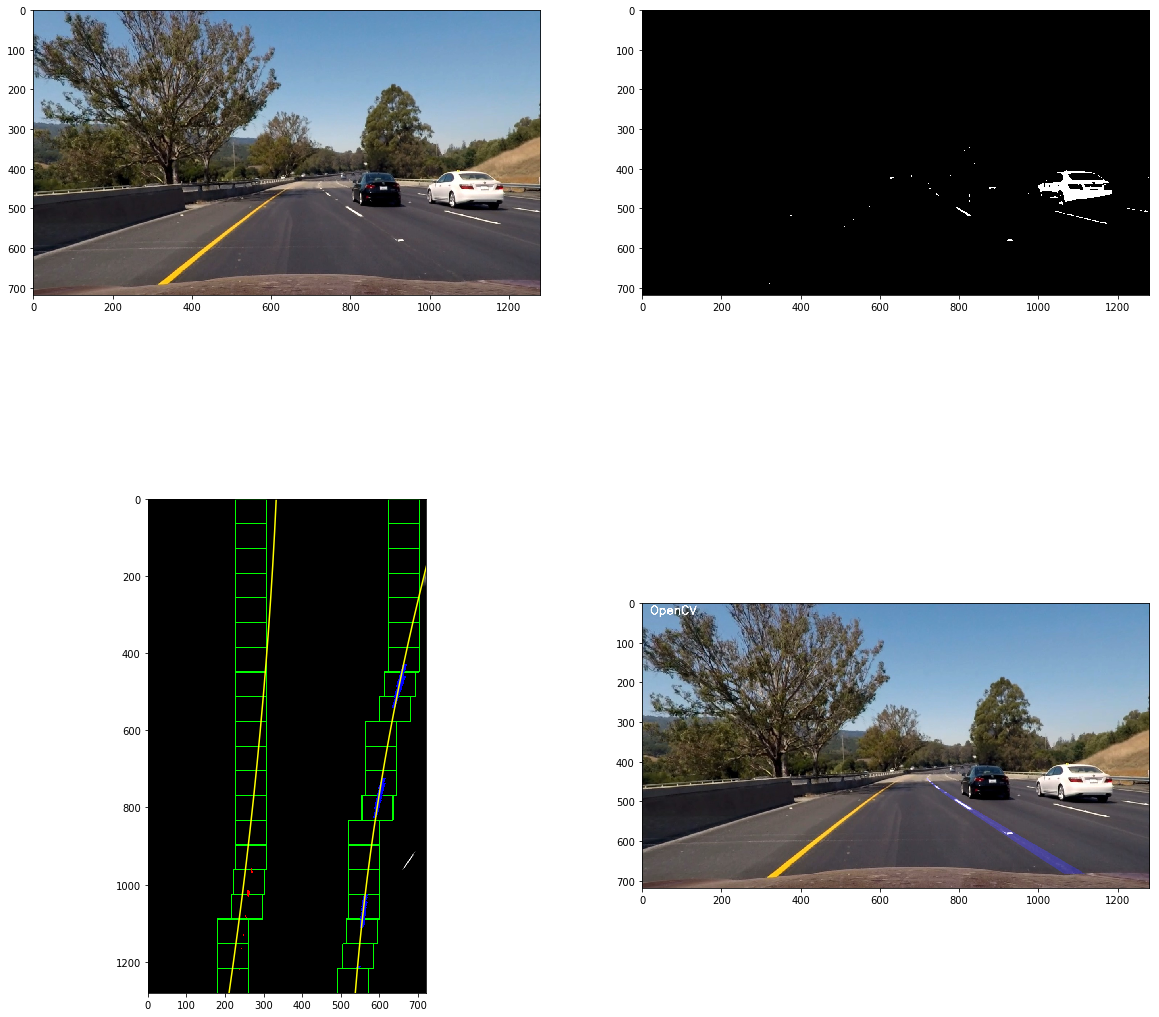

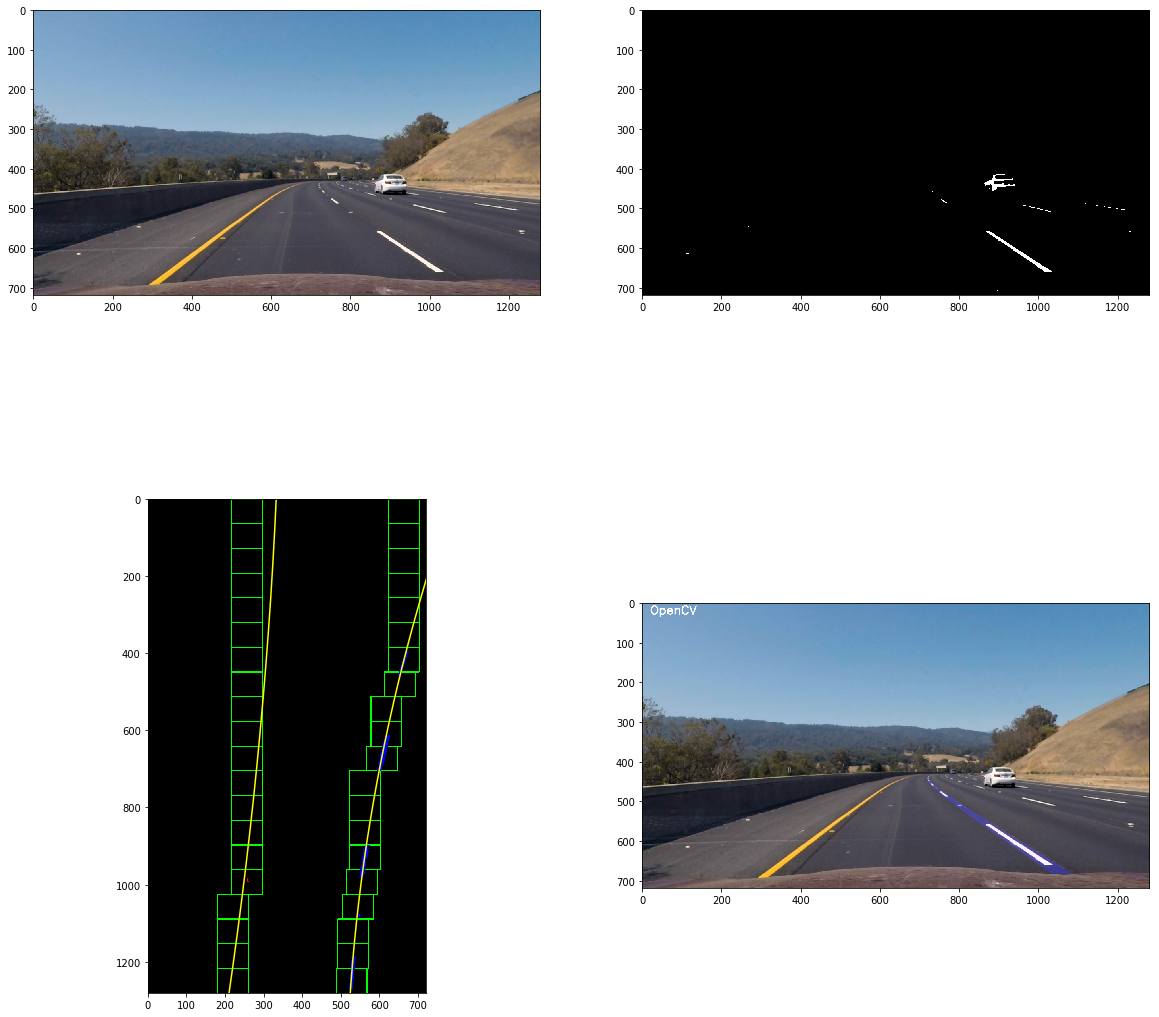

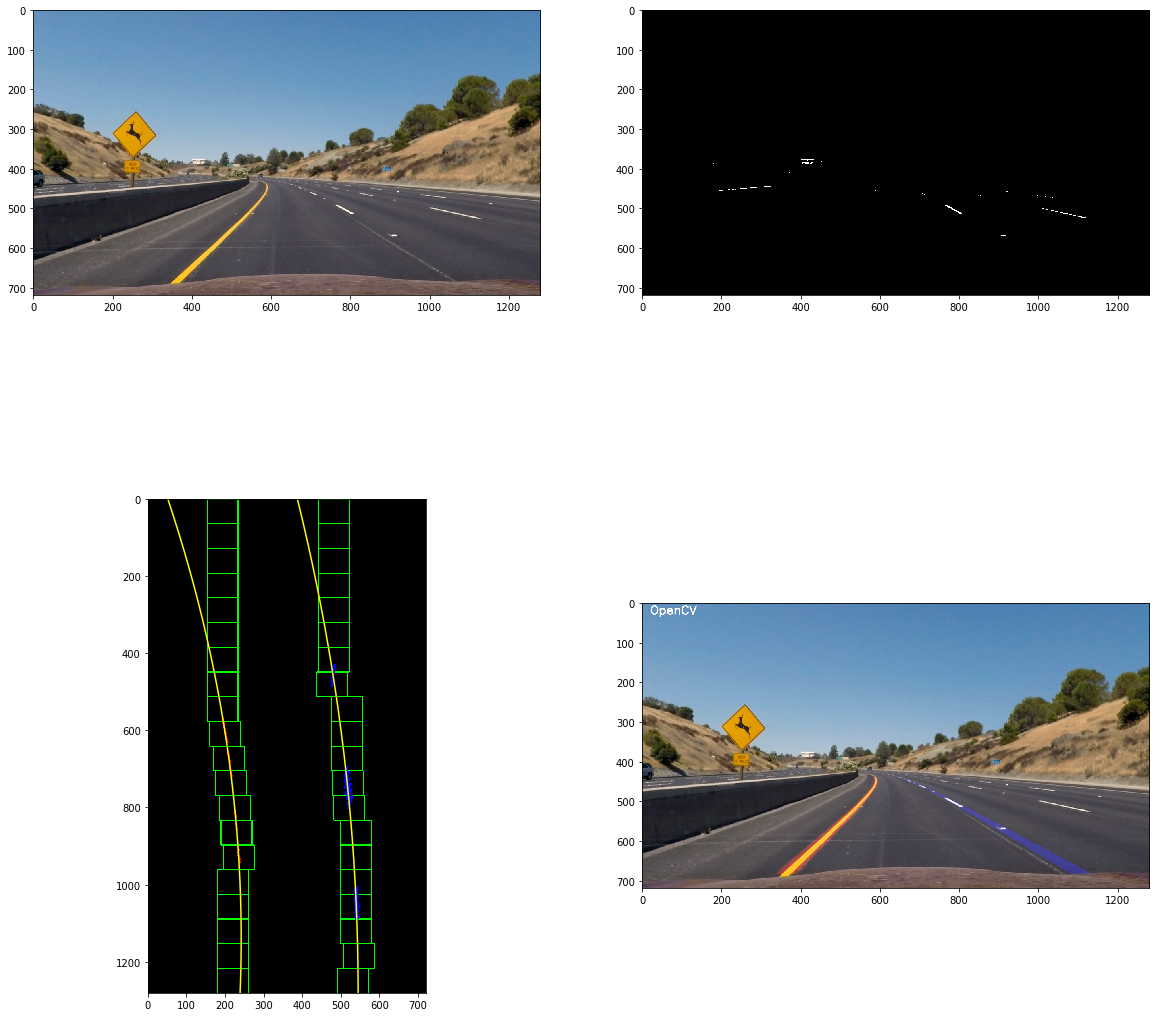

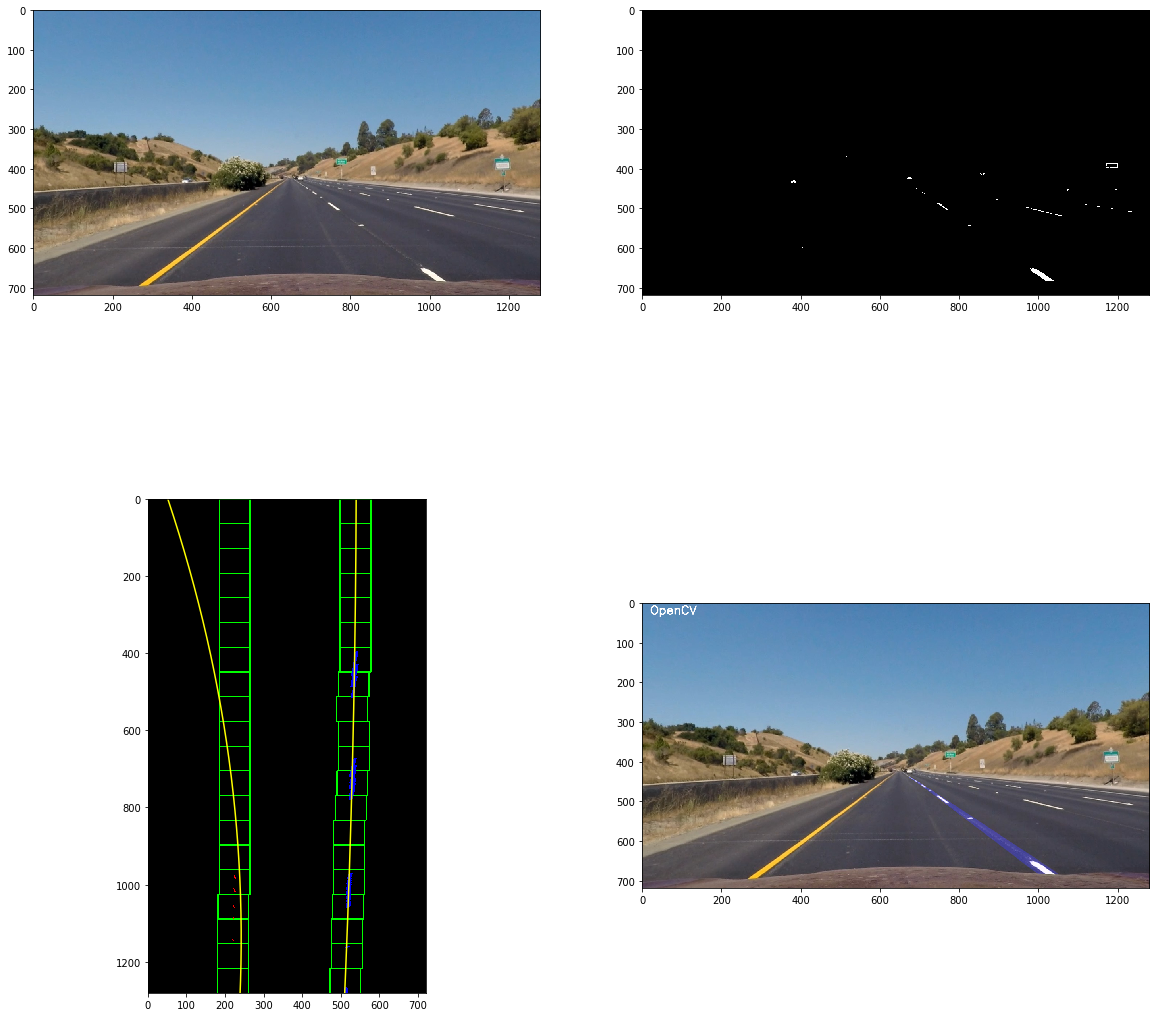

In [192]:

#fig = plt.figure(figsize = (20, 20))
for i, fimage in enumerate(glob.glob('test_images/*.jpg')):
    fig = plt.figure(figsize = (20, 20))
    img = undistort(cv2.imread(fimage))
    show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    red = img[:,:,2]
    
    #plot original image
    fig.add_subplot(2, 2, 1)
    plt.imshow(show_img)
    
    sobelr = sobelx(red)
    threshw = thresh_white(img)
    threshs = thresh_hlS(img)
    threshy = thresh_yellow(img)
    threshg = thresh_green(img)
    
    combined = np.dstack((sobelr, threshs, threshy))
    combined_binary = cv2.bitwise_or(sobelr, threshw)
    combined_binary = cv2.bitwise_or(combined_binary, threshs)
    combined_binary = cv2.bitwise_or(combined_binary, threshy)
    combined_binary = cv2.bitwise_and(combined_binary, cv2.bitwise_not(threshg))
    
    mask = np.zeros_like(combined_binary)
    pts_roi = np.array([[[215, 690],[560, 390],[720, 390],[1100, 690]]], np.int32)
    cv2.fillPoly(mask, pts_roi, 255)
    combined_binary = cv2.bitwise_and(threshw, mask)
    
    transformed = transform(combined_binary)
    
    leftx_base = 220
    rightx_base = 530
    
    left_fit, right_fit, sliding = sliding_window(transformed, leftx_base, rightx_base)
    
    
    marked_lanes = np.zeros_like(sliding)
    ploty = np.linspace(0, w-1, w )
    
    if left_fit != None:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        cv2.polylines(marked_lanes, np.int_(pts_left), False, (255, 0, 0), 20, cv2.LINE_AA)
        left_curve = calcCurvature(ploty, left_fitx)
        print(fimage, 'Left', left_curve)
    
    if right_fit != None:
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        cv2.polylines(marked_lanes, np.int_(pts_right), False, (0, 0, 255), 20, cv2.LINE_AA)
        right_curve = calcCurvature(ploty, right_fitx)
        print(fimage, 'Right', right_curve)
        
    
    
    #pts = np.hstack((pts_left, pts_right))
    #cv2.fillPoly(marked_lanes, np.int_([pts]), (0,255, 0))
    #cv2.addWeighted(sliding, 1, marked_lanes, 0.3, 0)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    retransformed = retransform(marked_lanes)
    # Combine the result with the original image
    result = cv2.addWeighted(show_img, 1, retransformed, 0.3, 0)
    cv2.putText(result,'OpenCV', (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    fig.add_subplot(2, 2, 2)
    plt.imshow(threshw, cmap = 'gray')
    
    fig.add_subplot(2, 2, 3)
    plt.imshow(sliding)    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, h)
    plt.ylim(w, 0)
    
    fig.add_subplot(2, 2, 4)
    plt.imshow(result)
    

### State Class

In [193]:
class State():
    
    def __init__(self):
        self.frame = 0
        self.found = [False, False]
        self.left_fit = None
        self.right_fit = None
        self.lanePoly = None


### Pipeline

In [194]:

def pipeline(img):   
    
    state.frame += 1
    
    #Step 1 Undistort
    uimg = undistort(img)
    
    #get Params
    h, w = uimg.shape[:2]
    ploty = np.linspace(0, w-1, w )
    
    #Step 2 Color and Gradients
    red = img[:,:,2]
    sobelr = sobelx(red)
    threshw = thresh_white(img)
    threshs = thresh_hlS(img)
    threshy = thresh_yellow(img)
    threshg = thresh_green(img)
    
    combined_binary = cv2.bitwise_or(sobelr, threshw)
    combined_binary = cv2.bitwise_or(combined_binary, threshs)
    combined_binary = cv2.bitwise_or(combined_binary, threshy)
    combined_binary = cv2.bitwise_and(combined_binary, cv2.bitwise_not(threshg)) #lane markings are never green
    
    #Step 3 ROI
    if state.lanePoly is not None:
        mask = cv2.dilate(state.lanePoly, np.ones((17,17), np.uint8), iterations = 1)
    else:
        pts_roi = np.array([[[215, 690],[560, 390],[720, 390],[1100, 690]]], np.int32)
        mask = np.zeros_like(combined_binary)
        cv2.fillPoly(mask, pts_roi, 255)
    #Sanity Check
    (left_fit, right_fit, debug1), dbase = find_lanes(threshw, mask, state.left_fit, state.right_fit)
    sane, values = checkSanity(ploty, left_fit, right_fit, state.left_fit, state.right_fit)
    print('White:', sane)
    if not sane[0] or not sane[1]:
        if sane[0]:
            (_, right_fit, debug2), dbase = find_lanes(threshy, mask, left_fit, state.right_fit)
        elif sane[1]:
            (left_fit, _, debug2), dbase = find_lanes(threshy, mask, state.left_fit, right_fit)
        else:
            (left_fit, right_fit, debug2), dbase = find_lanes(threshy, mask, state.left_fit, state.right_fit)
        sane, values = checkSanity(ploty, left_fit, right_fit, state.left_fit, state.right_fit)
        print('Yellow:', sane)
    if not sane[0] or not sane[1]:
        if sane[0]:
            (_, right_fit, debug3), dbase = find_lanes(combined_binary, mask, left_fit, state.right_fit)
        elif sane[1]:
            (left_fit, _, debug3), dbase = find_lanes(combined_binary, mask, state.left_fit, right_fit)
        else:
            (left_fit, right_fit, debug3), dbase = find_lanes(combined_binary, mask, state.left_fit, state.right_fit)
        sane, values = checkSanity(ploty, left_fit, right_fit, state.left_fit, state.right_fit)
        print('Combined:', sane)
    #if not sane[0] or not sane[1]:
    cv2.imwrite('test_images/debug/{}eimg.png'.format(state.frame), img)
    cv2.imwrite('test_images/debug/{}emask.png'.format(state.frame), cv2.bitwise_and(combined_binary, mask))
    cv2.imwrite('test_images/debug/{}edebug1.png'.format(state.frame), debug1)
    cv2.imwrite('test_images/debug/{}edebug2.png'.format(state.frame), debug2)
    cv2.imwrite('test_images/debug/{}edebug3.png'.format(state.frame), debug3)
    print(sane, values, dbase)
        #assert(False)

    if left_fit is None or not sane[0] and state.found[0]:
        left_fit = state.left_fit
    if right_fit is None or not sane[1] and state.found[1]:
        right_fit = state.right_fit
        
    #Step 6 Draw lines
    marked_lanes = np.zeros((w, h, 3), np.uint8)
    lanePoly = np.zeros_like(transformed)
    
    if left_fit is not None:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        if state.found[0]:
            old_left_fitx = state.left_fit[0]*ploty**2 + state.left_fit[1]*ploty + state.left_fit[2]
            left_fitx = np.mean((left_fitx, old_left_fitx), axis = 0)
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        cv2.polylines(marked_lanes, np.int_(pts_left), False, (255, 0, 0), 20, cv2.LINE_AA)
    
    if right_fit is not None:
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        if state.found[1]:
            old_right_fitx = state.right_fit[0]*ploty**2 + state.right_fit[1]*ploty + state.right_fit[2]
            right_fitx = np.mean((right_fitx, old_right_fitx), axis = 0)
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        cv2.polylines(marked_lanes, np.int_(pts_right), False, (0, 0, 255), 20, cv2.LINE_AA)
    
    if left_fit is not None and right_fit is not None:
        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(marked_lanes, np.int_([pts]), (0,255, 0))
        cv2.fillPoly(lanePoly, np.int_([pts]), 255)

    retransformed = retransform(marked_lanes)
    # Combine the result with the original image
    result = cv2.addWeighted(uimg, 1, retransformed, 0.3, 0)

    #Step 7 Calculate curvature:
    curverad = 0
    if left_fit is not None:
        left_curverad = calcCurvature(ploty, left_fitx)
        curverad = left_curverad
    if right_fit is not None:
        right_curverad = calcCurvature(ploty, right_fitx)
        curverad = right_curverad
    if left_fit is not None and right_fit is not None:
        curverad = (left_curverad + right_curverad) / 2
    cv2.putText(result,'Curve Radius: {}m'.format(curverad), (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    #Step 8 Save parameters
    state.found = sane
    if sane[0]:
        state.left_fit = left_fit
    else:
        state.left_fit = None
    if sane[1]:
        state.right_fit = right_fit
    else:
        state.right_fit = None
    state.lanePoly = retransform(lanePoly)
    
    return result
    

In [126]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [202]:
state = State()

output = 'output_images/project_video.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (326.22927326173766, 28.173475831762744, -1, -1) (214, 602)
[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4



  0%|          | 0/1261 [00:00<?, ?it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (325.59994412499981, 34.1595363074386, -1, -1) (229.49407661452639, 557.00388469878249)



  0%|          | 1/1261 [00:00<13:55,  1.51it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (324.12423596337783, 10.32438258608272, -1, -1) (231.39884039402719, 556.60776997185042)



  0%|          | 2/1261 [00:01<13:49,  1.52it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (322.73169800941889, 9.333120643062216, -1, -1) (232.47921676022955, 556.25260431400227)



  0%|          | 3/1261 [00:01<13:42,  1.53it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (322.17708747384495, 15.546319985825448, -1, -1) (233.51436296312315, 556.2248210676255)



  0%|          | 4/1261 [00:02<13:35,  1.54it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (321.96486195632264, 11.297512634769419, -1, -1) (234.0422009342646, 556.37294198729364)



  0%|          | 5/1261 [00:03<13:31,  1.55it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (321.28067111214364, 2.2873649981180506, -1, -1) (234.40135718008179, 556.37301812007331)



  0%|          | 6/1261 [00:03<13:26,  1.56it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (322.86493701167007, 43.985473175279878, -1, -1) (235.08179532576708, 557.67584286286785)



  1%|          | 7/1261 [00:04<13:18,  1.57it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (316.88010937258696, 93.126398822495048, -1, -1) (234.79311441150352, 556.90505794602961)



  1%|          | 8/1261 [00:05<13:18,  1.57it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (318.04495434789078, 34.436100899160408, -1, -1) (240.03697687294425, 557.5525640310143)



  1%|          | 9/1261 [00:05<13:16,  1.57it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (321.90061882008069, 93.540509145481565, -1, -1) (239.51393126773209, 558.78047949776987)



  1%|          | 10/1261 [00:06<13:15,  1.57it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  1%|          | 11/1261 [00:06<13:01,  1.60it/s]

[True, True] (322.06441636671815, 172.03080342795312, -1, -1) (236.86376950561421, 559.14116195322458)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (322.24687814119812, 229.0107343205554, 76.379786864183984, 133.35971775678627) (237.05004761294543, 560.1983738139204)



  1%|          | 12/1261 [00:07<13:11,  1.58it/s]

White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (326.30910276018551, 74.934941778378686, -1, -1) (237.95097903647263, 560.1983738139204)



  1%|          | 13/1261 [00:08<13:05,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.69592196026713, 111.57588973254229, -1, -1) (234.84533791984785, 559.25926823714121)



  1%|          | 14/1261 [00:08<13:06,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.34686595010248, 136.74226731932174, -1, -1) (232.54041622391344, 557.38958912349335)



  1%|          | 15/1261 [00:09<13:03,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.20120236151547, 160.17588974962524, -1, -1) (230.99853431551898, 555.13393331658813)



  1%|▏         | 16/1261 [00:10<13:01,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.90152312693778, 154.89640324242833, -1, -1) (228.86840648733491, 553.98734004501)



  1%|▏         | 17/1261 [00:10<13:03,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (325.28342881172574, 201.00818684933944, 2.1212541500173643, 43.990529456893739) (227.01522646761026, 553.17693591515035)



  1%|▏         | 18/1261 [00:11<13:03,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.20320608072188, 201.09913744485169, 13.387638689021514, 13.478589284533768) (227.81846791976875, 553.46795629176313)



  2%|▏         | 19/1261 [00:12<13:03,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.48755687878162, 227.80680443052796, 13.115207333780518, 39.822874319456787) (227.20114857247333, 553.7094017015977)



  2%|▏         | 20/1261 [00:12<13:03,  1.58it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (324.09142454095678, 18.644572840712328, -1, -1) (227.16711360062789, 550.68688909665741)



  2%|▏         | 21/1261 [00:13<13:03,  1.58it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (323.31089586277318, 19.329125022532139, -1, -1) (226.58244268773529, 549.86087954247876)



  2%|▏         | 22/1261 [00:13<13:00,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (324.79158616939264, 25.909392008833606, -1, -1) (226.5520274394251, 549.65220281687721)



  2%|▏         | 23/1261 [00:14<12:57,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (322.31515950539654, 21.067785958867717, -1, -1) (224.86676004141555, 549.81139086640792)



  2%|▏         | 24/1261 [00:15<12:57,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (324.26863226873274, 14.609671529511047, -1, -1) (227.50358132571134, 549.16846995485309)



  2%|▏         | 25/1261 [00:15<13:12,  1.56it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.79371655612852, 28.338089309753229, -1, -1) (224.89561754829992, 549.86001132753449)



  2%|▏         | 26/1261 [00:16<13:17,  1.55it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (327.71312679829157, 19.584357593648065, -1, -1) (223.06624407924795, 550.3946481226792)



  2%|▏         | 27/1261 [00:17<13:20,  1.54it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (329.28223113650085, 10.33179921078198, -1, -1) (222.68413611230227, 551.82965851452991)



  2%|▏         | 28/1261 [00:17<13:28,  1.53it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.22447360103399, 11.86228272233592, -1, -1) (222.5633386489304, 552.58739099068202)



  2%|▏         | 29/1261 [00:18<13:26,  1.53it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.84951736833642, 31.793078899170212, -1, -1) (226.38232219513534, 552.55813054395981)



  2%|▏         | 30/1261 [00:19<13:15,  1.55it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.26393603225193, 20.707743907909901, -1, -1) (225.70617041329405, 552.56731146821562)



  2%|▏         | 31/1261 [00:19<13:06,  1.56it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.50648542829089, 49.902872874503544, -1, -1) (226.29329272583624, 552.40918355581425)



  3%|▎         | 32/1261 [00:20<13:00,  1.57it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.3127455253221, 17.35411597139921, -1, -1) (225.86864950033987, 552.88101769514924)



  3%|▎         | 33/1261 [00:21<12:56,  1.58it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  3%|▎         | 34/1261 [00:21<12:46,  1.60it/s]

[True, True] (326.51405924780033, 56.979519216946699, -1, -1) (226.55306565966242, 553.08159124798419)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  3%|▎         | 35/1261 [00:22<12:37,  1.62it/s]

[True, True] (326.03215239639246, 9.5818524417887261, -1, -1) (226.53767883787532, 552.19970933813352)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  3%|▎         | 36/1261 [00:22<12:34,  1.62it/s]

[True, True] (326.13555611426614, 108.77554582449329, -1, -1) (226.1446894966349, 553.3299691619759)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  3%|▎         | 37/1261 [00:23<12:31,  1.63it/s]

[True, True] (322.42881217218132, 11.956738539732669, -1, -1) (227.14898057642264, 551.31623885091631)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  3%|▎         | 38/1261 [00:24<12:24,  1.64it/s]

[True, True] (319.1377138405241, 29.108063512320086, -1, -1) (228.87104663410528, 549.94126493757733)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  3%|▎         | 39/1261 [00:24<12:22,  1.65it/s]

[True, True] (317.12853976845577, 28.505990752745788, -1, -1) (230.79509466347446, 548.79248447156851)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  3%|▎         | 40/1261 [00:25<12:19,  1.65it/s]

[True, True] (314.98263982169868, 40.23962705959309, -1, -1) (231.65069232028739, 548.99722760329598)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  3%|▎         | 41/1261 [00:25<12:17,  1.65it/s]

[True, True] (314.82179429514889, 53.081556893729839, -1, -1) (234.01432846302055, 549.01800038990802)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  3%|▎         | 42/1261 [00:26<12:13,  1.66it/s]

[True, True] (314.96766401436901, 39.660802311671546, -1, -1) (234.1985277959518, 550.07008912677634)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  3%|▎         | 43/1261 [00:27<12:22,  1.64it/s]

[True, True] (314.92878036271219, 46.565014506002854, -1, -1) (235.10225027744136, 550.95711934681663)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  3%|▎         | 44/1261 [00:27<12:19,  1.65it/s]

[True, True] (318.07167671349259, 40.824574836688271, -1, -1) (236.03655107872754, 551.54778781733523)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  4%|▎         | 45/1261 [00:28<12:19,  1.64it/s]

[True, True] (318.12404859889807, 75.279816478524253, -1, -1) (233.48181893730717, 551.53626581546632)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (318.66979562343244, 67.121279936429517, -1, -1) (233.4334914605088, 551.8722965850385)



  4%|▎         | 46/1261 [00:28<12:28,  1.62it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (318.95807379528617, 97.316080013765145, -1, -1) (233.22001269119983, 552.23086815290071)



  4%|▎         | 47/1261 [00:29<12:27,  1.62it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  4%|▍         | 48/1261 [00:30<12:28,  1.62it/s]

[True, True] (320.57171782406942, 69.052517660381568, -1, -1) (233.29987751373815, 552.4254694951735)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  4%|▍         | 49/1261 [00:30<12:32,  1.61it/s]

[True, True] (322.04897443561475, 81.749015838115838, -1, -1) (231.86739245809804, 552.26496118704688)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  4%|▍         | 50/1261 [00:31<12:31,  1.61it/s]

[True, True] (321.92863049259654, 81.425201254933086, -1, -1) (230.23883274156844, 552.66023150702028)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  4%|▍         | 51/1261 [00:32<12:35,  1.60it/s]

[True, True] (322.52962127904499, 89.270673788469253, -1, -1) (230.75155519530014, 552.80364275756222)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (322.52375680490786, 76.011248062104983, -1, -1) (230.29348153774265, 551.83830600225178)



  4%|▍         | 52/1261 [00:32<12:43,  1.58it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (322.09986992175067, 70.912341373951165, -1, -1) (229.32247810792535, 551.19185952008047)



  4%|▍         | 53/1261 [00:33<12:42,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  4%|▍         | 54/1261 [00:33<12:38,  1.59it/s]

[True, True] (322.31130678958749, 53.872857909068443, -1, -1) (229.09545223828957, 551.03438009196338)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (324.53300975835072, 41.733768077763102, -1, -1) (228.71701278344858, 551.48412326094331)



  4%|▍         | 55/1261 [00:34<12:41,  1.58it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  4%|▍         | 56/1261 [00:35<12:33,  1.60it/s]

[True, True] (326.29713161980135, 41.88682465418475, -1, -1) (226.93982590961372, 551.69794229065087)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  5%|▍         | 57/1261 [00:35<12:35,  1.59it/s]

[True, True] (327.28726597711454, 25.705189715730114, -1, -1) (225.38962885002951, 551.94426454682309)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  5%|▍         | 58/1261 [00:36<12:30,  1.60it/s]

[True, True] (327.08028556990507, 17.772754185256758, -1, -1) (224.63776058060611, 552.25749697666538)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (328.54449438707672, 7.4820288705814164, -1, -1) (225.1588343123189, 552.0871942471183)



  5%|▍         | 59/1261 [00:37<12:33,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (330.48349108492687, 219.17970956640687, 18.96626933071326, 192.73141136511219) (223.49717795701034, 553.05955271234802)



  5%|▍         | 60/1261 [00:37<12:35,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  5%|▍         | 61/1261 [00:38<12:36,  1.59it/s]

[True, True] (331.58179561294844, 158.75397465759926, -1, -1) (222.48703282428585, 552.08246264802449)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  5%|▍         | 62/1261 [00:38<12:30,  1.60it/s]

[True, True] (330.73113388618845, 132.41877360663347, -1, -1) (220.40107524618975, 550.21236954081201)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  5%|▍         | 63/1261 [00:39<12:24,  1.61it/s]

[True, True] (329.84909624958652, 107.73293844577421, -1, -1) (219.37447282675689, 548.83769971329912)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (328.21612432088534, 102.58122706623269, -1, -1) (218.8955205340726, 547.26850316309299)



  5%|▌         | 64/1261 [00:40<12:36,  1.58it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (328.95478611283022, 137.24905207177054, -1, -1) (218.95654985625438, 546.80124595340794)



  5%|▌         | 65/1261 [00:40<12:34,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  5%|▌         | 66/1261 [00:41<12:26,  1.60it/s]

[True, True] (327.25961220526972, 132.67259907516319, -1, -1) (217.75339854465835, 545.71383245132949)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  5%|▌         | 67/1261 [00:42<12:18,  1.62it/s]

[True, True] (326.93882052366587, 131.70101161886794, -1, -1) (218.36323575075662, 544.89598739705184)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  5%|▌         | 68/1261 [00:42<12:14,  1.62it/s]

[True, True] (328.0644506397212, 165.52204302220821, -1, -1) (217.87078481130757, 544.42446776536406)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (327.56501034125324, 172.24118581496748, -1, -1) (216.27235362067069, 544.14997409831903)



  5%|▌         | 69/1261 [00:43<12:23,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (328.45460972085823, 246.76905343918537, 12.964939973090509, 87.492807597308399) (216.49076821658937, 544.74927564431368)



  6%|▌         | 70/1261 [00:43<12:21,  1.61it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (328.59345757273246, 310.82260345420099, 10.102795228953028, 53.950754786062589) (216.20521479193602, 544.74711736037807)



  6%|▌         | 71/1261 [00:44<12:24,  1.60it/s]

White: [False, False]
Yellow: [False, False]
Combined: [True, True]



  6%|▌         | 72/1261 [00:45<12:25,  1.60it/s]

[True, True] (327.67275891370622, 1.4193742246282, -1, -1) (216.05436330419303, 544.74711736037807)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (323.10184143704049, 34.264155736878479, -1, -1) (215.84126955243352, 539.82807010699889)



  6%|▌         | 73/1261 [00:45<12:26,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  6%|▌         | 74/1261 [00:46<12:23,  1.60it/s]

[True, True] (322.13767586806568, 20.993089831102964, -1, -1) (216.69724274853445, 537.87274744363287)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  6%|▌         | 75/1261 [00:47<12:19,  1.60it/s]

[True, True] (321.3847213986711, 57.637825107762524, -1, -1) (215.70617356644976, 537.09331709268145)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (323.26155622885972, 24.617819226029951, -1, -1) (215.70192503192811, 537.15550531824374)



  6%|▌         | 76/1261 [00:47<12:23,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  6%|▌         | 77/1261 [00:48<12:19,  1.60it/s]

[True, True] (325.74308816035693, 7.5996995098174125, -1, -1) (213.86818556754085, 538.2235882137943)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  6%|▌         | 78/1261 [00:48<12:14,  1.61it/s]

[True, True] (327.12091606154968, 41.71854395505602, -1, -1) (212.4664066332283, 538.90885648780727)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  6%|▋         | 79/1261 [00:49<12:12,  1.61it/s]

[True, True] (327.60998116034693, 68.619954328846347, -1, -1) (211.78361521762952, 539.08411890326761)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (328.798622837842, 43.838168765726152, -1, -1) (211.48040388596991, 539.43120468807172)



  6%|▋         | 80/1261 [00:50<12:17,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  6%|▋         | 81/1261 [00:50<12:18,  1.60it/s]

[True, True] (330.86067208894229, 0.2802143116018101, -1, -1) (210.63057121033648, 539.20055650383517)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  7%|▋         | 82/1261 [00:51<12:11,  1.61it/s]

[True, True] (331.10869522156963, 0.4690004210758616, -1, -1) (208.31351600677635, 539.63472544827243)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  7%|▋         | 83/1261 [00:52<12:06,  1.62it/s]

[True, True] (332.80217276621227, 16.806856027902768, -1, -1) (208.50627103148412, 540.36301228002424)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (333.38135515094984, 14.188531347366563, -1, -1) (207.53489315562257, 541.705945325843)



  7%|▋         | 84/1261 [00:52<12:10,  1.61it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  7%|▋         | 85/1261 [00:53<12:08,  1.61it/s]

[True, True] (335.94596682457188, 23.951872852682129, -1, -1) (208.32346725976393, 542.22731364026845)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  7%|▋         | 86/1261 [00:53<12:09,  1.61it/s]

[True, True] (337.0959445803303, 48.035669367158334, -1, -1) (206.26325783431025, 542.58574705249089)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  7%|▋         | 87/1261 [00:54<12:06,  1.62it/s]

[True, True] (337.20887708678583, 96.882450165853129, -1, -1) (205.46212146949466, 542.20486064083855)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  7%|▋         | 88/1261 [00:55<12:04,  1.62it/s]

[True, True] (335.1298997048807, 69.246596954250521, -1, -1) (204.92862523873089, 540.40645563034082)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  7%|▋         | 89/1261 [00:55<12:02,  1.62it/s]

[True, True] (334.41774297134111, 106.76908348958983, -1, -1) (205.20055822189775, 539.69152299508346)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  7%|▋         | 90/1261 [00:56<12:03,  1.62it/s]

[True, True] (331.88733668210972, 104.95579217440454, -1, -1) (205.17942192987144, 538.59242077739304)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  7%|▋         | 91/1261 [00:56<12:04,  1.61it/s]

[True, True] (330.88510111937813, 94.497546344142705, -1, -1) (206.59608237909271, 538.54081941742947)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (329.18057495949483, 92.629534653078565, -1, -1) (207.56575421403301, 538.57949708886622)



  7%|▋         | 92/1261 [00:57<12:05,  1.61it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  7%|▋         | 93/1261 [00:58<11:58,  1.63it/s]

[True, True] (329.44324662745157, 123.49858252283204, -1, -1) (209.31995013337152, 538.41145019871499)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  7%|▋         | 94/1261 [00:58<11:55,  1.63it/s]

[True, True] (328.87561771094869, 149.1853197440918, -1, -1) (208.8706639776309, 538.25486989165131)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  8%|▊         | 95/1261 [00:59<11:50,  1.64it/s]

[True, True] (328.94420106270491, 163.0642590102309, -1, -1) (209.27662406143975, 538.22673995036996)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  8%|▊         | 96/1261 [01:00<11:55,  1.63it/s]

[True, True] (327.68774793683258, 179.47532161379146, -1, -1) (209.18452478726616, 538.52936441755128)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  8%|▊         | 97/1261 [01:00<11:57,  1.62it/s]

[True, True] (325.96090974573224, 74.585321451993337, -1, -1) (210.75232158825241, 536.67885125498492)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  8%|▊         | 98/1261 [01:01<11:51,  1.63it/s]

[True, True] (323.96372786486722, 56.170188491144359, -1, -1) (210.64544162313666, 535.30765536135664)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  8%|▊         | 99/1261 [01:01<11:52,  1.63it/s]

[True, True] (323.23812814275578, 48.757918096979751, -1, -1) (211.29221945823159, 534.49867231317785)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (321.6465579965423, 32.98504003289392, -1, -1) (211.20498229184597, 534.16675858578651)



  8%|▊         | 100/1261 [01:02<11:55,  1.62it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  8%|▊         | 101/1261 [01:03<11:56,  1.62it/s]

[True, True] (322.42861786433991, 49.656802495887604, -1, -1) (212.48107544495019, 534.31260404216232)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  8%|▊         | 102/1261 [01:03<11:54,  1.62it/s]

[True, True] (321.14534724497639, 41.305640885544904, -1, -1) (211.83627474107698, 534.2970852315334)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (320.68448354225336, 31.211005405961913, -1, -1) (213.10567242902857, 534.76861338800768)



  8%|▊         | 103/1261 [01:04<11:58,  1.61it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (320.97049717113111, 34.186542725544939, -1, -1) (214.04654481557148, 535.34942373690467)



  8%|▊         | 104/1261 [01:04<12:00,  1.61it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  8%|▊         | 105/1261 [01:05<12:00,  1.60it/s]

[True, True] (322.85431427291593, 52.020091277100562, -1, -1) (214.3388518049014, 537.26852339864115)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (320.89023805858307, 22.990476532677462, -1, -1) (214.3817851433231, 538.61559266964821)



  8%|▊         | 106/1261 [01:06<12:00,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (322.3508838184062, 29.501784865996342, -1, -1) (217.71393543225389, 540.11901036824611)



  8%|▊         | 107/1261 [01:06<11:55,  1.61it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (320.16696198942088, 40.358788656519607, -1, -1) (217.76317383237136, 541.11265407306087)



  9%|▊         | 108/1261 [01:07<12:04,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (318.14326612104321, 17.969698706955967, -1, -1) (220.93481445152995, 541.51473392331263)



  9%|▊         | 109/1261 [01:08<12:10,  1.58it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (318.50287371628804, 6.3719250602374018, -1, -1) (223.37237918881561, 541.9712334507069)



  9%|▊         | 110/1261 [01:08<12:15,  1.56it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (313.54546047233208, 17.648258572199893, -1, -1) (223.47162178551014, 542.30947975096808)



  9%|▉         | 111/1261 [01:09<12:15,  1.56it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (314.7696609070191, 3.6989896068433268, -1, -1) (228.78434858847237, 543.37797025392115)



  9%|▉         | 112/1261 [01:10<12:14,  1.56it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  9%|▉         | 113/1261 [01:10<12:06,  1.58it/s]

[True, True] (318.9812471783614, 47.712382496382247, -1, -1) (228.63771321981159, 540.91176672807444)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  9%|▉         | 114/1261 [01:11<11:57,  1.60it/s]

[True, True] (313.93140282617151, 81.195067487509164, -1, -1) (221.9441787100821, 540.76205078397106)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  9%|▉         | 115/1261 [01:11<11:57,  1.60it/s]

[True, True] (316.41861806442807, 54.126312927345566, -1, -1) (226.86502681588223, 541.06388207841655)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (317.89595619694455, 39.222868999349743, -1, -1) (224.65698100924047, 541.66064873818254)



  9%|▉         | 116/1261 [01:12<12:01,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  9%|▉         | 117/1261 [01:13<12:00,  1.59it/s]

[True, True] (319.01363518887973, 32.791879328728953, -1, -1) (223.76258969583876, 542.38258097538267)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (318.37771236783504, 42.601521878503831, -1, -1) (223.36273546517953, 542.95361618735194)



  9%|▉         | 118/1261 [01:13<12:01,  1.58it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



  9%|▉         | 119/1261 [01:14<11:49,  1.61it/s]

[True, True] (314.19460843260572, 79.814036726625602, -1, -1) (224.57523597792857, 543.29251396759912)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 10%|▉         | 120/1261 [01:15<11:48,  1.61it/s]

[True, True] (315.45523272223977, 49.91583061624425, -1, -1) (229.11788654766522, 543.74748630575232)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 10%|▉         | 121/1261 [01:15<11:45,  1.62it/s]

[True, True] (314.33989386632891, 62.935677959263813, -1, -1) (228.28963016123436, 543.6726781856861)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 10%|▉         | 122/1261 [01:16<11:37,  1.63it/s]

[True, True] (313.80933904558015, 62.18654005890798, -1, -1) (229.34071801716817, 543.93133665866685)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 10%|▉         | 123/1261 [01:16<11:27,  1.66it/s]

[True, True] (311.21045239765397, 74.97053768765889, -1, -1) (230.1286865155819, 543.80743827519177)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 10%|▉         | 124/1261 [01:17<11:33,  1.64it/s]

[True, True] (312.37509715272279, 80.174218982047961, -1, -1) (232.60698166308597, 543.35189323065265)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 10%|▉         | 125/1261 [01:18<11:38,  1.63it/s]

[True, True] (312.14118198516144, 80.827190396380416, -1, -1) (230.98438738247921, 543.97540474322329)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 10%|▉         | 126/1261 [01:18<11:28,  1.65it/s]

[True, True] (312.34330145418721, 86.894395637526145, -1, -1) (231.8388999238617, 545.04959507702995)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 10%|█         | 127/1261 [01:19<11:31,  1.64it/s]

[True, True] (316.04803823716145, 55.953368507262951, -1, -1) (232.72413541320805, 546.42000435847069)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 10%|█         | 128/1261 [01:19<11:34,  1.63it/s]

[True, True] (316.1649670744788, 73.253453817677098, -1, -1) (230.36609828281729, 547.51588739660247)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 10%|█         | 129/1261 [01:20<11:36,  1.62it/s]

[True, True] (316.0134842014545, 54.505053136872505, -1, -1) (231.35545452581991, 547.72990875341725)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 10%|█         | 130/1261 [01:21<11:30,  1.64it/s]

[True, True] (315.50329642157567, 64.8377364732535, -1, -1) (231.70102652915725, 547.49916085014434)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 10%|█         | 131/1261 [01:21<11:27,  1.64it/s]

[True, True] (316.28609696282302, 46.378387920960222, -1, -1) (231.98750030522285, 548.08208544671083)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 10%|█         | 132/1261 [01:22<11:29,  1.64it/s]

[True, True] (315.78208369156118, 26.059958819330802, -1, -1) (231.77823138339085, 548.62711567930705)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 11%|█         | 133/1261 [01:22<11:27,  1.64it/s]

[True, True] (316.24710383730303, 29.820018735464657, -1, -1) (232.81748510995212, 549.1117407018221)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 11%|█         | 134/1261 [01:23<11:27,  1.64it/s]

[True, True] (317.50698224024882, 1.6449319009366832, -1, -1) (232.84180903872377, 549.87509187517117)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 11%|█         | 135/1261 [01:24<11:20,  1.66it/s]

[True, True] (320.42984522633878, 18.366144188387921, -1, -1) (232.33222187974266, 550.29927062044374)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 11%|█         | 136/1261 [01:24<11:23,  1.65it/s]

[True, True] (321.52462323656232, 31.470890272470086, -1, -1) (229.8230210286834, 549.83696956961558)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 11%|█         | 137/1261 [01:25<11:23,  1.65it/s]

[True, True] (323.04016931522295, 50.975154362249839, -1, -1) (228.28162155504364, 551.17563114117706)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 11%|█         | 138/1261 [01:25<11:21,  1.65it/s]

[True, True] (324.377006437771, 51.172990927527735, -1, -1) (228.09184392832134, 552.84529612325605)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 11%|█         | 139/1261 [01:26<11:25,  1.64it/s]

[True, True] (325.56965902522205, 37.44908445567745, -1, -1) (228.43477651234261, 552.74139868074371)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (325.09493254166324, 42.79698910563161, -1, -1) (227.14052866751601, 552.66711999825543)



 11%|█         | 140/1261 [01:27<11:33,  1.62it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.59928486370751, 51.21421701236352, -1, -1) (227.56876838755448, 553.35745190019111)



 11%|█         | 141/1261 [01:27<11:34,  1.61it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 11%|█▏        | 142/1261 [01:28<11:31,  1.62it/s]

[True, True] (327.59565872874134, 77.186902290558123, -1, -1) (226.73046281500302, 553.55026965322622)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (327.75696409419982, 94.061340524482546, -1, -1) (225.91733110336551, 552.94566493453226)



 11%|█▏        | 143/1261 [01:29<11:34,  1.61it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 11%|█▏        | 144/1261 [01:29<11:33,  1.61it/s]

[True, True] (326.75387953533277, 91.382294365332314, -1, -1) (225.13405010826273, 552.06918289879422)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (327.86382842095315, 120.64110544405025, -1, -1) (225.26028258557616, 552.667107277799)



 11%|█▏        | 145/1261 [01:30<11:34,  1.61it/s]

White: [False, True]
Yellow: [False, True]



 12%|█▏        | 146/1261 [01:30<11:33,  1.61it/s]

Combined: [True, True]
[True, True] (330.35684267478064, 173.59620368226649, -1, -1) (224.74504743631928, 552.93643927435505)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.65466995926784, 12.894581325153752, -1, -1) (222.49887317096793, 550.24079334120097)



 12%|█▏        | 147/1261 [01:31<11:36,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (328.61389673327096, 67.50526638805502, -1, -1) (223.54661134827597, 549.52144806917318)



 12%|█▏        | 148/1261 [01:32<11:37,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (327.4892748486775, 59.663468794732182, -1, -1) (220.81772229073616, 548.70812127160684)



 12%|█▏        | 149/1261 [01:32<11:38,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 12%|█▏        | 150/1261 [01:33<11:35,  1.60it/s]

[True, True] (327.68280618314083, 60.830568140658897, -1, -1) (221.13596934362738, 548.35015563513878)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (327.07671884880051, 54.283971121395638, -1, -1) (220.59355018300209, 548.29512446848139)



 12%|█▏        | 151/1261 [01:34<11:36,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.14166304999696, 44.654761207752017, -1, -1) (221.15526122128904, 548.30790763293726)



 12%|█▏        | 152/1261 [01:34<11:34,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 12%|█▏        | 153/1261 [01:35<11:31,  1.60it/s]

[True, True] (325.81122058873791, 41.644812881232667, -1, -1) (222.11477360494524, 547.88681164915283)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 12%|█▏        | 154/1261 [01:35<11:27,  1.61it/s]

[True, True] (326.26664279747905, 36.043422548329488, -1, -1) (222.01794177569425, 548.76846996426048)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 12%|█▏        | 155/1261 [01:36<11:23,  1.62it/s]

[True, True] (328.26565190383917, 34.515462299853709, -1, -1) (222.46218374071674, 549.66812749728331)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 12%|█▏        | 156/1261 [01:37<11:25,  1.61it/s]

[True, True] (327.92742113223085, 42.391682856475427, -1, -1) (221.36571945866871, 549.67752905228303)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 12%|█▏        | 157/1261 [01:37<11:22,  1.62it/s]

[True, True] (329.55451425340664, 62.435480333815633, -1, -1) (221.71258747060111, 549.6363213056286)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 13%|█▎        | 158/1261 [01:38<11:18,  1.62it/s]

[True, True] (329.64250867760381, 83.078925928747736, -1, -1) (220.03594393037071, 549.22385579877448)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 13%|█▎        | 159/1261 [01:39<11:17,  1.63it/s]

[True, True] (331.54874095797135, 104.31930957440349, -1, -1) (219.51265874025611, 549.9666686472051)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (331.46614442555608, 129.29833451135821, -1, -1) (218.34813957846558, 549.97240903483464)



 13%|█▎        | 160/1261 [01:39<11:29,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 13%|█▎        | 161/1261 [01:40<11:26,  1.60it/s]

[True, True] (332.53219184009174, 122.77308000772717, -1, -1) (218.42620950867058, 550.13051413499647)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 13%|█▎        | 162/1261 [01:40<11:20,  1.61it/s]

[True, True] (332.20334549948723, 101.12957576053876, -1, -1) (217.52981445162925, 550.18859829968369)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 13%|█▎        | 163/1261 [01:41<11:17,  1.62it/s]

[True, True] (330.78533057849626, 86.496796118388488, -1, -1) (217.92664794058948, 550.32671296177477)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 13%|█▎        | 164/1261 [01:42<11:25,  1.60it/s]

[True, True] (333.33617660486721, 97.047187879034908, -1, -1) (219.50282460492156, 549.73374704465687)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 13%|█▎        | 165/1261 [01:42<11:27,  1.59it/s]

[True, True] (332.68997620700088, 103.01176289063864, -1, -1) (216.33214777362281, 548.25964716020314)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (333.30631800276086, 110.17794644660057, -1, -1) (215.48458449990008, 547.85589056305264)



 13%|█▎        | 166/1261 [01:43<11:26,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (332.59646249902818, 111.57277639224682, -1, -1) (214.46422205353787, 547.31747579960404)



 13%|█▎        | 167/1261 [01:44<11:28,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (332.77229326076321, 132.18662376201368, -1, -1) (214.62425174349681, 547.97678400796076)



 13%|█▎        | 168/1261 [01:44<11:30,  1.58it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (332.9661304165511, 134.3381315476087, -1, -1) (215.12817520317742, 548.01670281295924)



 13%|█▎        | 169/1261 [01:45<11:27,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 13%|█▎        | 170/1261 [01:45<11:20,  1.60it/s]

[True, True] (332.97309917113841, 144.20739254070264, -1, -1) (214.9827866272451, 548.4180042919777)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 14%|█▎        | 171/1261 [01:46<11:18,  1.61it/s]

[True, True] (336.29084093486205, 184.93211647047406, -1, -1) (215.3927722100378, 548.46265135632234)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (336.21851852878888, 171.51918560395694, -1, -1) (212.10318048143574, 548.03160740090334)



 14%|█▎        | 172/1261 [01:47<11:19,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 14%|█▎        | 173/1261 [01:47<11:21,  1.60it/s]

[True, True] (337.3566029745316, 234.41715840690918, 13.470241497601222, 49.427731305351017) (211.74522915848007, 548.01567444980719)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 14%|█▍        | 174/1261 [01:48<11:16,  1.61it/s]

[True, True] (336.62449609889194, 364.27987921018416, 11.000153673597197, 118.86256712967781) (210.57193495349097, 547.90226196497326)


White: [False, False]
Yellow: [False, False]
Combined: [True, True]



 14%|█▍        | 175/1261 [01:49<11:05,  1.63it/s]

[True, True] (317.35503562271771, 49.471559229851749, -1, -1) (211.16760530488773, 547.90226196497326)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (319.04971238349907, 66.892966966218154, -1, -1) (209.15947062378501, 529.6222521789449)



 14%|█▍        | 176/1261 [01:49<11:09,  1.62it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 14%|█▍        | 177/1261 [01:50<11:05,  1.63it/s]

[True, True] (322.44577742131651, 78.86478244503553, -1, -1) (210.60007579430834, 532.65267691557483)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 14%|█▍        | 178/1261 [01:50<10:56,  1.65it/s]

[True, True] (326.28231916089112, 75.037075630319464, -1, -1) (210.24430450575568, 536.48768724682645)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 14%|█▍        | 179/1261 [01:51<10:50,  1.66it/s]

[True, True] (329.15235479963945, 67.425597040457006, -1, -1) (210.23172437400322, 539.7897641284751)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 14%|█▍        | 180/1261 [01:52<10:57,  1.64it/s]

[True, True] (330.7169850262523, 81.770546538541282, -1, -1) (210.65150937362938, 542.54078319216376)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 14%|█▍        | 181/1261 [01:52<11:01,  1.63it/s]

[True, True] (331.60378166730112, 55.852792884271281, -1, -1) (211.84459178794384, 543.92567411663583)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 14%|█▍        | 182/1261 [01:53<10:50,  1.66it/s]

[True, True] (333.33256522520639, 54.311397471574736, -1, -1) (212.31474676075777, 544.98992328839086)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 15%|█▍        | 183/1261 [01:53<10:47,  1.66it/s]

[True, True] (334.88623383489602, 39.182708231547849, -1, -1) (211.6522411495562, 545.20455761272888)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 15%|█▍        | 184/1261 [01:54<10:52,  1.65it/s]

[True, True] (334.2421483048185, 34.679628419616108, -1, -1) (210.28950298531896, 545.8091896642602)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (333.38233290580081, 35.528579293904784, -1, -1) (211.52649161897256, 545.93892910911268)



 15%|█▍        | 185/1261 [01:55<10:59,  1.63it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (333.63036890247326, 10.339995068442789, -1, -1) (212.50893798854261, 545.9626018334942)



 15%|█▍        | 186/1261 [01:55<11:09,  1.61it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (333.98222553083735, 5.7826407552392709, -1, -1) (212.24139232491436, 546.07478911712724)



 15%|█▍        | 187/1261 [01:56<11:14,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (332.80485949595391, 3.3226377482880594, -1, -1) (211.99431777207377, 546.07868431706891)



 15%|█▍        | 188/1261 [01:57<11:20,  1.58it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (332.99145022356811, 34.037572893322647, -1, -1) (213.16637185325288, 547.38320614809993)



 15%|█▍        | 189/1261 [01:57<11:23,  1.57it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (331.19955454441964, 38.461570030418585, -1, -1) (214.26941834902351, 548.0539011560038)



 15%|█▌        | 190/1261 [01:58<11:24,  1.57it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (329.70865169381943, 45.867521975995771, -1, -1) (216.73522935922085, 547.99150924808214)



 15%|█▌        | 191/1261 [01:59<11:32,  1.55it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.88849847864788, 39.814841072303437, -1, -1) (218.15646366981409, 548.03393903561494)



 15%|█▌        | 192/1261 [01:59<11:36,  1.53it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.26557492801982, 46.639581262037609, -1, -1) (221.04007526413926, 548.39141403048257)



 15%|█▌        | 193/1261 [02:00<11:39,  1.53it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (325.64080462552403, 56.534455920608082, -1, -1) (222.01179201715564, 548.2705198154049)



 15%|█▌        | 194/1261 [02:00<11:40,  1.52it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.17591169828557, 82.735324028181367, -1, -1) (222.51887919812572, 548.72583061115574)



 15%|█▌        | 195/1261 [02:01<11:36,  1.53it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 16%|█▌        | 196/1261 [02:02<11:18,  1.57it/s]

[True, True] (325.3505345724177, 50.906011451942788, -1, -1) (222.43264947243637, 548.74411481295715)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 16%|█▌        | 197/1261 [02:02<11:10,  1.59it/s]

[True, True] (325.52303946004167, 34.090437852857519, -1, -1) (223.32906337024482, 548.83768538664685)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 16%|█▌        | 198/1261 [02:03<11:07,  1.59it/s]

[True, True] (328.20910868707222, 21.856118185791217, -1, -1) (223.28524537707662, 549.22637112794155)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 16%|█▌        | 199/1261 [02:04<11:01,  1.61it/s]

[True, True] (330.32269350939919, 9.0730002811510531, -1, -1) (221.01256430136596, 550.17911065534247)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (333.54486257005266, 42.169821745988315, -1, -1) (219.87865668643022, 550.93109563105736)



 16%|█▌        | 200/1261 [02:04<11:02,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (333.58608587469382, 81.287488368105869, -1, -1) (217.38398224973713, 551.26739047396029)



 16%|█▌        | 201/1261 [02:05<11:05,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 16%|█▌        | 202/1261 [02:05<10:58,  1.61it/s]

[True, True] (333.10904212856673, 22.471688968028957, -1, -1) (217.68297874577434, 550.46821487687509)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 16%|█▌        | 203/1261 [02:06<10:54,  1.62it/s]

[True, True] (332.42794839292645, 4.6767974534874952, -1, -1) (217.35332853658656, 549.44503898470111)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (331.6792546360054, 19.881278226373126, -1, -1) (217.00436331462612, 549.18738910569436)



 16%|█▌        | 204/1261 [02:07<11:00,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 16%|█▋        | 205/1261 [02:07<10:54,  1.61it/s]

[True, True] (330.95686609776311, 2.0271492018547974, -1, -1) (217.50307500310976, 548.76751351425719)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 16%|█▋        | 206/1261 [02:08<10:48,  1.63it/s]

[True, True] (330.33142368266573, 3.0224241730549011, -1, -1) (217.78790861130324, 548.39466213989738)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 16%|█▋        | 207/1261 [02:09<10:50,  1.62it/s]

[True, True] (328.89862776760884, 19.304270474326756, -1, -1) (218.03520869235575, 548.30790135746815)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (328.74138237108923, 5.6116466392812185, -1, -1) (219.35572371509505, 547.5626236733774)



 16%|█▋        | 208/1261 [02:09<10:56,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 17%|█▋        | 209/1261 [02:10<10:55,  1.61it/s]

[True, True] (328.79803034847703, 30.200756937751692, -1, -1) (218.75924818837072, 548.32546691584275)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 17%|█▋        | 210/1261 [02:10<10:47,  1.62it/s]

[True, True] (328.45401814538195, 13.612479919279281, -1, -1) (219.47167022993472, 548.74423387779711)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 17%|█▋        | 211/1261 [02:11<10:45,  1.63it/s]

[True, True] (326.23767797413961, 35.24537232850156, -1, -1) (220.25170540179977, 548.15589207686276)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 17%|█▋        | 212/1261 [02:12<10:43,  1.63it/s]

[True, True] (328.57179079741019, 29.369120847582792, -1, -1) (221.91525198216624, 549.49840727716253)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 17%|█▋        | 213/1261 [02:12<10:48,  1.62it/s]

[True, True] (328.21771625084608, 7.2317700275085599, -1, -1) (220.89622537870508, 548.41514375798511)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 17%|█▋        | 214/1261 [02:13<10:41,  1.63it/s]

[True, True] (328.57453399898208, 58.085451240563771, -1, -1) (220.17652188732075, 548.62916433776172)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 17%|█▋        | 215/1261 [02:13<10:43,  1.63it/s]

[True, True] (328.56242938884191, 42.344048863625517, -1, -1) (220.01374616268197, 547.4727618568636)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 17%|█▋        | 216/1261 [02:14<10:41,  1.63it/s]

[True, True] (326.95053717221919, 35.120674094925903, -1, -1) (218.87059542554741, 546.54196439367468)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 17%|█▋        | 217/1261 [02:15<10:37,  1.64it/s]

[True, True] (325.80875404431214, 39.213301385916282, -1, -1) (219.55681307630579, 545.58419935636141)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 17%|█▋        | 218/1261 [02:15<10:32,  1.65it/s]

[True, True] (324.92673416834873, 42.333624391944909, -1, -1) (219.73802258830818, 545.20391202994585)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (325.5296896659317, 72.030038378890197, -1, -1) (220.25528193088289, 544.9574819094114)



 17%|█▋        | 219/1261 [02:16<10:40,  1.63it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 17%|█▋        | 220/1261 [02:17<10:40,  1.63it/s]

[True, True] (325.45282843776789, 105.64521062285024, -1, -1) (219.3840499908668, 545.53241001233937)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 18%|█▊        | 221/1261 [02:17<10:42,  1.62it/s]

[True, True] (327.39359122948196, 141.18018502931147, -1, -1) (220.05044330912398, 546.23425692726755)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 18%|█▊        | 222/1261 [02:18<10:39,  1.62it/s]

[True, True] (328.00335036764602, 58.228533966034774, -1, -1) (218.7998202309613, 544.63803040932464)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 18%|█▊        | 223/1261 [02:18<10:35,  1.63it/s]

[True, True] (329.6473714897528, 206.43533996823726, 2.8671675436422106, 151.07397354584469) (216.60173619482509, 545.15093919633637)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (328.35522922010864, 85.258886144391965, -1, -1) (215.45472326920964, 543.14742904704497)



 18%|█▊        | 224/1261 [02:19<10:45,  1.61it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 18%|█▊        | 225/1261 [02:20<10:44,  1.61it/s]

[True, True] (327.01481080445234, 44.579747389903616, -1, -1) (214.73877101521214, 541.69676940045144)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (327.51514813224156, 76.072985620940017, -1, -1) (214.64670881478258, 540.34011266583411)



 18%|█▊        | 226/1261 [02:20<10:46,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 18%|█▊        | 227/1261 [02:21<10:41,  1.61it/s]

[True, True] (326.99210539175061, 56.395219880295485, -1, -1) (212.76730656667638, 539.24458497557339)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.82874532336848, 67.163792532154559, -1, -1) (212.20564676412084, 538.95197532753969)



 18%|█▊        | 228/1261 [02:22<10:46,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 18%|█▊        | 229/1261 [02:22<10:43,  1.60it/s]

[True, True] (326.42717731141647, 71.454072107283991, -1, -1) (212.08215096686274, 538.01081027667306)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 18%|█▊        | 230/1261 [02:23<10:44,  1.60it/s]

[True, True] (326.04748147395946, 63.451134026915099, -1, -1) (211.54452365054749, 537.6830686385731)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 18%|█▊        | 231/1261 [02:23<10:42,  1.60it/s]

[True, True] (325.54814462300607, 50.287927669816725, -1, -1) (211.61161513640283, 536.90276752075181)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 18%|█▊        | 232/1261 [02:24<10:41,  1.60it/s]

[True, True] (326.65500295115726, 62.216825526573757, -1, -1) (211.32901726971158, 536.57400571353469)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 18%|█▊        | 233/1261 [02:25<10:38,  1.61it/s]

[True, True] (326.58802325442196, 83.923265126750607, -1, -1) (209.89940408136025, 536.64745575368943)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 19%|█▊        | 234/1261 [02:25<10:30,  1.63it/s]

[True, True] (327.516074978436, 110.21275324933777, -1, -1) (210.03645098483429, 536.60593972898107)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 19%|█▊        | 235/1261 [02:26<10:27,  1.64it/s]

[True, True] (328.48615568630453, 113.77643961514173, -1, -1) (209.06039542187125, 536.44201375508055)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (330.67679510389235, 240.71994650079364, 49.443532485193316, 77.499974400458598) (207.92554846581723, 536.2659197167593)



 19%|█▊        | 236/1261 [02:26<10:40,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (332.02688677393627, 316.3705872536126, 5.1227927952271841, 70.527847957591746) (205.51483029652439, 536.2780705803101)



 19%|█▉        | 237/1261 [02:27<10:39,  1.60it/s]

White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (313.31507549379643, 92.316000337264114, -1, -1) (204.16864530424562, 536.2780705803101)



 19%|█▉        | 238/1261 [02:28<10:42,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (321.22145662529078, 61.828179497107044, -1, -1) (203.97968890729049, 524.41107717495765)



 19%|█▉        | 239/1261 [02:28<10:42,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (325.07648977438976, 42.770704471527324, -1, -1) (203.18789282189863, 528.33190324324369)



 19%|█▉        | 240/1261 [02:29<10:46,  1.58it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 19%|█▉        | 241/1261 [02:30<10:45,  1.58it/s]

[True, True] (327.06584095515871, 27.864354766823993, -1, -1) (203.23524026941084, 529.83331432623208)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 19%|█▉        | 242/1261 [02:30<10:35,  1.60it/s]

[True, True] (327.81657654433155, 44.699603026979304, -1, -1) (202.73452514882189, 531.00433104865306)


White: [False, True]
Yellow: [False, True]
Combined: [False, True]



 19%|█▉        | 243/1261 [02:31<10:31,  1.61it/s]

[False, True] (304.9985563139777, 782.49805198281183, 740.936536766431, 3.1380878105984777) (203.17480072759565, 531.46467409205843)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 19%|█▉        | 244/1261 [02:31<10:27,  1.62it/s]

[True, True] (328.1801946233565, 24.373836078167443, -1, -1) (192, 531.63496916003248)


White: [False, True]
Yellow: [False, True]
Combined: [False, True]



 19%|█▉        | 245/1261 [02:32<10:29,  1.61it/s]

[False, True] (302.97180131984049, 1629.3861683285509, 1614.060582250487, 9.0482500001035362) (203.42292651998315, 531.68365741763)


White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (298.67249098699921, 5478.7147933796869, -1, 15.859897495781013) (197, 531.72131572766034)



 20%|█▉        | 246/1261 [02:33<10:33,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (254.44262780235823, 92.969792069727049, -1, 9.5703012302547847) (174, 531.23717066118274)



 20%|█▉        | 247/1261 [02:33<10:32,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (196.92131417623506, 32.913711448650872, -1, 23.731570420155663) (166, 530.14328371919396)



 20%|█▉        | 248/1261 [02:34<10:36,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (177.40353846689146, 38.626476936200788, -1, 28.742102240778053) (160, 530.15012685150418)



 20%|█▉        | 249/1261 [02:35<10:39,  1.58it/s]

White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (171.5529977137972, 1.1831674069602798, -1, 1.7432732329701537) (148, 530.14977639229528)



 20%|█▉        | 250/1261 [02:35<10:49,  1.56it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (290.25442040537598, 194.49949544188752, -1, -1) (147, 529.90461901542267)



 20%|█▉        | 251/1261 [02:36<10:45,  1.56it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (311.05696174761192, 89.588541715282787, -1, -1) (239.70918078790706, 529.85482605623122)



 20%|█▉        | 252/1261 [02:37<10:52,  1.55it/s]

White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (292.88786413350078, 962.43723994511993, 866.50243475173011, 6.3462634781069767) (218.81047676114881, 529.54594786129678)



 20%|██        | 253/1261 [02:37<10:53,  1.54it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.34322664483454, 61.88941045303676, -1, -1) (149, 529.61404505092196)



 20%|██        | 254/1261 [02:38<10:53,  1.54it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (327.41142763586026, 19.276461888051188, -1, -1) (203.25787445188629, 530.16936944688791)



 20%|██        | 255/1261 [02:39<10:52,  1.54it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (327.44300372380485, 50.306939746758843, -1, -1) (202.72214294836866, 529.52413599273541)



 20%|██        | 256/1261 [02:39<10:54,  1.54it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 20%|██        | 257/1261 [02:40<10:45,  1.55it/s]

[True, True] (327.7937117007055, 2.3689652099934619, -1, -1) (202.05440946288073, 529.87407827368509)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (328.55403190850291, 26.713412633357393, -1, -1) (202.03450813619446, 530.12776009944957)



 20%|██        | 258/1261 [02:40<10:42,  1.56it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.23403513217812, 56.702000646084372, -1, -1) (201.51350061914363, 529.091337799239)



 21%|██        | 259/1261 [02:41<10:39,  1.57it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (324.17612942122071, 72.943339595828832, -1, -1) (202.82851273137717, 528.25535307141581)



 21%|██        | 260/1261 [02:42<10:43,  1.56it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (321.83541601428203, 118.43554177883743, -1, -1) (204.05293770280508, 527.98859306201962)



 21%|██        | 261/1261 [02:42<10:39,  1.56it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 21%|██        | 262/1261 [02:43<10:31,  1.58it/s]

[True, True] (321.57764001669648, 115.3367804911459, -1, -1) (206.16064435710328, 528.01640183960524)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (321.82076556739833, 120.27650557526471, -1, -1) (206.44340077665674, 529.30723230976275)



 21%|██        | 263/1261 [02:44<10:33,  1.57it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (322.46553719243656, 115.86726333158768, -1, -1) (207.49255966637415, 530.39121105888569)



 21%|██        | 264/1261 [02:44<10:33,  1.57it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 21%|██        | 265/1261 [02:45<10:30,  1.58it/s]

[True, True] (323.05780938451733, 133.21405485983306, -1, -1) (207.93071731619543, 531.1866706944013)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 21%|██        | 266/1261 [02:46<10:22,  1.60it/s]

[True, True] (324.98990807535523, 145.74487866072218, -1, -1) (208.13549913603399, 532.61812230128771)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 21%|██        | 267/1261 [02:46<10:17,  1.61it/s]

[True, True] (327.01770229646513, 97.547288834799417, -1, -1) (207.64415254890363, 533.24907509260322)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (327.21465601806983, 115.96839350287121, -1, -1) (206.22533644505623, 533.76926710393741)



 21%|██▏       | 268/1261 [02:47<10:22,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (323.55857816707442, 257.14151575251196, 139.55892443204675, 1.6141978175940039) (206.5553728937532, 534.10802882691019)



 21%|██▏       | 269/1261 [02:47<10:22,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.27776009515537, 161.28697683325731, -1, -1) (210.5864589115848, 534.84580090459997)



 21%|██▏       | 270/1261 [02:48<10:20,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 21%|██▏       | 271/1261 [02:49<10:17,  1.60it/s]

[True, True] (329.26409593385222, 99.41087221335107, -1, -1) (208.58348897158294, 535.06565992389449)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (328.28821630965558, 109.61795336714209, -1, -1) (205.79030961645344, 535.40621269793371)



 22%|██▏       | 272/1261 [02:49<10:20,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (329.74587274157727, 61.003227734029565, -1, -1) (207.09182959518637, 535.57638904136411)



 22%|██▏       | 273/1261 [02:50<10:22,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (328.16499652413751, 119.75527758600521, -1, -1) (205.79120808983436, 535.05290227475439)



 22%|██▏       | 274/1261 [02:51<10:31,  1.56it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (329.01911817181889, 95.427731197553783, -1, -1) (206.84888916362192, 535.68370453627335)



 22%|██▏       | 275/1261 [02:51<10:26,  1.57it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (327.86672252012721, 107.35934341921529, -1, -1) (206.62568820965907, 536.54297317630108)



 22%|██▏       | 276/1261 [02:52<10:31,  1.56it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (327.89410520045283, 143.03306463075, -1, -1) (208.65102090361944, 536.96743362406983)



 22%|██▏       | 277/1261 [02:52<10:26,  1.57it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 22%|██▏       | 278/1261 [02:53<10:19,  1.59it/s]

[True, True] (328.26250679450163, 159.32425871816599, -1, -1) (209.05514010214389, 537.31271363587189)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 22%|██▏       | 279/1261 [02:54<10:15,  1.60it/s]

[True, True] (325.64496799524056, 186.39715720512999, -1, -1) (209.04171719126953, 537.45799185630437)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.60697315036202, 174.95462357866143, -1, -1) (211.80076217089621, 537.19670133245779)



 22%|██▏       | 280/1261 [02:54<10:17,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 22%|██▏       | 281/1261 [02:55<10:15,  1.59it/s]

[True, True] (324.97365554118721, 232.8048725537007, 49.403396800135965, 8.446852174903313) (210.5732367064773, 537.35315602252922)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (324.35750716712261, 190.13727666132604, -1, -1) (212.37218256783373, 537.89871567558123)



 22%|██▏       | 282/1261 [02:56<10:13,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (324.26032837758817, 265.78693148430261, 24.501274626279155, 51.148380196697417) (213.52113084283462, 537.66419805058581)



 22%|██▏       | 283/1261 [02:56<10:12,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 23%|██▎       | 284/1261 [02:57<10:10,  1.60it/s]

[True, True] (323.07016493564572, 281.97702277659567, 58.283034466038885, 42.092943173745823) (213.40114601172834, 538.80996636596035)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 23%|██▎       | 285/1261 [02:57<10:08,  1.60it/s]

[True, True] (322.97015448424929, 325.95993912758536, 80.182900031108147, 36.199983680118464) (215.73343673735815, 539.82744719326729)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 23%|██▎       | 286/1261 [02:58<09:58,  1.63it/s]

[True, True] (323.39880413962493, 394.63972978230146, 40.140941125310519, 28.538849529405582) (216.86002209866655, 540.58666012771744)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 23%|██▎       | 287/1261 [02:59<09:54,  1.64it/s]

[True, True] (324.87922429777251, 346.0260952260947, 29.921855339021931, 18.69177921718483) (217.20342933324764, 541.25568605866499)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 23%|██▎       | 288/1261 [02:59<09:54,  1.64it/s]

[True, True] (327.67276674724673, 345.94772873180676, 12.396210827449863, 12.474577321737797) (216.38234623375541, 542.34267755040628)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 23%|██▎       | 289/1261 [03:00<10:00,  1.62it/s]

[True, True] (325.5042629261817, 407.92385750002961, 10.303395717239027, 51.672733050983823) (214.6782150187878, 541.86832517334426)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 23%|██▎       | 290/1261 [03:01<10:00,  1.62it/s]

[True, True] (325.87576974933381, 451.56357853919093, 111.19954881072181, 67.559827771560492) (216.36757240728821, 542.6519085713478)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 23%|██▎       | 291/1261 [03:01<09:55,  1.63it/s]

[True, True] (324.79170898099653, 588.95112798779428, 89.339509636340608, 48.0480398122628) (216.78015051079609, 542.48389184625728)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (324.47841412405154, 634.67683011984059, 86.773938328225654, 41.04823619617946) (217.69229312038863, 542.74569364300612)



 23%|██▎       | 292/1261 [03:02<10:03,  1.61it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (324.63114077686424, 581.23934050066248, 98.007875279293671, 44.570385660115619) (218.25975790725386, 542.28211214429257)



 23%|██▎       | 293/1261 [03:02<10:10,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (323.85840826215883, 654.53502677975507, 82.197240927902271, 8.9015546488096788) (217.6482366276781, 542.20691091936476)



 23%|██▎       | 294/1261 [03:03<10:11,  1.58it/s]

White: [False, True]
Yellow: [False, True]
Combined: [True, True]



 23%|██▎       | 295/1261 [03:04<10:07,  1.59it/s]

[True, True] (323.21502140096334, 766.28012680299707, 152.16233449303945, 40.417234469797449) (218.3427553613511, 543.02731902566006)


White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (324.93204847338677, 620.13986288052183, 145.08236840953396, 1.057895512941343) (219.81065428411381, 543.49974054608037)



 23%|██▎       | 296/1261 [03:04<10:08,  1.59it/s]

White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (323.67181538319687, 860.99713004040245, 238.71097975156795, 2.1462874083126735) (218.55161551505353, 543.21161377566966)



 24%|██▎       | 297/1261 [03:05<10:03,  1.60it/s]

White: [False, True]
Yellow: [False, True]
Combined: [False, True]



 24%|██▎       | 298/1261 [03:06<09:57,  1.61it/s]

[False, True] (323.2996193263649, 1143.772446157277, -1, 15.170212727622413) (203, 543.40597857785053)


White: [False, True]
Yellow: [False, True]
Combined: [False, True]



 24%|██▎       | 299/1261 [03:06<09:51,  1.63it/s]

[False, True] (322.89533610130252, 1475.9152069753859, -1, 28.058141805431319) (203, 543.6299190298671)


White: [False, True]
Yellow: [False, True]
Combined: [False, True]



 24%|██▍       | 300/1261 [03:07<09:49,  1.63it/s]

[False, True] (323.90319845431861, 1826.4898155967737, -1, 36.325132062516332) (201, 544.24841176552309)


White: [False, True]
Yellow: [False, True]
Combined: [False, True]



 24%|██▍       | 301/1261 [03:07<09:52,  1.62it/s]

[False, True] (324.29625565505194, 1710.6507087109321, -1, 8.0632930751182812) (205, 544.61377897624732)


White: [False, True]
Yellow: [False, True]
Combined: [False, True]



 24%|██▍       | 302/1261 [03:08<09:53,  1.62it/s]

[False, True] (326.23724938201678, 1471.3722721849949, -1, 7.8217457274159869) (201, 545.07457104205969)


White: [False, True]
Yellow: [False, True]
Combined: [False, True]



 24%|██▍       | 303/1261 [03:09<09:51,  1.62it/s]

[False, True] (325.71641228754731, 2519.1996215897129, -1, 42.184649545754155) (201, 545.61406220563958)


White: [False, True]
Yellow: [False, True]
Combined: [False, True]



 24%|██▍       | 304/1261 [03:09<09:48,  1.62it/s]

[False, True] (327.04813655494013, 1903.5276737999816, -1, 20.391179726279574) (203, 545.77296344199249)


White: [False, True]
Yellow: [False, True]
Combined: [False, True]



 24%|██▍       | 305/1261 [03:10<09:47,  1.63it/s]

[False, True] (327.63141200869092, 2580.1649217621548, -1, 24.540203023082427) (203, 545.86700821968293)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 24%|██▍       | 306/1261 [03:10<09:49,  1.62it/s]

[False, False] (329.25740068333431, 3835.2812795467516, -1, 373.40236672082381) (193, 545.86700821968293)


White: [False, False]
Yellow: [False, False]
Combined: [True, False]



 24%|██▍       | 307/1261 [03:11<09:36,  1.65it/s]

[True, False] (-1, -1, -1, -1) (192, 625)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 24%|██▍       | 308/1261 [03:11<08:52,  1.79it/s]

[False, False] (-1, -1, -1, -1) (220.19975933803363, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 25%|██▍       | 309/1261 [03:12<08:15,  1.92it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 25%|██▍       | 310/1261 [03:12<07:50,  2.02it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 25%|██▍       | 311/1261 [03:13<07:31,  2.10it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 25%|██▍       | 312/1261 [03:13<07:14,  2.18it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 25%|██▍       | 313/1261 [03:14<07:06,  2.22it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 25%|██▍       | 314/1261 [03:14<06:59,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (-1, -1, -1, -1) (120, 480)



 25%|██▍       | 315/1261 [03:14<06:55,  2.28it/s]

White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 25%|██▌       | 316/1261 [03:15<06:54,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 25%|██▌       | 317/1261 [03:15<06:51,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 25%|██▌       | 318/1261 [03:16<06:49,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 25%|██▌       | 319/1261 [03:16<06:49,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 25%|██▌       | 320/1261 [03:17<06:47,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 25%|██▌       | 321/1261 [03:17<06:47,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 26%|██▌       | 322/1261 [03:18<06:48,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 26%|██▌       | 323/1261 [03:18<06:50,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 26%|██▌       | 324/1261 [03:18<06:46,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 26%|██▌       | 325/1261 [03:19<06:43,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 26%|██▌       | 326/1261 [03:19<06:45,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 26%|██▌       | 327/1261 [03:20<06:44,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 26%|██▌       | 328/1261 [03:20<06:40,  2.33it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 26%|██▌       | 329/1261 [03:21<06:38,  2.34it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 26%|██▌       | 330/1261 [03:21<06:40,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 26%|██▌       | 331/1261 [03:21<06:41,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 26%|██▋       | 332/1261 [03:22<06:40,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 26%|██▋       | 333/1261 [03:22<06:41,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 26%|██▋       | 334/1261 [03:23<06:42,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 27%|██▋       | 335/1261 [03:23<06:41,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 27%|██▋       | 336/1261 [03:24<06:40,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 27%|██▋       | 337/1261 [03:24<06:40,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 27%|██▋       | 338/1261 [03:24<06:39,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 27%|██▋       | 339/1261 [03:25<06:44,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 27%|██▋       | 340/1261 [03:25<06:43,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 27%|██▋       | 341/1261 [03:26<06:39,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 27%|██▋       | 342/1261 [03:26<06:42,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 27%|██▋       | 343/1261 [03:27<06:43,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 27%|██▋       | 344/1261 [03:27<06:41,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 27%|██▋       | 345/1261 [03:28<06:40,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 27%|██▋       | 346/1261 [03:28<06:39,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 28%|██▊       | 347/1261 [03:28<06:37,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 28%|██▊       | 348/1261 [03:29<06:36,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 28%|██▊       | 349/1261 [03:29<06:34,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 28%|██▊       | 350/1261 [03:30<06:39,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 28%|██▊       | 351/1261 [03:30<06:38,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 28%|██▊       | 352/1261 [03:31<06:35,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 28%|██▊       | 353/1261 [03:31<06:34,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 28%|██▊       | 354/1261 [03:31<06:33,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 28%|██▊       | 355/1261 [03:32<06:34,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 28%|██▊       | 356/1261 [03:32<06:31,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 28%|██▊       | 357/1261 [03:33<06:29,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 28%|██▊       | 358/1261 [03:33<06:29,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 28%|██▊       | 359/1261 [03:34<06:33,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 29%|██▊       | 360/1261 [03:34<06:30,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 29%|██▊       | 361/1261 [03:34<06:29,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 29%|██▊       | 362/1261 [03:35<06:31,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 29%|██▉       | 363/1261 [03:35<06:34,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 29%|██▉       | 364/1261 [03:36<06:30,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 29%|██▉       | 365/1261 [03:36<06:30,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 29%|██▉       | 366/1261 [03:37<06:32,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 29%|██▉       | 367/1261 [03:37<06:33,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 29%|██▉       | 368/1261 [03:38<06:31,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 29%|██▉       | 369/1261 [03:38<06:29,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 29%|██▉       | 370/1261 [03:38<06:33,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 29%|██▉       | 371/1261 [03:39<06:31,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 30%|██▉       | 372/1261 [03:39<06:28,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 30%|██▉       | 373/1261 [03:40<06:25,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 30%|██▉       | 374/1261 [03:40<06:30,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 30%|██▉       | 375/1261 [03:41<06:27,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 30%|██▉       | 376/1261 [03:41<06:26,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 30%|██▉       | 377/1261 [03:41<06:25,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 30%|██▉       | 378/1261 [03:42<06:28,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 30%|███       | 379/1261 [03:42<06:26,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 30%|███       | 380/1261 [03:43<06:23,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 30%|███       | 381/1261 [03:43<06:21,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 30%|███       | 382/1261 [03:44<06:24,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 30%|███       | 383/1261 [03:44<06:21,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 30%|███       | 384/1261 [03:45<06:19,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 31%|███       | 385/1261 [03:45<06:19,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 31%|███       | 386/1261 [03:45<06:22,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 31%|███       | 387/1261 [03:46<06:20,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 31%|███       | 388/1261 [03:46<06:18,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 31%|███       | 389/1261 [03:47<06:14,  2.33it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 31%|███       | 390/1261 [03:47<06:18,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 31%|███       | 391/1261 [03:48<06:17,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 31%|███       | 392/1261 [03:48<06:14,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 31%|███       | 393/1261 [03:48<06:13,  2.33it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 31%|███       | 394/1261 [03:49<06:17,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 31%|███▏      | 395/1261 [03:49<06:20,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 31%|███▏      | 396/1261 [03:50<06:18,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 31%|███▏      | 397/1261 [03:50<06:15,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 32%|███▏      | 398/1261 [03:51<06:13,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 32%|███▏      | 399/1261 [03:51<06:12,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 32%|███▏      | 400/1261 [03:51<06:11,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 32%|███▏      | 401/1261 [03:52<06:09,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 32%|███▏      | 402/1261 [03:52<06:11,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 32%|███▏      | 403/1261 [03:53<06:13,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 32%|███▏      | 404/1261 [03:53<06:10,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 32%|███▏      | 405/1261 [03:54<06:08,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 32%|███▏      | 406/1261 [03:54<06:09,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 32%|███▏      | 407/1261 [03:54<06:10,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 32%|███▏      | 408/1261 [03:55<06:10,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 32%|███▏      | 409/1261 [03:55<06:09,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 33%|███▎      | 410/1261 [03:56<06:12,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 33%|███▎      | 411/1261 [03:56<06:10,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 33%|███▎      | 412/1261 [03:57<06:06,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 33%|███▎      | 413/1261 [03:57<06:08,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 33%|███▎      | 414/1261 [03:58<06:10,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 33%|███▎      | 415/1261 [03:58<06:12,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 33%|███▎      | 416/1261 [03:58<06:09,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 33%|███▎      | 417/1261 [03:59<06:06,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 33%|███▎      | 418/1261 [03:59<06:04,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 33%|███▎      | 419/1261 [04:00<06:02,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 33%|███▎      | 420/1261 [04:00<06:01,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 33%|███▎      | 421/1261 [04:01<06:01,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 33%|███▎      | 422/1261 [04:01<06:04,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 34%|███▎      | 423/1261 [04:01<06:02,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 34%|███▎      | 424/1261 [04:02<06:01,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 34%|███▎      | 425/1261 [04:02<06:01,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 34%|███▍      | 426/1261 [04:03<06:02,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 34%|███▍      | 427/1261 [04:03<06:01,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 34%|███▍      | 428/1261 [04:04<06:00,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 34%|███▍      | 429/1261 [04:04<05:59,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 34%|███▍      | 430/1261 [04:04<06:02,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 34%|███▍      | 431/1261 [04:05<06:03,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 34%|███▍      | 432/1261 [04:05<05:58,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 34%|███▍      | 433/1261 [04:06<05:57,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 34%|███▍      | 434/1261 [04:06<05:59,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 34%|███▍      | 435/1261 [04:07<06:01,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 35%|███▍      | 436/1261 [04:07<05:59,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 35%|███▍      | 437/1261 [04:08<06:00,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 35%|███▍      | 438/1261 [04:08<06:00,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 35%|███▍      | 439/1261 [04:08<05:56,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 35%|███▍      | 440/1261 [04:09<05:55,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 35%|███▍      | 441/1261 [04:09<05:55,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 35%|███▌      | 442/1261 [04:10<05:56,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 35%|███▌      | 443/1261 [04:10<05:54,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 35%|███▌      | 444/1261 [04:11<05:51,  2.33it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 35%|███▌      | 445/1261 [04:11<05:49,  2.33it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 35%|███▌      | 446/1261 [04:11<05:52,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 35%|███▌      | 447/1261 [04:12<05:54,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 36%|███▌      | 448/1261 [04:12<05:51,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 36%|███▌      | 449/1261 [04:13<05:50,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 36%|███▌      | 450/1261 [04:13<05:54,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 36%|███▌      | 451/1261 [04:14<05:56,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 36%|███▌      | 452/1261 [04:14<05:53,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 36%|███▌      | 453/1261 [04:14<05:52,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 36%|███▌      | 454/1261 [04:15<05:54,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 36%|███▌      | 455/1261 [04:15<05:50,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 36%|███▌      | 456/1261 [04:16<05:49,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 36%|███▌      | 457/1261 [04:16<05:48,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 36%|███▋      | 458/1261 [04:17<05:50,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 36%|███▋      | 459/1261 [04:17<05:50,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 36%|███▋      | 460/1261 [04:18<05:47,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 37%|███▋      | 461/1261 [04:18<05:45,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 37%|███▋      | 462/1261 [04:18<05:46,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 37%|███▋      | 463/1261 [04:19<05:46,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 37%|███▋      | 464/1261 [04:19<05:44,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 37%|███▋      | 465/1261 [04:20<05:43,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 37%|███▋      | 466/1261 [04:20<05:46,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 37%|███▋      | 467/1261 [04:21<05:45,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 37%|███▋      | 468/1261 [04:21<05:42,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 37%|███▋      | 469/1261 [04:21<05:40,  2.33it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 37%|███▋      | 470/1261 [04:22<05:41,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 37%|███▋      | 471/1261 [04:22<05:43,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 37%|███▋      | 472/1261 [04:23<05:40,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 38%|███▊      | 473/1261 [04:23<05:39,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 38%|███▊      | 474/1261 [04:24<05:40,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 38%|███▊      | 475/1261 [04:24<05:40,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 38%|███▊      | 476/1261 [04:24<05:39,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 38%|███▊      | 477/1261 [04:25<05:37,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 38%|███▊      | 478/1261 [04:25<05:36,  2.33it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 38%|███▊      | 479/1261 [04:26<05:36,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 38%|███▊      | 480/1261 [04:26<05:37,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 38%|███▊      | 481/1261 [04:27<05:36,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 38%|███▊      | 482/1261 [04:27<05:39,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 38%|███▊      | 483/1261 [04:27<05:38,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 38%|███▊      | 484/1261 [04:28<05:37,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 38%|███▊      | 485/1261 [04:28<05:36,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 39%|███▊      | 486/1261 [04:29<05:40,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 39%|███▊      | 487/1261 [04:29<05:39,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 39%|███▊      | 488/1261 [04:30<05:38,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 39%|███▉      | 489/1261 [04:30<05:36,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 39%|███▉      | 490/1261 [04:31<05:37,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 39%|███▉      | 491/1261 [04:31<05:35,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 39%|███▉      | 492/1261 [04:31<05:33,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 39%|███▉      | 493/1261 [04:32<05:32,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 39%|███▉      | 494/1261 [04:32<05:32,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 39%|███▉      | 495/1261 [04:33<05:36,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 39%|███▉      | 496/1261 [04:33<05:33,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 39%|███▉      | 497/1261 [04:34<05:32,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 39%|███▉      | 498/1261 [04:34<05:34,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 40%|███▉      | 499/1261 [04:34<05:35,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 40%|███▉      | 500/1261 [04:35<05:31,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 40%|███▉      | 501/1261 [04:35<05:30,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 40%|███▉      | 502/1261 [04:36<05:30,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 40%|███▉      | 503/1261 [04:36<05:31,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 40%|███▉      | 504/1261 [04:37<05:28,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 40%|████      | 505/1261 [04:37<05:27,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 40%|████      | 506/1261 [04:37<05:28,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 40%|████      | 507/1261 [04:38<05:27,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 40%|████      | 508/1261 [04:38<05:27,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 40%|████      | 509/1261 [04:39<05:25,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 40%|████      | 510/1261 [04:39<05:27,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 41%|████      | 511/1261 [04:40<05:27,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 41%|████      | 512/1261 [04:40<05:26,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 41%|████      | 513/1261 [04:41<05:25,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 41%|████      | 514/1261 [04:41<05:26,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 41%|████      | 515/1261 [04:41<05:27,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 41%|████      | 516/1261 [04:42<05:31,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 41%|████      | 517/1261 [04:42<05:34,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 41%|████      | 518/1261 [04:43<05:42,  2.17it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 41%|████      | 519/1261 [04:43<05:46,  2.14it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 41%|████      | 520/1261 [04:44<05:40,  2.18it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 41%|████▏     | 521/1261 [04:44<05:34,  2.21it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 41%|████▏     | 522/1261 [04:45<05:35,  2.20it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 41%|████▏     | 523/1261 [04:45<05:31,  2.22it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 42%|████▏     | 524/1261 [04:46<05:29,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 42%|████▏     | 525/1261 [04:46<05:25,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 42%|████▏     | 526/1261 [04:46<05:27,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 42%|████▏     | 527/1261 [04:47<05:25,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 42%|████▏     | 528/1261 [04:47<05:24,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 42%|████▏     | 529/1261 [04:48<05:23,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 42%|████▏     | 530/1261 [04:48<05:21,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 42%|████▏     | 531/1261 [04:49<05:22,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 42%|████▏     | 532/1261 [04:49<05:21,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 42%|████▏     | 533/1261 [04:49<05:19,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 42%|████▏     | 534/1261 [04:50<05:20,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 42%|████▏     | 535/1261 [04:50<05:21,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 43%|████▎     | 536/1261 [04:51<05:19,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 43%|████▎     | 537/1261 [04:51<05:16,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 43%|████▎     | 538/1261 [04:52<05:16,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 43%|████▎     | 539/1261 [04:52<05:15,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 43%|████▎     | 540/1261 [04:53<05:15,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 43%|████▎     | 541/1261 [04:53<05:14,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 43%|████▎     | 542/1261 [04:53<05:19,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 43%|████▎     | 543/1261 [04:54<05:25,  2.21it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 43%|████▎     | 544/1261 [04:54<05:20,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 43%|████▎     | 545/1261 [04:55<05:14,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 43%|████▎     | 546/1261 [04:55<05:14,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 43%|████▎     | 547/1261 [04:56<05:13,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 43%|████▎     | 548/1261 [04:56<05:19,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 44%|████▎     | 549/1261 [04:57<05:19,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 44%|████▎     | 550/1261 [04:57<05:18,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 44%|████▎     | 551/1261 [04:57<05:22,  2.20it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 44%|████▍     | 552/1261 [04:58<05:27,  2.16it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 44%|████▍     | 553/1261 [04:58<05:29,  2.15it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 44%|████▍     | 554/1261 [04:59<05:30,  2.14it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 44%|████▍     | 555/1261 [04:59<05:28,  2.15it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 44%|████▍     | 556/1261 [05:00<05:31,  2.12it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 44%|████▍     | 557/1261 [05:00<05:29,  2.14it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 44%|████▍     | 558/1261 [05:01<05:27,  2.14it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 44%|████▍     | 559/1261 [05:01<05:20,  2.19it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 44%|████▍     | 560/1261 [05:02<05:14,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 44%|████▍     | 561/1261 [05:02<05:13,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 45%|████▍     | 562/1261 [05:03<05:10,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 45%|████▍     | 563/1261 [05:03<05:09,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 45%|████▍     | 564/1261 [05:03<05:08,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 45%|████▍     | 565/1261 [05:04<05:10,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 45%|████▍     | 566/1261 [05:04<05:05,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 45%|████▍     | 567/1261 [05:05<05:01,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 45%|████▌     | 568/1261 [05:05<05:03,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 45%|████▌     | 569/1261 [05:06<05:03,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 45%|████▌     | 570/1261 [05:06<05:03,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 45%|████▌     | 571/1261 [05:06<05:01,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 45%|████▌     | 572/1261 [05:07<05:04,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 45%|████▌     | 573/1261 [05:07<05:05,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 46%|████▌     | 574/1261 [05:08<05:04,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 46%|████▌     | 575/1261 [05:08<05:03,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 46%|████▌     | 576/1261 [05:09<05:02,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 46%|████▌     | 577/1261 [05:09<05:01,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 46%|████▌     | 578/1261 [05:10<05:00,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 46%|████▌     | 579/1261 [05:10<04:58,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 46%|████▌     | 580/1261 [05:10<04:58,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 46%|████▌     | 581/1261 [05:11<04:59,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 46%|████▌     | 582/1261 [05:11<04:57,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 46%|████▌     | 583/1261 [05:12<04:57,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 46%|████▋     | 584/1261 [05:12<04:57,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 46%|████▋     | 585/1261 [05:13<04:56,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 46%|████▋     | 586/1261 [05:13<04:56,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 47%|████▋     | 587/1261 [05:14<04:57,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 47%|████▋     | 588/1261 [05:14<04:56,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 47%|████▋     | 589/1261 [05:14<04:55,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 47%|████▋     | 590/1261 [05:15<04:56,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 47%|████▋     | 591/1261 [05:15<04:55,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 47%|████▋     | 592/1261 [05:16<04:55,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 47%|████▋     | 593/1261 [05:16<04:56,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 47%|████▋     | 594/1261 [05:17<04:53,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 47%|████▋     | 595/1261 [05:17<04:53,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 47%|████▋     | 596/1261 [05:18<04:54,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 47%|████▋     | 597/1261 [05:18<04:54,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 47%|████▋     | 598/1261 [05:18<04:52,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 48%|████▊     | 599/1261 [05:19<04:52,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 48%|████▊     | 600/1261 [05:19<04:59,  2.21it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 48%|████▊     | 601/1261 [05:20<05:06,  2.15it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 48%|████▊     | 602/1261 [05:20<05:06,  2.15it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 48%|████▊     | 603/1261 [05:21<05:12,  2.11it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 48%|████▊     | 604/1261 [05:21<05:05,  2.15it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 48%|████▊     | 605/1261 [05:22<05:00,  2.18it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 48%|████▊     | 606/1261 [05:22<04:55,  2.21it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 48%|████▊     | 607/1261 [05:23<04:51,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 48%|████▊     | 608/1261 [05:23<04:51,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 48%|████▊     | 609/1261 [05:23<04:50,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 48%|████▊     | 610/1261 [05:24<04:47,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 48%|████▊     | 611/1261 [05:24<04:46,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 49%|████▊     | 612/1261 [05:25<04:49,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 49%|████▊     | 613/1261 [05:25<04:48,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 49%|████▊     | 614/1261 [05:26<04:45,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 49%|████▉     | 615/1261 [05:26<04:45,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 49%|████▉     | 616/1261 [05:26<04:43,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 49%|████▉     | 617/1261 [05:27<04:44,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 49%|████▉     | 618/1261 [05:27<04:43,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 49%|████▉     | 619/1261 [05:28<04:41,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 49%|████▉     | 620/1261 [05:28<04:43,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 49%|████▉     | 621/1261 [05:29<04:44,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 49%|████▉     | 622/1261 [05:29<04:43,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 49%|████▉     | 623/1261 [05:30<04:41,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 49%|████▉     | 624/1261 [05:30<04:41,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 50%|████▉     | 625/1261 [05:30<04:43,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 50%|████▉     | 626/1261 [05:31<04:42,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 50%|████▉     | 627/1261 [05:31<04:40,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 50%|████▉     | 628/1261 [05:32<04:41,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 50%|████▉     | 629/1261 [05:32<04:41,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 50%|████▉     | 630/1261 [05:33<04:37,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 50%|█████     | 631/1261 [05:33<04:37,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 50%|█████     | 632/1261 [05:34<04:40,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 50%|█████     | 633/1261 [05:34<04:41,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 50%|█████     | 634/1261 [05:34<04:38,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 50%|█████     | 635/1261 [05:35<04:35,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 50%|█████     | 636/1261 [05:35<04:36,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 51%|█████     | 637/1261 [05:36<04:34,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 51%|█████     | 638/1261 [05:36<04:32,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 51%|█████     | 639/1261 [05:37<04:31,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 51%|█████     | 640/1261 [05:37<04:31,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 51%|█████     | 641/1261 [05:38<04:33,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 51%|█████     | 642/1261 [05:38<04:31,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 51%|█████     | 643/1261 [05:38<04:30,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 51%|█████     | 644/1261 [05:39<04:30,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 51%|█████     | 645/1261 [05:39<04:31,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 51%|█████     | 646/1261 [05:40<04:28,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 51%|█████▏    | 647/1261 [05:40<04:26,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 51%|█████▏    | 648/1261 [05:41<04:25,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 51%|█████▏    | 649/1261 [05:41<04:28,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 52%|█████▏    | 650/1261 [05:41<04:27,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 52%|█████▏    | 651/1261 [05:42<04:24,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 52%|█████▏    | 652/1261 [05:42<04:24,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 52%|█████▏    | 653/1261 [05:43<04:28,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 52%|█████▏    | 654/1261 [05:43<04:25,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 52%|█████▏    | 655/1261 [05:44<04:23,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 52%|█████▏    | 656/1261 [05:44<04:23,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 52%|█████▏    | 657/1261 [05:45<04:25,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 52%|█████▏    | 658/1261 [05:45<04:23,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 52%|█████▏    | 659/1261 [05:45<04:23,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 52%|█████▏    | 660/1261 [05:46<04:22,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 52%|█████▏    | 661/1261 [05:46<04:22,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 52%|█████▏    | 662/1261 [05:47<04:21,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 53%|█████▎    | 663/1261 [05:47<04:23,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 53%|█████▎    | 664/1261 [05:48<04:22,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (-1, -1, -1, -1) (120, 480)



 53%|█████▎    | 665/1261 [05:48<04:19,  2.30it/s]

White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 53%|█████▎    | 666/1261 [05:48<04:19,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 53%|█████▎    | 667/1261 [05:49<04:18,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 53%|█████▎    | 668/1261 [05:49<04:18,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 53%|█████▎    | 669/1261 [05:50<04:17,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 53%|█████▎    | 670/1261 [05:50<04:16,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 53%|█████▎    | 671/1261 [05:51<04:14,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 53%|█████▎    | 672/1261 [05:51<04:17,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 53%|█████▎    | 673/1261 [05:51<04:14,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 53%|█████▎    | 674/1261 [05:52<04:16,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 54%|█████▎    | 675/1261 [05:52<04:15,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 54%|█████▎    | 676/1261 [05:53<04:15,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 54%|█████▎    | 677/1261 [05:53<04:14,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 54%|█████▍    | 678/1261 [05:54<04:13,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 54%|█████▍    | 679/1261 [05:54<04:14,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 54%|█████▍    | 680/1261 [05:55<04:11,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 54%|█████▍    | 681/1261 [05:55<04:10,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 54%|█████▍    | 682/1261 [05:55<04:11,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 54%|█████▍    | 683/1261 [05:56<04:14,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 54%|█████▍    | 684/1261 [05:56<04:13,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 54%|█████▍    | 685/1261 [05:57<04:13,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 54%|█████▍    | 686/1261 [05:57<04:12,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 54%|█████▍    | 687/1261 [05:58<04:13,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 55%|█████▍    | 688/1261 [05:58<04:11,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 55%|█████▍    | 689/1261 [05:58<04:08,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 55%|█████▍    | 690/1261 [05:59<04:07,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 55%|█████▍    | 691/1261 [05:59<04:09,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 55%|█████▍    | 692/1261 [06:00<04:07,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 55%|█████▍    | 693/1261 [06:00<04:06,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 55%|█████▌    | 694/1261 [06:01<04:06,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 55%|█████▌    | 695/1261 [06:01<04:04,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 55%|█████▌    | 696/1261 [06:02<04:05,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 55%|█████▌    | 697/1261 [06:02<04:02,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 55%|█████▌    | 698/1261 [06:02<04:00,  2.34it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 55%|█████▌    | 699/1261 [06:03<04:02,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 56%|█████▌    | 700/1261 [06:03<04:01,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (-1, -1, -1, -1) (120, 480)



 56%|█████▌    | 701/1261 [06:04<03:59,  2.34it/s]

White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 56%|█████▌    | 702/1261 [06:04<03:59,  2.34it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 56%|█████▌    | 703/1261 [06:05<04:01,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 56%|█████▌    | 704/1261 [06:05<04:01,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 56%|█████▌    | 705/1261 [06:05<04:00,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 56%|█████▌    | 706/1261 [06:06<03:59,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 56%|█████▌    | 707/1261 [06:06<04:00,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 56%|█████▌    | 708/1261 [06:07<04:02,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 56%|█████▌    | 709/1261 [06:07<04:00,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 56%|█████▋    | 710/1261 [06:08<03:59,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 56%|█████▋    | 711/1261 [06:08<03:59,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 56%|█████▋    | 712/1261 [06:08<03:58,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 57%|█████▋    | 713/1261 [06:09<03:56,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 57%|█████▋    | 714/1261 [06:09<03:54,  2.33it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 57%|█████▋    | 715/1261 [06:10<03:55,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 57%|█████▋    | 716/1261 [06:10<03:56,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 57%|█████▋    | 717/1261 [06:11<03:54,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 57%|█████▋    | 718/1261 [06:11<03:54,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 57%|█████▋    | 719/1261 [06:11<03:55,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 57%|█████▋    | 720/1261 [06:12<03:55,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 57%|█████▋    | 721/1261 [06:12<03:55,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 57%|█████▋    | 722/1261 [06:13<03:54,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 57%|█████▋    | 723/1261 [06:13<03:55,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 57%|█████▋    | 724/1261 [06:14<03:57,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 57%|█████▋    | 725/1261 [06:14<03:55,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 58%|█████▊    | 726/1261 [06:15<03:52,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 58%|█████▊    | 727/1261 [06:15<03:54,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 58%|█████▊    | 728/1261 [06:15<03:52,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 58%|█████▊    | 729/1261 [06:16<03:50,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 58%|█████▊    | 730/1261 [06:16<03:48,  2.33it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 58%|█████▊    | 731/1261 [06:17<03:48,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 58%|█████▊    | 732/1261 [06:17<03:47,  2.33it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 58%|█████▊    | 733/1261 [06:18<03:45,  2.34it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 58%|█████▊    | 734/1261 [06:18<03:44,  2.34it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 58%|█████▊    | 735/1261 [06:18<03:47,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 58%|█████▊    | 736/1261 [06:19<03:46,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 58%|█████▊    | 737/1261 [06:19<03:45,  2.33it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 59%|█████▊    | 738/1261 [06:20<03:44,  2.33it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 59%|█████▊    | 739/1261 [06:20<03:46,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 59%|█████▊    | 740/1261 [06:21<03:47,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 59%|█████▉    | 741/1261 [06:21<03:46,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 59%|█████▉    | 742/1261 [06:21<03:43,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 59%|█████▉    | 743/1261 [06:22<03:45,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 59%|█████▉    | 744/1261 [06:22<03:46,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 59%|█████▉    | 745/1261 [06:23<03:44,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 59%|█████▉    | 746/1261 [06:23<03:42,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 59%|█████▉    | 747/1261 [06:24<03:42,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 59%|█████▉    | 748/1261 [06:24<03:41,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 59%|█████▉    | 749/1261 [06:24<03:40,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 59%|█████▉    | 750/1261 [06:25<03:40,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 60%|█████▉    | 751/1261 [06:25<03:43,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 60%|█████▉    | 752/1261 [06:26<03:42,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 60%|█████▉    | 753/1261 [06:26<03:39,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 60%|█████▉    | 754/1261 [06:27<03:39,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 60%|█████▉    | 755/1261 [06:27<03:39,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 60%|█████▉    | 756/1261 [06:28<03:38,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 60%|██████    | 757/1261 [06:28<03:38,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 60%|██████    | 758/1261 [06:28<03:38,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 60%|██████    | 759/1261 [06:29<03:39,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 60%|██████    | 760/1261 [06:29<03:41,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 60%|██████    | 761/1261 [06:30<03:38,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 60%|██████    | 762/1261 [06:30<03:36,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 61%|██████    | 763/1261 [06:31<03:37,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 61%|██████    | 764/1261 [06:31<03:37,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 61%|██████    | 765/1261 [06:31<03:37,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 61%|██████    | 766/1261 [06:32<03:35,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 61%|██████    | 767/1261 [06:32<03:35,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 61%|██████    | 768/1261 [06:33<03:35,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 61%|██████    | 769/1261 [06:33<03:35,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 61%|██████    | 770/1261 [06:34<03:35,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 61%|██████    | 771/1261 [06:34<03:34,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 61%|██████    | 772/1261 [06:35<03:34,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 61%|██████▏   | 773/1261 [06:35<03:32,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 61%|██████▏   | 774/1261 [06:35<03:31,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 61%|██████▏   | 775/1261 [06:36<03:34,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 62%|██████▏   | 776/1261 [06:36<03:33,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 62%|██████▏   | 777/1261 [06:37<03:30,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 62%|██████▏   | 778/1261 [06:37<03:29,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 62%|██████▏   | 779/1261 [06:38<03:29,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 62%|██████▏   | 780/1261 [06:38<03:29,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 62%|██████▏   | 781/1261 [06:38<03:28,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 62%|██████▏   | 782/1261 [06:39<03:26,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 62%|██████▏   | 783/1261 [06:39<03:27,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 62%|██████▏   | 784/1261 [06:40<03:27,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 62%|██████▏   | 785/1261 [06:40<03:26,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 62%|██████▏   | 786/1261 [06:41<03:26,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 62%|██████▏   | 787/1261 [06:41<03:27,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 62%|██████▏   | 788/1261 [06:41<03:27,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 63%|██████▎   | 789/1261 [06:42<03:26,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 63%|██████▎   | 790/1261 [06:42<03:24,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 63%|██████▎   | 791/1261 [06:43<03:23,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 63%|██████▎   | 792/1261 [06:43<03:24,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 63%|██████▎   | 793/1261 [06:44<03:25,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 63%|██████▎   | 794/1261 [06:44<03:25,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 63%|██████▎   | 795/1261 [06:45<03:24,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 63%|██████▎   | 796/1261 [06:45<03:22,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 63%|██████▎   | 797/1261 [06:45<03:19,  2.33it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 63%|██████▎   | 798/1261 [06:46<03:19,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 63%|██████▎   | 799/1261 [06:46<03:19,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 63%|██████▎   | 800/1261 [06:47<03:19,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 64%|██████▎   | 801/1261 [06:47<03:19,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 64%|██████▎   | 802/1261 [06:48<03:19,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 64%|██████▎   | 803/1261 [06:48<03:19,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 64%|██████▍   | 804/1261 [06:48<03:17,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 64%|██████▍   | 805/1261 [06:49<03:17,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 64%|██████▍   | 806/1261 [06:49<03:18,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 64%|██████▍   | 807/1261 [06:50<03:19,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 64%|██████▍   | 808/1261 [06:50<03:16,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 64%|██████▍   | 809/1261 [06:51<03:17,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 64%|██████▍   | 810/1261 [06:51<03:16,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 64%|██████▍   | 811/1261 [06:52<03:17,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 64%|██████▍   | 812/1261 [06:52<03:15,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 64%|██████▍   | 813/1261 [06:52<03:15,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 65%|██████▍   | 814/1261 [06:53<03:18,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 65%|██████▍   | 815/1261 [06:53<03:17,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 65%|██████▍   | 816/1261 [06:54<03:15,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 65%|██████▍   | 817/1261 [06:54<03:13,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 65%|██████▍   | 818/1261 [06:55<03:15,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 65%|██████▍   | 819/1261 [06:55<03:14,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 65%|██████▌   | 820/1261 [06:55<03:12,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 65%|██████▌   | 821/1261 [06:56<03:10,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 65%|██████▌   | 822/1261 [06:56<03:10,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 65%|██████▌   | 823/1261 [06:57<03:11,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 65%|██████▌   | 824/1261 [06:57<03:09,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 65%|██████▌   | 825/1261 [06:58<03:09,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 66%|██████▌   | 826/1261 [06:58<03:08,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 66%|██████▌   | 827/1261 [06:58<03:07,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 66%|██████▌   | 828/1261 [06:59<03:08,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 66%|██████▌   | 829/1261 [06:59<03:07,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 66%|██████▌   | 830/1261 [07:00<03:07,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 66%|██████▌   | 831/1261 [07:00<03:08,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 66%|██████▌   | 832/1261 [07:01<03:07,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 66%|██████▌   | 833/1261 [07:01<03:09,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 66%|██████▌   | 834/1261 [07:02<03:08,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 66%|██████▌   | 835/1261 [07:02<03:08,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 66%|██████▋   | 836/1261 [07:02<03:06,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 66%|██████▋   | 837/1261 [07:03<03:05,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 66%|██████▋   | 838/1261 [07:03<03:05,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 67%|██████▋   | 839/1261 [07:04<03:04,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 67%|██████▋   | 840/1261 [07:04<03:04,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 67%|██████▋   | 841/1261 [07:05<03:03,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 67%|██████▋   | 842/1261 [07:05<03:03,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 67%|██████▋   | 843/1261 [07:05<03:02,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 67%|██████▋   | 844/1261 [07:06<03:01,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 67%|██████▋   | 845/1261 [07:06<03:00,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 67%|██████▋   | 846/1261 [07:07<03:02,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 67%|██████▋   | 847/1261 [07:07<03:00,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 67%|██████▋   | 848/1261 [07:08<02:59,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 67%|██████▋   | 849/1261 [07:08<02:58,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 67%|██████▋   | 850/1261 [07:09<02:57,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 67%|██████▋   | 851/1261 [07:09<02:57,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 68%|██████▊   | 852/1261 [07:09<02:56,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 68%|██████▊   | 853/1261 [07:10<02:55,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 68%|██████▊   | 854/1261 [07:10<02:55,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 68%|██████▊   | 855/1261 [07:11<02:55,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 68%|██████▊   | 856/1261 [07:11<02:54,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 68%|██████▊   | 857/1261 [07:12<02:54,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 68%|██████▊   | 858/1261 [07:12<02:57,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 68%|██████▊   | 859/1261 [07:12<02:57,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 68%|██████▊   | 860/1261 [07:13<02:56,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 68%|██████▊   | 861/1261 [07:13<02:53,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 68%|██████▊   | 862/1261 [07:14<02:53,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 68%|██████▊   | 863/1261 [07:14<02:53,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 69%|██████▊   | 864/1261 [07:15<02:52,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 69%|██████▊   | 865/1261 [07:15<02:51,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 69%|██████▊   | 866/1261 [07:15<02:51,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 69%|██████▉   | 867/1261 [07:16<02:52,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 69%|██████▉   | 868/1261 [07:16<02:52,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 69%|██████▉   | 869/1261 [07:17<02:53,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 69%|██████▉   | 870/1261 [07:17<02:56,  2.22it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 69%|██████▉   | 871/1261 [07:18<02:56,  2.21it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 69%|██████▉   | 872/1261 [07:18<02:57,  2.19it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 69%|██████▉   | 873/1261 [07:19<02:57,  2.19it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 69%|██████▉   | 874/1261 [07:19<02:57,  2.18it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 69%|██████▉   | 875/1261 [07:20<02:57,  2.18it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 69%|██████▉   | 876/1261 [07:20<02:56,  2.18it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 70%|██████▉   | 877/1261 [07:20<02:54,  2.20it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 70%|██████▉   | 878/1261 [07:21<02:53,  2.21it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 70%|██████▉   | 879/1261 [07:21<02:54,  2.18it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 70%|██████▉   | 880/1261 [07:22<02:54,  2.19it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 70%|██████▉   | 881/1261 [07:22<02:52,  2.20it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 70%|██████▉   | 882/1261 [07:23<02:53,  2.19it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 70%|███████   | 883/1261 [07:23<02:53,  2.18it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 70%|███████   | 884/1261 [07:24<02:49,  2.22it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 70%|███████   | 885/1261 [07:24<02:46,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 70%|███████   | 886/1261 [07:25<02:45,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 70%|███████   | 887/1261 [07:25<02:44,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 70%|███████   | 888/1261 [07:25<02:43,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 70%|███████   | 889/1261 [07:26<02:42,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 71%|███████   | 890/1261 [07:26<02:41,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 71%|███████   | 891/1261 [07:27<02:40,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 71%|███████   | 892/1261 [07:27<02:38,  2.33it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 71%|███████   | 893/1261 [07:28<02:37,  2.33it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 71%|███████   | 894/1261 [07:28<02:38,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 71%|███████   | 895/1261 [07:28<02:39,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 71%|███████   | 896/1261 [07:29<02:38,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 71%|███████   | 897/1261 [07:29<02:38,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 71%|███████   | 898/1261 [07:30<02:38,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 71%|███████▏  | 899/1261 [07:30<02:38,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 71%|███████▏  | 900/1261 [07:31<02:37,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 71%|███████▏  | 901/1261 [07:31<02:36,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 72%|███████▏  | 902/1261 [07:31<02:37,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 72%|███████▏  | 903/1261 [07:32<02:36,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 72%|███████▏  | 904/1261 [07:32<02:35,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 72%|███████▏  | 905/1261 [07:33<02:33,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 72%|███████▏  | 906/1261 [07:33<02:33,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 72%|███████▏  | 907/1261 [07:34<02:33,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 72%|███████▏  | 908/1261 [07:34<02:33,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 72%|███████▏  | 909/1261 [07:35<02:31,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 72%|███████▏  | 910/1261 [07:35<02:33,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 72%|███████▏  | 911/1261 [07:35<02:33,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 72%|███████▏  | 912/1261 [07:36<02:32,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 72%|███████▏  | 913/1261 [07:36<02:30,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 72%|███████▏  | 914/1261 [07:37<02:32,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 73%|███████▎  | 915/1261 [07:37<02:31,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 73%|███████▎  | 916/1261 [07:38<02:30,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 73%|███████▎  | 917/1261 [07:38<02:28,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 73%|███████▎  | 918/1261 [07:38<02:29,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 73%|███████▎  | 919/1261 [07:39<02:29,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 73%|███████▎  | 920/1261 [07:39<02:29,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 73%|███████▎  | 921/1261 [07:40<02:28,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 73%|███████▎  | 922/1261 [07:40<02:28,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 73%|███████▎  | 923/1261 [07:41<02:26,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 73%|███████▎  | 924/1261 [07:41<02:26,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 73%|███████▎  | 925/1261 [07:41<02:25,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 73%|███████▎  | 926/1261 [07:42<02:26,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 74%|███████▎  | 927/1261 [07:42<02:26,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 74%|███████▎  | 928/1261 [07:43<02:23,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 74%|███████▎  | 929/1261 [07:43<02:22,  2.33it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 74%|███████▍  | 930/1261 [07:44<02:23,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 74%|███████▍  | 931/1261 [07:44<02:23,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 74%|███████▍  | 932/1261 [07:45<02:23,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 74%|███████▍  | 933/1261 [07:45<02:22,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 74%|███████▍  | 934/1261 [07:45<02:23,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 74%|███████▍  | 935/1261 [07:46<02:23,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 74%|███████▍  | 936/1261 [07:46<02:22,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 74%|███████▍  | 937/1261 [07:47<02:20,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 74%|███████▍  | 938/1261 [07:47<02:20,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 74%|███████▍  | 939/1261 [07:48<02:20,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 75%|███████▍  | 940/1261 [07:48<02:18,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 75%|███████▍  | 941/1261 [07:48<02:17,  2.33it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 75%|███████▍  | 942/1261 [07:49<02:17,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 75%|███████▍  | 943/1261 [07:49<02:17,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 75%|███████▍  | 944/1261 [07:50<02:17,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 75%|███████▍  | 945/1261 [07:50<02:16,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 75%|███████▌  | 946/1261 [07:51<02:17,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 75%|███████▌  | 947/1261 [07:51<02:16,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 75%|███████▌  | 948/1261 [07:51<02:15,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 75%|███████▌  | 949/1261 [07:52<02:13,  2.34it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 75%|███████▌  | 950/1261 [07:52<02:14,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 75%|███████▌  | 951/1261 [07:53<02:14,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 75%|███████▌  | 952/1261 [07:53<02:13,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 76%|███████▌  | 953/1261 [07:54<02:12,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 76%|███████▌  | 954/1261 [07:54<02:13,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 76%|███████▌  | 955/1261 [07:55<02:13,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 76%|███████▌  | 956/1261 [07:55<02:12,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 76%|███████▌  | 957/1261 [07:55<02:11,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 76%|███████▌  | 958/1261 [07:56<02:11,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 76%|███████▌  | 959/1261 [07:56<02:12,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 76%|███████▌  | 960/1261 [07:57<02:12,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 76%|███████▌  | 961/1261 [07:57<02:13,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 76%|███████▋  | 962/1261 [07:58<02:13,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 76%|███████▋  | 963/1261 [07:58<02:12,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 76%|███████▋  | 964/1261 [07:58<02:11,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 77%|███████▋  | 965/1261 [07:59<02:10,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 77%|███████▋  | 966/1261 [07:59<02:11,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 77%|███████▋  | 967/1261 [08:00<02:10,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 77%|███████▋  | 968/1261 [08:00<02:09,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 77%|███████▋  | 969/1261 [08:01<02:09,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 77%|███████▋  | 970/1261 [08:01<02:09,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 77%|███████▋  | 971/1261 [08:02<02:09,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 77%|███████▋  | 972/1261 [08:02<02:09,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 77%|███████▋  | 973/1261 [08:02<02:07,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 77%|███████▋  | 974/1261 [08:03<02:08,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 77%|███████▋  | 975/1261 [08:03<02:07,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 77%|███████▋  | 976/1261 [08:04<02:07,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 77%|███████▋  | 977/1261 [08:04<02:06,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 78%|███████▊  | 978/1261 [08:05<02:06,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 78%|███████▊  | 979/1261 [08:05<02:06,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 78%|███████▊  | 980/1261 [08:06<02:05,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 78%|███████▊  | 981/1261 [08:06<02:04,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 78%|███████▊  | 982/1261 [08:07<02:04,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 78%|███████▊  | 983/1261 [08:07<02:03,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 78%|███████▊  | 984/1261 [08:07<02:03,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 78%|███████▊  | 985/1261 [08:08<02:01,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 78%|███████▊  | 986/1261 [08:08<02:00,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 78%|███████▊  | 987/1261 [08:09<02:01,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 78%|███████▊  | 988/1261 [08:09<02:00,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 78%|███████▊  | 989/1261 [08:10<01:59,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 79%|███████▊  | 990/1261 [08:10<01:59,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 79%|███████▊  | 991/1261 [08:10<01:59,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 79%|███████▊  | 992/1261 [08:11<01:58,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 79%|███████▊  | 993/1261 [08:11<01:57,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 79%|███████▉  | 994/1261 [08:12<01:56,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 79%|███████▉  | 995/1261 [08:12<01:56,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 79%|███████▉  | 996/1261 [08:13<01:55,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 79%|███████▉  | 997/1261 [08:13<01:55,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 79%|███████▉  | 998/1261 [08:14<01:57,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 79%|███████▉  | 999/1261 [08:14<01:56,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 79%|███████▉  | 1000/1261 [08:14<01:55,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 79%|███████▉  | 1001/1261 [08:15<01:54,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 79%|███████▉  | 1002/1261 [08:15<01:54,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 80%|███████▉  | 1003/1261 [08:16<01:54,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 80%|███████▉  | 1004/1261 [08:16<01:54,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 80%|███████▉  | 1005/1261 [08:17<01:54,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 80%|███████▉  | 1006/1261 [08:17<01:53,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 80%|███████▉  | 1007/1261 [08:18<01:53,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 80%|███████▉  | 1008/1261 [08:18<01:53,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 80%|████████  | 1009/1261 [08:18<01:52,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 80%|████████  | 1010/1261 [08:19<01:52,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 80%|████████  | 1011/1261 [08:19<01:51,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 80%|████████  | 1012/1261 [08:20<01:51,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 80%|████████  | 1013/1261 [08:20<01:50,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 80%|████████  | 1014/1261 [08:21<01:51,  2.22it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 80%|████████  | 1015/1261 [08:21<01:51,  2.21it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 81%|████████  | 1016/1261 [08:22<01:51,  2.20it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 81%|████████  | 1017/1261 [08:22<01:50,  2.21it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 81%|████████  | 1018/1261 [08:23<01:51,  2.19it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 81%|████████  | 1019/1261 [08:23<01:50,  2.19it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 81%|████████  | 1020/1261 [08:23<01:50,  2.18it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 81%|████████  | 1021/1261 [08:24<01:49,  2.20it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 81%|████████  | 1022/1261 [08:24<01:48,  2.19it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 81%|████████  | 1023/1261 [08:25<01:49,  2.18it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 81%|████████  | 1024/1261 [08:25<01:47,  2.20it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 81%|████████▏ | 1025/1261 [08:26<01:46,  2.21it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 81%|████████▏ | 1026/1261 [08:26<01:46,  2.21it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 81%|████████▏ | 1027/1261 [08:27<01:46,  2.20it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 82%|████████▏ | 1028/1261 [08:27<01:45,  2.20it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 82%|████████▏ | 1029/1261 [08:28<01:44,  2.22it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 82%|████████▏ | 1030/1261 [08:28<01:45,  2.19it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 82%|████████▏ | 1031/1261 [08:28<01:44,  2.19it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 82%|████████▏ | 1032/1261 [08:29<01:43,  2.22it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 82%|████████▏ | 1033/1261 [08:29<01:42,  2.22it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 82%|████████▏ | 1034/1261 [08:30<01:43,  2.20it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 82%|████████▏ | 1035/1261 [08:30<01:42,  2.20it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 82%|████████▏ | 1036/1261 [08:31<01:41,  2.22it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 82%|████████▏ | 1037/1261 [08:31<01:40,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 82%|████████▏ | 1038/1261 [08:32<01:40,  2.22it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 82%|████████▏ | 1039/1261 [08:32<01:39,  2.22it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 82%|████████▏ | 1040/1261 [08:32<01:38,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 83%|████████▎ | 1041/1261 [08:33<01:37,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 83%|████████▎ | 1042/1261 [08:33<01:37,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 83%|████████▎ | 1043/1261 [08:34<01:36,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 83%|████████▎ | 1044/1261 [08:34<01:35,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 83%|████████▎ | 1045/1261 [08:35<01:35,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 83%|████████▎ | 1046/1261 [08:35<01:34,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 83%|████████▎ | 1047/1261 [08:36<01:32,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 83%|████████▎ | 1048/1261 [08:36<01:32,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 83%|████████▎ | 1049/1261 [08:36<01:32,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 83%|████████▎ | 1050/1261 [08:37<01:32,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (-1, -1, -1, -1) (120, 480)



 83%|████████▎ | 1051/1261 [08:37<01:32,  2.28it/s]

White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 83%|████████▎ | 1052/1261 [08:38<01:32,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 84%|████████▎ | 1053/1261 [08:38<01:32,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 84%|████████▎ | 1054/1261 [08:39<01:31,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 84%|████████▎ | 1055/1261 [08:39<01:30,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 84%|████████▎ | 1056/1261 [08:40<01:30,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 84%|████████▍ | 1057/1261 [08:40<01:29,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 84%|████████▍ | 1058/1261 [08:40<01:29,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 84%|████████▍ | 1059/1261 [08:41<01:28,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 84%|████████▍ | 1060/1261 [08:41<01:28,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 84%|████████▍ | 1061/1261 [08:42<01:28,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 84%|████████▍ | 1062/1261 [08:42<01:27,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 84%|████████▍ | 1063/1261 [08:43<01:27,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 84%|████████▍ | 1064/1261 [08:43<01:26,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 84%|████████▍ | 1065/1261 [08:43<01:26,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 85%|████████▍ | 1066/1261 [08:44<01:25,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 85%|████████▍ | 1067/1261 [08:44<01:25,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 85%|████████▍ | 1068/1261 [08:45<01:25,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 85%|████████▍ | 1069/1261 [08:45<01:25,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 85%|████████▍ | 1070/1261 [08:46<01:24,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 85%|████████▍ | 1071/1261 [08:46<01:23,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 85%|████████▌ | 1072/1261 [08:47<01:23,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 85%|████████▌ | 1073/1261 [08:47<01:23,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 85%|████████▌ | 1074/1261 [08:47<01:22,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 85%|████████▌ | 1075/1261 [08:48<01:22,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 85%|████████▌ | 1076/1261 [08:48<01:21,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 85%|████████▌ | 1077/1261 [08:49<01:21,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 85%|████████▌ | 1078/1261 [08:49<01:21,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 86%|████████▌ | 1079/1261 [08:50<01:21,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 86%|████████▌ | 1080/1261 [08:50<01:20,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 86%|████████▌ | 1081/1261 [08:51<01:20,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 86%|████████▌ | 1082/1261 [08:51<01:19,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 86%|████████▌ | 1083/1261 [08:51<01:18,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 86%|████████▌ | 1084/1261 [08:52<01:18,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 86%|████████▌ | 1085/1261 [08:52<01:18,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 86%|████████▌ | 1086/1261 [08:53<01:17,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 86%|████████▌ | 1087/1261 [08:53<01:17,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 86%|████████▋ | 1088/1261 [08:54<01:17,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 86%|████████▋ | 1089/1261 [08:54<01:16,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 86%|████████▋ | 1090/1261 [08:55<01:16,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 87%|████████▋ | 1091/1261 [08:55<01:15,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 87%|████████▋ | 1092/1261 [08:55<01:14,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 87%|████████▋ | 1093/1261 [08:56<01:14,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 87%|████████▋ | 1094/1261 [08:56<01:13,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 87%|████████▋ | 1095/1261 [08:57<01:13,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 87%|████████▋ | 1096/1261 [08:57<01:12,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 87%|████████▋ | 1097/1261 [08:58<01:12,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 87%|████████▋ | 1098/1261 [08:58<01:12,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 87%|████████▋ | 1099/1261 [08:59<01:11,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 87%|████████▋ | 1100/1261 [08:59<01:10,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 87%|████████▋ | 1101/1261 [08:59<01:10,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 87%|████████▋ | 1102/1261 [09:00<01:10,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 87%|████████▋ | 1103/1261 [09:00<01:09,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 88%|████████▊ | 1104/1261 [09:01<01:09,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 88%|████████▊ | 1105/1261 [09:01<01:08,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 88%|████████▊ | 1106/1261 [09:02<01:08,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 88%|████████▊ | 1107/1261 [09:02<01:08,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 88%|████████▊ | 1108/1261 [09:03<01:07,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 88%|████████▊ | 1109/1261 [09:03<01:06,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 88%|████████▊ | 1110/1261 [09:03<01:06,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 88%|████████▊ | 1111/1261 [09:04<01:05,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 88%|████████▊ | 1112/1261 [09:04<01:04,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 88%|████████▊ | 1113/1261 [09:05<01:04,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 88%|████████▊ | 1114/1261 [09:05<01:03,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 88%|████████▊ | 1115/1261 [09:06<01:03,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 89%|████████▊ | 1116/1261 [09:06<01:03,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 89%|████████▊ | 1117/1261 [09:06<01:03,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 89%|████████▊ | 1118/1261 [09:07<01:02,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 89%|████████▊ | 1119/1261 [09:07<01:01,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 89%|████████▉ | 1120/1261 [09:08<01:01,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 89%|████████▉ | 1121/1261 [09:08<01:01,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 89%|████████▉ | 1122/1261 [09:09<01:00,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 89%|████████▉ | 1123/1261 [09:09<01:00,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 89%|████████▉ | 1124/1261 [09:09<00:59,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 89%|████████▉ | 1125/1261 [09:10<00:59,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 89%|████████▉ | 1126/1261 [09:10<00:59,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 89%|████████▉ | 1127/1261 [09:11<00:58,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 89%|████████▉ | 1128/1261 [09:11<00:58,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 90%|████████▉ | 1129/1261 [09:12<00:57,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 90%|████████▉ | 1130/1261 [09:12<00:57,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 90%|████████▉ | 1131/1261 [09:13<00:56,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 90%|████████▉ | 1132/1261 [09:13<00:55,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 90%|████████▉ | 1133/1261 [09:13<00:55,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 90%|████████▉ | 1134/1261 [09:14<00:55,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 90%|█████████ | 1135/1261 [09:14<00:55,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 90%|█████████ | 1136/1261 [09:15<00:54,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 90%|█████████ | 1137/1261 [09:15<00:54,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 90%|█████████ | 1138/1261 [09:16<00:54,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 90%|█████████ | 1139/1261 [09:16<00:53,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 90%|█████████ | 1140/1261 [09:16<00:52,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 90%|█████████ | 1141/1261 [09:17<00:52,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 91%|█████████ | 1142/1261 [09:17<00:52,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 91%|█████████ | 1143/1261 [09:18<00:51,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 91%|█████████ | 1144/1261 [09:18<00:50,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 91%|█████████ | 1145/1261 [09:19<00:50,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 91%|█████████ | 1146/1261 [09:19<00:50,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 91%|█████████ | 1147/1261 [09:20<00:49,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 91%|█████████ | 1148/1261 [09:20<00:49,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 91%|█████████ | 1149/1261 [09:20<00:49,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 91%|█████████ | 1150/1261 [09:21<00:48,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 91%|█████████▏| 1151/1261 [09:21<00:47,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 91%|█████████▏| 1152/1261 [09:22<00:47,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 91%|█████████▏| 1153/1261 [09:22<00:46,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 92%|█████████▏| 1154/1261 [09:23<00:46,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 92%|█████████▏| 1155/1261 [09:23<00:46,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 92%|█████████▏| 1156/1261 [09:23<00:45,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 92%|█████████▏| 1157/1261 [09:24<00:45,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 92%|█████████▏| 1158/1261 [09:24<00:45,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 92%|█████████▏| 1159/1261 [09:25<00:44,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 92%|█████████▏| 1160/1261 [09:25<00:43,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 92%|█████████▏| 1161/1261 [09:26<00:43,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 92%|█████████▏| 1162/1261 [09:26<00:43,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 92%|█████████▏| 1163/1261 [09:27<00:43,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 92%|█████████▏| 1164/1261 [09:27<00:42,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 92%|█████████▏| 1165/1261 [09:27<00:41,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 92%|█████████▏| 1166/1261 [09:28<00:42,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 93%|█████████▎| 1167/1261 [09:28<00:41,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 93%|█████████▎| 1168/1261 [09:29<00:40,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 93%|█████████▎| 1169/1261 [09:29<00:40,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 93%|█████████▎| 1170/1261 [09:30<00:39,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 93%|█████████▎| 1171/1261 [09:30<00:39,  2.26it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 93%|█████████▎| 1172/1261 [09:30<00:38,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 93%|█████████▎| 1173/1261 [09:31<00:38,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 93%|█████████▎| 1174/1261 [09:31<00:38,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 93%|█████████▎| 1175/1261 [09:32<00:37,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 93%|█████████▎| 1176/1261 [09:32<00:37,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 93%|█████████▎| 1177/1261 [09:33<00:36,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 93%|█████████▎| 1178/1261 [09:33<00:36,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 93%|█████████▎| 1179/1261 [09:34<00:35,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 94%|█████████▎| 1180/1261 [09:34<00:35,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 94%|█████████▎| 1181/1261 [09:34<00:35,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 94%|█████████▎| 1182/1261 [09:35<00:34,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 94%|█████████▍| 1183/1261 [09:35<00:33,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 94%|█████████▍| 1184/1261 [09:36<00:33,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 94%|█████████▍| 1185/1261 [09:36<00:33,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 94%|█████████▍| 1186/1261 [09:37<00:33,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 94%|█████████▍| 1187/1261 [09:37<00:32,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 94%|█████████▍| 1188/1261 [09:38<00:32,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 94%|█████████▍| 1189/1261 [09:38<00:32,  2.22it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 94%|█████████▍| 1190/1261 [09:38<00:32,  2.17it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 94%|█████████▍| 1191/1261 [09:39<00:32,  2.17it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 95%|█████████▍| 1192/1261 [09:39<00:31,  2.18it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 95%|█████████▍| 1193/1261 [09:40<00:31,  2.16it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 95%|█████████▍| 1194/1261 [09:40<00:31,  2.16it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 95%|█████████▍| 1195/1261 [09:41<00:30,  2.17it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 95%|█████████▍| 1196/1261 [09:41<00:29,  2.18it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 95%|█████████▍| 1197/1261 [09:42<00:29,  2.16it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 95%|█████████▌| 1198/1261 [09:42<00:29,  2.15it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 95%|█████████▌| 1199/1261 [09:43<00:28,  2.18it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 95%|█████████▌| 1200/1261 [09:43<00:28,  2.17it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 95%|█████████▌| 1201/1261 [09:44<00:28,  2.14it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 95%|█████████▌| 1202/1261 [09:44<00:27,  2.13it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 95%|█████████▌| 1203/1261 [09:44<00:27,  2.15it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 95%|█████████▌| 1204/1261 [09:45<00:26,  2.16it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 96%|█████████▌| 1205/1261 [09:45<00:26,  2.15it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 96%|█████████▌| 1206/1261 [09:46<00:25,  2.18it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 96%|█████████▌| 1207/1261 [09:46<00:24,  2.22it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 96%|█████████▌| 1208/1261 [09:47<00:23,  2.24it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 96%|█████████▌| 1209/1261 [09:47<00:23,  2.23it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 96%|█████████▌| 1210/1261 [09:48<00:22,  2.25it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 96%|█████████▌| 1211/1261 [09:48<00:21,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 96%|█████████▌| 1212/1261 [09:48<00:21,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 96%|█████████▌| 1213/1261 [09:49<00:20,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 96%|█████████▋| 1214/1261 [09:49<00:20,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 96%|█████████▋| 1215/1261 [09:50<00:20,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 96%|█████████▋| 1216/1261 [09:50<00:19,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 97%|█████████▋| 1217/1261 [09:51<00:19,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 97%|█████████▋| 1218/1261 [09:51<00:18,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 97%|█████████▋| 1219/1261 [09:52<00:18,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 97%|█████████▋| 1220/1261 [09:52<00:17,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 97%|█████████▋| 1221/1261 [09:52<00:17,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 97%|█████████▋| 1222/1261 [09:53<00:17,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 97%|█████████▋| 1223/1261 [09:53<00:16,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 97%|█████████▋| 1224/1261 [09:54<00:16,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 97%|█████████▋| 1225/1261 [09:54<00:15,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 97%|█████████▋| 1226/1261 [09:55<00:15,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 97%|█████████▋| 1227/1261 [09:55<00:14,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 97%|█████████▋| 1228/1261 [09:55<00:14,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 97%|█████████▋| 1229/1261 [09:56<00:13,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 98%|█████████▊| 1230/1261 [09:56<00:13,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 98%|█████████▊| 1231/1261 [09:57<00:12,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 98%|█████████▊| 1232/1261 [09:57<00:12,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 98%|█████████▊| 1233/1261 [09:58<00:12,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 98%|█████████▊| 1234/1261 [09:58<00:11,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 98%|█████████▊| 1235/1261 [09:58<00:11,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 98%|█████████▊| 1236/1261 [09:59<00:10,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 98%|█████████▊| 1237/1261 [09:59<00:10,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 98%|█████████▊| 1238/1261 [10:00<00:10,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 98%|█████████▊| 1239/1261 [10:00<00:09,  2.31it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 98%|█████████▊| 1240/1261 [10:01<00:09,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 98%|█████████▊| 1241/1261 [10:01<00:08,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 98%|█████████▊| 1242/1261 [10:02<00:08,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 99%|█████████▊| 1243/1261 [10:02<00:07,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 99%|█████████▊| 1244/1261 [10:02<00:07,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 99%|█████████▊| 1245/1261 [10:03<00:06,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 99%|█████████▉| 1246/1261 [10:03<00:06,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 99%|█████████▉| 1247/1261 [10:04<00:06,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 99%|█████████▉| 1248/1261 [10:04<00:05,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 99%|█████████▉| 1249/1261 [10:05<00:05,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 99%|█████████▉| 1250/1261 [10:05<00:04,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 99%|█████████▉| 1251/1261 [10:05<00:04,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 99%|█████████▉| 1252/1261 [10:06<00:03,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 99%|█████████▉| 1253/1261 [10:06<00:03,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



 99%|█████████▉| 1254/1261 [10:07<00:03,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



100%|█████████▉| 1255/1261 [10:07<00:02,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



100%|█████████▉| 1256/1261 [10:08<00:02,  2.32it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



100%|█████████▉| 1257/1261 [10:08<00:01,  2.27it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



100%|█████████▉| 1258/1261 [10:09<00:01,  2.28it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



100%|█████████▉| 1259/1261 [10:09<00:00,  2.30it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


White: [False, False]
Yellow: [False, False]
Combined: [False, False]



100%|█████████▉| 1260/1261 [10:09<00:00,  2.29it/s]

[False, False] (-1, -1, -1, -1) (120, 480)


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 14min 43s, sys: 11.8 s, total: 14min 55s
Wall time: 10min 11s


In [184]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [10]:
state = State()

output2 = 'output_images/challenge_video.mp4'

clip2 = VideoFileClip("challenge_video.mp4")
white_clip = clip2.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output2, audio=False)

(259.48589174679989, 113.62386841702099)
[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4


  0%|          | 0/485 [00:00<?, ?it/s]

TypeError: integer argument expected, got float

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output2))

In [12]:
state = State()

output3 = 'output_images/harder_challenge_video.mp4'

clip3 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip3.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output3, audio=False)

(545.3678281682154, 66.705233383921481)
[MoviePy] >>>> Building video output_images/harder_challenge_video.mp4
[MoviePy] Writing video output_images/harder_challenge_video.mp4



  0%|          | 1/1200 [00:00<15:35,  1.28it/s]

(545.33730577688516, 66.794032782690266)



  0%|          | 2/1200 [00:01<15:32,  1.28it/s]

(549.02836163541815, 65.00685445946938)



  0%|          | 3/1200 [00:02<15:18,  1.30it/s]

(548.98055322697769, 64.145787112837823)



  0%|          | 4/1200 [00:03<15:06,  1.32it/s]

(548.98967485047126, 65.033026284552477)



  0%|          | 5/1200 [00:03<14:57,  1.33it/s]

(549.05833115378698, 62.852866480812999)



  0%|          | 6/1200 [00:04<14:59,  1.33it/s]

(544.06680937049862, 63.415513672583941)



  1%|          | 7/1200 [00:05<14:56,  1.33it/s]

(551.08119633531157, 61.670189430518064)



  1%|          | 8/1200 [00:06<14:54,  1.33it/s]

(558.4567091697196, 57.983689805864202)



  1%|          | 9/1200 [00:06<14:49,  1.34it/s]

(565.3887033693627, 57.935748990474146)



  1%|          | 10/1200 [00:07<14:41,  1.35it/s]

(567.34929004369678, 59.409738498140499)



  1%|          | 11/1200 [00:08<14:36,  1.36it/s]

(573.17838843994707, 60.046481096259939)



  1%|          | 12/1200 [00:08<14:30,  1.37it/s]

(559.22861810725385, 57.423524183314179)



  1%|          | 13/1200 [00:09<14:24,  1.37it/s]

(558.08675600043011, 56.962784198478701)



  1%|          | 14/1200 [00:10<14:13,  1.39it/s]

(560.05140485471986, 41.253210408164264)



  1%|▏         | 15/1200 [00:11<14:08,  1.40it/s]

(566.61749983401933, 48.418005441626093)



  1%|▏         | 16/1200 [00:11<13:54,  1.42it/s]

(577.85154878515027, 55.974281081694961)



  1%|▏         | 17/1200 [00:12<14:01,  1.41it/s]

(460.8036012517432, 19.566905109039816)



  2%|▏         | 18/1200 [00:13<14:12,  1.39it/s]

(587.76193082968837, 68.353965490959268)



  2%|▏         | 19/1200 [00:13<14:19,  1.37it/s]

(579.05080245030604, 66.957539504863931)



  2%|▏         | 20/1200 [00:14<14:35,  1.35it/s]

(582.04506660355469, 70.220676046889693)



  2%|▏         | 21/1200 [00:15<14:36,  1.34it/s]

(581.10327919754036, 71.016562073170491)



  2%|▏         | 22/1200 [00:16<14:41,  1.34it/s]

(575.04267736456814, 64.203551815790846)



  2%|▏         | 23/1200 [00:16<14:38,  1.34it/s]

(595.89020277535042, 76.968407564572772)



  2%|▏         | 24/1200 [00:17<14:24,  1.36it/s]

(598.61562637127599, 74.992916466233638)



  2%|▏         | 25/1200 [00:18<14:26,  1.36it/s]

(588.92973019672399, 63.676803116904402)



  2%|▏         | 26/1200 [00:19<14:37,  1.34it/s]

(597.20129682060974, 67.232099722307908)



  2%|▏         | 27/1200 [00:19<14:30,  1.35it/s]

(541.96081568254908, 74.039228058038688)



  2%|▏         | 28/1200 [00:20<14:21,  1.36it/s]

(591.61912597329194, 55.07257685312883)



  2%|▏         | 29/1200 [00:21<14:19,  1.36it/s]

(593.46559290644404, 53.512470721056921)



  2%|▎         | 30/1200 [00:22<14:14,  1.37it/s]

(585.8930332049116, 48.244310787392237)



  3%|▎         | 31/1200 [00:22<14:19,  1.36it/s]

(514.11187860781104, 17.497957442572542)



  3%|▎         | 32/1200 [00:23<14:37,  1.33it/s]

(515.20238144154598, 40.761040127325366)



  3%|▎         | 33/1200 [00:24<14:48,  1.31it/s]

(541.5247026418424, 36.932099700193369)



  3%|▎         | 34/1200 [00:25<14:40,  1.32it/s]

(535.83177994029541, 26.203118388045763)



  3%|▎         | 35/1200 [00:25<14:38,  1.33it/s]

(516.62739311923633, 27.679187387664566)



  3%|▎         | 36/1200 [00:26<14:57,  1.30it/s]

(542.68743833544704, 74.095376551712704)



  3%|▎         | 37/1200 [00:27<15:12,  1.27it/s]

(555.03975518858965, 88.996007166555827)



  3%|▎         | 38/1200 [00:28<15:17,  1.27it/s]

(555.94096398260524, 90.431643080085863)



  3%|▎         | 39/1200 [00:29<15:30,  1.25it/s]

(540.70391703463724, 44.514600141806973)



  3%|▎         | 40/1200 [00:29<15:30,  1.25it/s]

(528.62499273656795, 45.909893822519706)



  3%|▎         | 41/1200 [00:30<15:42,  1.23it/s]

(519.22311091866015, 40.191250585733428)



  4%|▎         | 42/1200 [00:31<16:09,  1.19it/s]

(511.33871615122433, 39.469217759495706)



  4%|▎         | 43/1200 [00:32<16:39,  1.16it/s]

(509.7737688842688, 42.781978016553772)



  4%|▎         | 44/1200 [00:33<16:27,  1.17it/s]

(522.05138853942094, 44.918879120080078)



  4%|▍         | 45/1200 [00:34<16:13,  1.19it/s]

(529.45746339296363, 49.060503842883492)



  4%|▍         | 46/1200 [00:35<16:02,  1.20it/s]

(534.96366661293735, 52.142335035691261)



  4%|▍         | 47/1200 [00:36<16:30,  1.16it/s]

(530.97498904345866, 58.569038903254068)



  4%|▍         | 48/1200 [00:36<16:19,  1.18it/s]

(529.96885384774782, 56.333110727904121)



  4%|▍         | 49/1200 [00:37<16:09,  1.19it/s]

(532.20071031978478, 56.519700827417303)



  4%|▍         | 50/1200 [00:38<16:03,  1.19it/s]

(414.45388401941182, 10.4736201929289)



  4%|▍         | 51/1200 [00:39<15:50,  1.21it/s]

(540.70136749128449, 51.313686841090941)



  4%|▍         | 52/1200 [00:40<16:15,  1.18it/s]

(541.44628992980847, 54.094838622291888)



  4%|▍         | 53/1200 [00:41<16:07,  1.19it/s]

(539.51799022479315, 51.477434139470638)



  4%|▍         | 54/1200 [00:41<16:30,  1.16it/s]

(523.84352592014022, 42.347946132605642)



  5%|▍         | 55/1200 [00:42<16:46,  1.14it/s]

(498.30150564984132, 21.874690406214789)



  5%|▍         | 56/1200 [00:43<16:55,  1.13it/s]

(447.34196456779375, 11.758734162074918)



  5%|▍         | 57/1200 [00:44<16:51,  1.13it/s]

(497.33474089117044, 26.048067147644165)



  5%|▍         | 58/1200 [00:45<16:50,  1.13it/s]

(460.63400572074005, 15.562413107419363)



  5%|▍         | 59/1200 [00:46<16:48,  1.13it/s]

(480.08531500474663, 5.5812827295502281)



  5%|▌         | 60/1200 [00:47<17:05,  1.11it/s]

(524.45941294777901, 32.955797705396272)



  5%|▌         | 61/1200 [00:48<17:18,  1.10it/s]

(536.57868025033019, 48.350383205085564)



  5%|▌         | 62/1200 [00:49<17:29,  1.08it/s]

(519.574035527408, 28.73999877084157)



  5%|▌         | 63/1200 [00:50<17:12,  1.10it/s]

(522.06095377235613, 30.61527946981013)



  5%|▌         | 64/1200 [00:50<16:47,  1.13it/s]

(504.08555713670177, 17.704038903030579)



  5%|▌         | 65/1200 [00:51<16:46,  1.13it/s]

(500.93707473231245, 25.218242842032168)



  6%|▌         | 66/1200 [00:52<16:35,  1.14it/s]

(526.10395325075456, 24.770276737939106)



  6%|▌         | 67/1200 [00:53<16:15,  1.16it/s]

(573.8505380180892, 53.233109444512571)



  6%|▌         | 68/1200 [00:54<15:52,  1.19it/s]

(601.19452659412525, 83.271170031527262)



  6%|▌         | 69/1200 [00:55<15:33,  1.21it/s]

(610.97267695912387, 90.695624418710267)



  6%|▌         | 70/1200 [00:55<15:20,  1.23it/s]

(564.47883535242374, 55.316305795858142)



  6%|▌         | 71/1200 [00:56<15:05,  1.25it/s]

(605.26127489922067, 73.916858086236985)



  6%|▌         | 72/1200 [00:57<15:02,  1.25it/s]

(576.74167674278181, 54.001558919193414)



  6%|▌         | 73/1200 [00:58<14:52,  1.26it/s]

(624.11640099420219, 81.698476194088812)



  6%|▌         | 74/1200 [00:59<14:53,  1.26it/s]

(579.42248575778467, 65.840064438029643)



  6%|▋         | 75/1200 [00:59<14:54,  1.26it/s]

(588.11684539283556, 51.786203196353569)



  6%|▋         | 76/1200 [01:00<14:52,  1.26it/s]

(568.06087047973324, 58.117348235570361)



  6%|▋         | 77/1200 [01:01<14:58,  1.25it/s]

(593.59045466955922, 55.125297837314967)



  6%|▋         | 78/1200 [01:02<15:03,  1.24it/s]

(588.02026668539975, 57.050384810826714)



  7%|▋         | 79/1200 [01:03<15:10,  1.23it/s]

(552.68575635224067, 59.343190770079168)



  7%|▋         | 80/1200 [01:03<14:59,  1.24it/s]

(556.53837648802323, 51.32585501987959)



  7%|▋         | 81/1200 [01:04<14:56,  1.25it/s]

(560.62250318448514, 50.837841134286364)



  7%|▋         | 82/1200 [01:05<14:47,  1.26it/s]

(528.34164408421771, 16.907212292012126)



  7%|▋         | 83/1200 [01:06<14:40,  1.27it/s]

(530.13143875438413, 10.297641738513951)



  7%|▋         | 84/1200 [01:06<14:29,  1.28it/s]

(566.75416325695346, 28.512917541794753)



  7%|▋         | 85/1200 [01:07<14:18,  1.30it/s]

(577.54622505278348, 46.419351918902493)



  7%|▋         | 86/1200 [01:08<14:04,  1.32it/s]

(581.94687890876253, 62.223117180083463)



  7%|▋         | 87/1200 [01:09<13:46,  1.35it/s]

(471.09981868043343, 51.542624811519175)



  7%|▋         | 88/1200 [01:09<13:33,  1.37it/s]

(473.48488493738279, 63.178190324919022)



  7%|▋         | 89/1200 [01:10<13:32,  1.37it/s]

(539.09657345585492, 32.757421379863722)



  8%|▊         | 90/1200 [01:11<13:17,  1.39it/s]

(559.12036054465261, 73.957818584305102)



  8%|▊         | 91/1200 [01:11<13:00,  1.42it/s]

(567.93203867064653, 74.015490714991756)



  8%|▊         | 92/1200 [01:12<12:48,  1.44it/s]

(537.95913844475785, 136.84414651096091)



  8%|▊         | 93/1200 [01:13<12:30,  1.48it/s]

(565.73198453133409, 60.385398048418487)



  8%|▊         | 94/1200 [01:13<12:22,  1.49it/s]

(626.19002482997644, 74.375875792713387)



  8%|▊         | 95/1200 [01:14<12:22,  1.49it/s]

(671.14512653290421, 99.238423919596102)



  8%|▊         | 96/1200 [01:15<12:17,  1.50it/s]

(639.32810193893761, 76.212279992606454)



  8%|▊         | 97/1200 [01:15<12:11,  1.51it/s]

(595.26418857955503, 62.758925873400536)



  8%|▊         | 98/1200 [01:16<12:13,  1.50it/s]

(551.36970602021222, 67.968824403142293)



  8%|▊         | 99/1200 [01:17<12:06,  1.51it/s]

(465.63030015168204, 155.23193097523099)



  8%|▊         | 100/1200 [01:17<12:05,  1.52it/s]

(467.71984744061444, 162.73606208995409)



  8%|▊         | 101/1200 [01:18<12:04,  1.52it/s]

(435.94574730735047, 171.87950048953209)



  8%|▊         | 102/1200 [01:19<12:01,  1.52it/s]

(454.40382464178191, 153.6749060933476)



  9%|▊         | 103/1200 [01:19<12:02,  1.52it/s]

(472.616384686792, 118.83355144848025)



  9%|▊         | 104/1200 [01:20<11:57,  1.53it/s]

(536.01474926965034, 53.143055462702748)



  9%|▉         | 105/1200 [01:21<11:50,  1.54it/s]

(522.31472296283846, 85.064607089589742)



  9%|▉         | 106/1200 [01:21<11:46,  1.55it/s]

(539.30219986600059, 82.806141664791255)



  9%|▉         | 107/1200 [01:22<11:42,  1.56it/s]

(560.1504948560754, 66.410354587855451)



  9%|▉         | 108/1200 [01:23<11:35,  1.57it/s]

(571.87685641009557, 61.231333499716548)



  9%|▉         | 109/1200 [01:23<11:30,  1.58it/s]

(559.65411478717886, 47.424897884903793)



  9%|▉         | 110/1200 [01:24<11:35,  1.57it/s]

(575.58765079772979, 55.929882475784638)



  9%|▉         | 111/1200 [01:24<11:41,  1.55it/s]

(577.29502533156995, 50.901276899429867)



  9%|▉         | 112/1200 [01:25<11:43,  1.55it/s]

(548.75053642489127, 48.155862040397039)



  9%|▉         | 113/1200 [01:26<11:51,  1.53it/s]

(566.1524192099281, 48.880588529537249)



 10%|▉         | 114/1200 [01:26<12:00,  1.51it/s]

(547.98030975915003, 33.092836978634345)



 10%|▉         | 115/1200 [01:27<12:10,  1.49it/s]

(513.726817504368, 29.981491366715709)



 10%|▉         | 116/1200 [01:28<12:11,  1.48it/s]

(480.15128557911521, 54.992543927986596)



 10%|▉         | 117/1200 [01:28<11:54,  1.51it/s]

(452.26540771831316, 83.694549351431903)



 10%|▉         | 118/1200 [01:29<11:47,  1.53it/s]

(441.55437684817787, 65.278472679523489)



 10%|▉         | 119/1200 [01:30<11:35,  1.56it/s]

(565.31319397844982, 162.31515824818919)



 10%|█         | 120/1200 [01:30<11:35,  1.55it/s]

(299.73330253236526, 121.27141934701169)



 10%|█         | 121/1200 [01:31<11:26,  1.57it/s]

(42.408703373886212, 462.362998371331)



 10%|█         | 122/1200 [01:32<11:20,  1.59it/s]

(16.14334358271849, 474.67533843517401)



 10%|█         | 123/1200 [01:32<11:13,  1.60it/s]

(27.757902000614287, 524.62286788779988)



 10%|█         | 124/1200 [01:33<11:02,  1.62it/s]

(68.659496733773494, 548.37004081028522)



 10%|█         | 125/1200 [01:33<10:55,  1.64it/s]

(89.461601389485992, 564.22829119067558)



 10%|█         | 126/1200 [01:34<10:40,  1.68it/s]

(78.156840843101463, 554.95597150484298)



 11%|█         | 127/1200 [01:34<10:16,  1.74it/s]

(128.95568577858998, 581.9853442078836)



 11%|█         | 128/1200 [01:35<09:58,  1.79it/s]

(126.60946669448545, 571.50949231418326)



 11%|█         | 129/1200 [01:36<09:47,  1.82it/s]

(124.3173238249905, 525.57973413364221)



 11%|█         | 130/1200 [01:36<09:37,  1.85it/s]

(15.310958172112304, 371.74329155127816)



 11%|█         | 131/1200 [01:37<09:20,  1.91it/s]

(158.69002036551711, 568.03518793311412)



 11%|█         | 132/1200 [01:37<09:04,  1.96it/s]

(125.07610379760756, 535.70407085904583)



 11%|█         | 133/1200 [01:37<08:51,  2.01it/s]

(277.23272129273028, 706.31197017995453)



 11%|█         | 134/1200 [01:38<08:35,  2.07it/s]

(336.23465923875045, 761.75429247782802)



 11%|█▏        | 135/1200 [01:38<08:22,  2.12it/s]

(324.79019236593012, 746.97645191450454)



 11%|█▏        | 136/1200 [01:39<08:09,  2.18it/s]

(390.3060371959092, 816.92386276913226)



 11%|█▏        | 137/1200 [01:39<07:58,  2.22it/s]

(405.3385110006958, 835.53487111984998)



 12%|█▏        | 138/1200 [01:40<07:52,  2.25it/s]

(418.33076580404622, 840.84109879957862)



 12%|█▏        | 139/1200 [01:40<07:44,  2.29it/s]

(442.23113971647035, 863.00260593407938)



 12%|█▏        | 140/1200 [01:41<07:38,  2.31it/s]

(461.69567512573923, 874.12171537833819)



 12%|█▏        | 141/1200 [01:41<07:37,  2.32it/s]

(450.11772609570181, 102.47652295137912)



 12%|█▏        | 142/1200 [01:41<07:32,  2.34it/s]

(488.34323483749586, 889.98490950203598)



 12%|█▏        | 143/1200 [01:42<07:28,  2.36it/s]

(519.39642956154626, 922.49197745927961)



 12%|█▏        | 144/1200 [01:42<07:24,  2.38it/s]

(874.32388878075074, 1267.5586792157819)



 12%|█▏        | 145/1200 [01:43<07:27,  2.36it/s]

(573.41452652686678, 956.33005140328578)



 12%|█▏        | 146/1200 [01:43<07:22,  2.38it/s]

(550.78953005161054, 931.46780395761425)



 12%|█▏        | 147/1200 [01:43<07:26,  2.36it/s]

(471.28481752382584, 834.89473762008674)



 12%|█▏        | 148/1200 [01:44<07:32,  2.32it/s]

(299.52207220465635, 629.79947864485962)



 12%|█▏        | 149/1200 [01:44<07:36,  2.30it/s]

(383.99566976503149, 707.5740128794065)



 12%|█▎        | 150/1200 [01:45<07:35,  2.30it/s]

(395.96733934304467, 717.79629941408086)



 13%|█▎        | 151/1200 [01:45<07:37,  2.29it/s]

(280.27651940638242, 599.26928337653487)



 13%|█▎        | 152/1200 [01:46<07:36,  2.30it/s]

(436.84170414757057, 762.25187217531789)



 13%|█▎        | 153/1200 [01:46<07:34,  2.31it/s]

(450.36321101685598, 781.02831190215613)



 13%|█▎        | 154/1200 [01:47<07:33,  2.31it/s]

(305.27621736252206, 618.18881561316778)



 13%|█▎        | 155/1200 [01:47<07:40,  2.27it/s]

(269.31258484996744, 565.97055257604256)



 13%|█▎        | 156/1200 [01:47<07:39,  2.27it/s]

(326.65289233730812, 628.01730996038498)



 13%|█▎        | 157/1200 [01:48<07:31,  2.31it/s]

(522.57157764247484, 792.62710077435088)



 13%|█▎        | 158/1200 [01:48<07:33,  2.30it/s]

(670.23072072395917, 986.68520088043488)



 13%|█▎        | 159/1200 [01:49<07:27,  2.33it/s]

(510.06955113148285, 837.39708786160361)



 13%|█▎        | 160/1200 [01:49<07:23,  2.34it/s]

(576.87768017864971, 892.93927600751783)



 13%|█▎        | 161/1200 [01:50<07:14,  2.39it/s]

(1482.1193864177935, 1058.1289463860717)



 14%|█▎        | 162/1200 [01:50<07:10,  2.41it/s]

(1727.8464416184083, 1319.2632964474481)



 14%|█▎        | 163/1200 [01:50<07:10,  2.41it/s]

(1867.2642683139013, 1445.4331177378724)



 14%|█▎        | 164/1200 [01:51<07:04,  2.44it/s]

(1582.8154983613508, 1161.1364273175243)



 14%|█▍        | 165/1200 [01:51<07:05,  2.43it/s]

(1400.7802254974947, 976.4980695634265)



 14%|█▍        | 166/1200 [01:52<07:03,  2.44it/s]

(57.807319612653387, 312.81357890603118)



 14%|█▍        | 167/1200 [01:52<07:03,  2.44it/s]

(1813.8819177645462, 1404.6695863031275)



 14%|█▍        | 168/1200 [01:52<07:01,  2.45it/s]

(1235.2720847751266, 809.23761352809242)



 14%|█▍        | 169/1200 [01:53<06:58,  2.46it/s]

(1147.8794501979214, 722.14991183447887)



 14%|█▍        | 170/1200 [01:53<06:56,  2.47it/s]

(525.72328127937021, 107.76842827264389)



 14%|█▍        | 171/1200 [01:54<06:51,  2.50it/s]

(763.61874358243199, 341.25358235001869)



 14%|█▍        | 172/1200 [01:54<06:45,  2.53it/s]

(763.19056182989334, 1134.5869009017424)



 14%|█▍        | 173/1200 [01:54<06:47,  2.52it/s]

(283.71344853779885, 81.151721821999885)



 14%|█▍        | 174/1200 [01:55<06:50,  2.50it/s]

(575.8702777005368, 809.30676520948964)



 15%|█▍        | 175/1200 [01:55<07:04,  2.41it/s]

(656.16296955329562, 845.19463399944505)



 15%|█▍        | 176/1200 [01:56<07:12,  2.37it/s]

(847.13132961724421, 1032.9338883916394)



 15%|█▍        | 177/1200 [01:56<07:13,  2.36it/s]

(893.50309557923208, 1108.4777425926102)



 15%|█▍        | 178/1200 [01:57<07:18,  2.33it/s]

(2495.8891551848287, 2021.5866058596398)



 15%|█▍        | 179/1200 [01:57<07:23,  2.30it/s]

(1331.0498434858321, 816.90217277205124)



 15%|█▌        | 180/1200 [01:57<07:25,  2.29it/s]

(1288.4803185189551, 801.8582939992325)



 15%|█▌        | 181/1200 [01:58<07:40,  2.21it/s]

(739.12129468389821, 299.07333915655818)



 15%|█▌        | 182/1200 [01:58<08:00,  2.12it/s]

(930.665154245699, 499.13465134152369)



 15%|█▌        | 183/1200 [01:59<08:21,  2.03it/s]

(399.12025335707733, 8.7421899101889036)



 15%|█▌        | 184/1200 [01:59<08:27,  2.00it/s]

(397.51793254842931, 62.352371635503943)



 15%|█▌        | 185/1200 [02:00<08:21,  2.03it/s]

(422.02543120217325, 70.663964719905366)



 16%|█▌        | 186/1200 [02:00<08:20,  2.03it/s]

(310.11959395591492, 87.403783928067568)



 16%|█▌        | 187/1200 [02:01<08:18,  2.03it/s]

(301.88144154180043, 83.548117165283756)



 16%|█▌        | 188/1200 [02:01<08:07,  2.08it/s]

(363.51243208820586, 59.590193283171715)



 16%|█▌        | 189/1200 [02:02<08:11,  2.06it/s]

(392.87895809494546, 23.822445357239275)



 16%|█▌        | 190/1200 [02:02<08:25,  2.00it/s]

(225.14828199468192, 157.65645214257046)



 16%|█▌        | 191/1200 [02:03<08:51,  1.90it/s]

(264.90207492713819, 173.70460746328882)



 16%|█▌        | 192/1200 [02:04<09:20,  1.80it/s]

(249.43004956174747, 210.70535411436714)



 16%|█▌        | 193/1200 [02:04<09:33,  1.76it/s]

(211.73658309040448, 234.52288693525236)



 16%|█▌        | 194/1200 [02:05<10:03,  1.67it/s]

(215.27548701521201, 198.74004349584865)



 16%|█▋        | 195/1200 [02:06<10:15,  1.63it/s]

(203.0144378523334, 232.60843672214349)



 16%|█▋        | 196/1200 [02:06<10:27,  1.60it/s]

(247.26025489481725, 165.98779790074127)



 16%|█▋        | 197/1200 [02:07<10:45,  1.55it/s]

(235.08749568294579, 70.595752498999914)



 16%|█▋        | 198/1200 [02:08<11:08,  1.50it/s]

(265.25689630644769, 46.274340482701874)



 17%|█▋        | 200/1200 [02:09<11:34,  1.44it/s]

(351.22482062116649, 11.969396793890063)



 17%|█▋        | 201/1200 [02:10<12:12,  1.36it/s]

(385.68751379958013, 33.808600308469359)



 17%|█▋        | 202/1200 [02:11<12:56,  1.29it/s]

(428.38384083421607, 54.772732900757219)



 17%|█▋        | 203/1200 [02:12<13:22,  1.24it/s]

(439.12423064125016, 65.16238036829796)



 17%|█▋        | 204/1200 [02:12<13:38,  1.22it/s]

(445.61039687199479, 75.168429068796854)



 17%|█▋        | 205/1200 [02:13<13:51,  1.20it/s]

(435.78809395875885, 59.629151530372525)



 17%|█▋        | 206/1200 [02:14<13:54,  1.19it/s]

(416.37552338462973, 43.145987492136314)



 17%|█▋        | 207/1200 [02:15<14:15,  1.16it/s]

(472.61455001768428, 105.18768967619179)



 17%|█▋        | 208/1200 [02:16<14:54,  1.11it/s]

(435.97191433213129, 70.817994333506149)



 17%|█▋        | 209/1200 [02:17<15:27,  1.07it/s]

(509.19071357737738, 33.592567244523146)



 18%|█▊        | 210/1200 [02:18<16:09,  1.02it/s]

(511.90633534417174, 31.867247139341714)



 18%|█▊        | 211/1200 [02:19<16:38,  1.01s/it]

(524.61442990369653, 41.684695024291173)



 18%|█▊        | 212/1200 [02:20<16:48,  1.02s/it]

(518.79802130322832, 45.938480531987246)



 18%|█▊        | 213/1200 [02:21<16:44,  1.02s/it]

(524.82686535278162, 53.595623386926761)



 18%|█▊        | 214/1200 [02:22<17:08,  1.04s/it]

(171.16298343523874, 31.699477485676969)



 18%|█▊        | 215/1200 [02:23<17:16,  1.05s/it]

(556.40294024292439, 59.121041520824619)



 18%|█▊        | 216/1200 [02:25<17:20,  1.06s/it]

(523.5005789872821, 43.37584502578742)



 18%|█▊        | 217/1200 [02:26<17:30,  1.07s/it]

(526.38977132692571, 29.583758254474354)



 18%|█▊        | 218/1200 [02:27<17:35,  1.07s/it]

(220.39271182392082, 20.88261753426924)



 18%|█▊        | 219/1200 [02:28<17:57,  1.10s/it]

(221.4417576559662, 31.764283539076644)



 18%|█▊        | 220/1200 [02:29<18:02,  1.10s/it]

(225.58038841818126, 37.064420147548304)



 18%|█▊        | 221/1200 [02:30<18:00,  1.10s/it]

(535.59172393826782, 65.34486197859087)



 18%|█▊        | 222/1200 [02:31<17:50,  1.09s/it]

(567.72752843327703, 110.71921733192626)



 19%|█▊        | 223/1200 [02:32<17:44,  1.09s/it]

(564.15634712678093, 102.88359952654447)



 19%|█▊        | 224/1200 [02:33<17:36,  1.08s/it]

(560.12951270260305, 100.41212028996848)



 19%|█▉        | 225/1200 [02:34<17:20,  1.07s/it]

(490.28392079053674, 20.836875729160965)



 19%|█▉        | 226/1200 [02:35<17:16,  1.06s/it]

(488.70167726912803, 11.294714255246376)



 19%|█▉        | 227/1200 [02:37<17:25,  1.07s/it]

(430.53648292819042, 56.691374204465326)



 19%|█▉        | 228/1200 [02:38<17:26,  1.08s/it]

(450.51116798243004, 40.24223151518369)



 19%|█▉        | 230/1200 [02:40<16:35,  1.03s/it]

(88.93709189208019, 60.74827876305266)



 19%|█▉        | 231/1200 [02:41<16:42,  1.04s/it]

(111.27871094657198, 32.838660283499657)



 19%|█▉        | 232/1200 [02:42<16:36,  1.03s/it]

(125.83316840029825, 26.567339659980583)



 19%|█▉        | 233/1200 [02:43<16:07,  1.00s/it]

(225.94004429339779, 17.23748772140771)



 20%|█▉        | 234/1200 [02:43<15:39,  1.03it/s]

(220.87753521133885, 42.964231345749873)



 20%|█▉        | 235/1200 [02:44<15:07,  1.06it/s]

(198.16100764635775, 42.743027853296837)



 20%|█▉        | 236/1200 [02:45<14:47,  1.09it/s]

(207.29675998916537, 21.512039620471871)



 20%|█▉        | 237/1200 [02:46<14:44,  1.09it/s]

(210.93210805333518, 21.472163861812277)



 20%|█▉        | 238/1200 [02:47<14:16,  1.12it/s]

(193.29728603847326, 32.307480945718154)



 20%|█▉        | 239/1200 [02:48<13:51,  1.16it/s]

(188.86978678201515, 32.995663377750603)



 20%|██        | 240/1200 [02:49<13:49,  1.16it/s]

(194.22833318578733, 16.440911420751728)



 20%|██        | 241/1200 [02:49<13:59,  1.14it/s]

(190.90022274110055, 23.918539167628456)



 20%|██        | 242/1200 [02:50<13:55,  1.15it/s]

(130.82994558581868, 81.719560163545935)



 20%|██        | 243/1200 [02:51<13:52,  1.15it/s]

(121.93262433337436, 95.31785960807818)



 20%|██        | 244/1200 [02:52<13:56,  1.14it/s]

(205.29486872893614, 46.53276405103783)



 20%|██        | 245/1200 [02:53<13:53,  1.15it/s]

(260.09260726415789, 37.169231564283898)



 20%|██        | 246/1200 [02:54<13:48,  1.15it/s]

(251.95202494213783, 39.904524434143397)



 21%|██        | 247/1200 [02:55<13:37,  1.17it/s]

(123.56386630766194, 115.07843536914523)



 21%|██        | 248/1200 [02:55<13:31,  1.17it/s]

(107.57984268518507, 108.7686761475197)



 21%|██        | 249/1200 [02:56<13:30,  1.17it/s]

(438.22486257347754, 100.99328492740109)



 21%|██        | 250/1200 [02:57<13:29,  1.17it/s]

(396.62869513071541, 77.33881669552872)



 21%|██        | 251/1200 [02:58<13:17,  1.19it/s]

(259.81155591517688, 16.773634244545253)



 21%|██        | 252/1200 [02:59<13:05,  1.21it/s]

(381.94453357548053, 93.990077012711609)



 21%|██        | 253/1200 [03:00<13:00,  1.21it/s]

(373.72014848016022, 88.025803730034113)



 21%|██        | 254/1200 [03:00<12:55,  1.22it/s]

(375.67455139151906, 77.71225949973919)



 21%|██▏       | 255/1200 [03:01<12:51,  1.23it/s]

(355.90128532035692, 74.315093177003064)



 21%|██▏       | 256/1200 [03:02<12:42,  1.24it/s]

(323.3763243691559, 59.563257160139429)



 21%|██▏       | 257/1200 [03:03<12:40,  1.24it/s]

(456.19349682858882, 62.575382072307136)



 22%|██▏       | 258/1200 [03:04<12:40,  1.24it/s]

(448.49415636624951, 67.672468831937209)



 22%|██▏       | 259/1200 [03:04<12:40,  1.24it/s]

(428.12479762471685, 68.40313853513544)



 22%|██▏       | 260/1200 [03:05<12:39,  1.24it/s]

(411.33563906469453, 71.899252239563495)



 22%|██▏       | 261/1200 [03:06<12:40,  1.23it/s]

(400.69581611141041, 55.750875354452383)



 22%|██▏       | 262/1200 [03:07<12:37,  1.24it/s]

(374.23910230597363, 58.249759673215571)



 22%|██▏       | 263/1200 [03:08<12:38,  1.23it/s]

(333.04111699353768, 73.735388200581369)



 22%|██▏       | 264/1200 [03:08<12:13,  1.28it/s]

(307.0710286884372, 87.43169026551071)



 22%|██▏       | 265/1200 [03:09<12:16,  1.27it/s]

(298.85602876411662, 75.53020969268853)



 22%|██▏       | 266/1200 [03:10<12:18,  1.27it/s]

(292.73304150567913, 91.431921453522307)



 22%|██▏       | 267/1200 [03:11<12:01,  1.29it/s]

(277.9668426671692, 100.66821912095297)



 22%|██▏       | 268/1200 [03:12<12:05,  1.28it/s]

(238.58749138794232, 96.846300197545773)



 22%|██▏       | 269/1200 [03:12<12:14,  1.27it/s]

(209.88060326878525, 106.56162944135745)



 22%|██▎       | 270/1200 [03:13<12:09,  1.28it/s]

(182.73006051826596, 122.75729919986243)



 23%|██▎       | 271/1200 [03:14<12:09,  1.27it/s]

(132.68756252352267, 133.08105648794515)



 23%|██▎       | 272/1200 [03:15<12:08,  1.27it/s]

(160.21918024925176, 105.58705350839878)



 23%|██▎       | 273/1200 [03:15<12:03,  1.28it/s]

(156.63329566377965, 108.0363173049531)



 23%|██▎       | 274/1200 [03:16<11:49,  1.31it/s]

(137.69222066621847, 111.33018077783176)



 23%|██▎       | 275/1200 [03:17<11:41,  1.32it/s]

(121.82924989223632, 124.10802392146654)



 23%|██▎       | 276/1200 [03:18<11:43,  1.31it/s]

(356.52498790225474, 49.403331081114935)



 23%|██▎       | 278/1200 [03:19<11:07,  1.38it/s]

(454.15731393354793, 72.847709495380968)



 23%|██▎       | 279/1200 [03:20<11:07,  1.38it/s]

(439.24851171488092, 61.296226716252271)



 23%|██▎       | 280/1200 [03:21<11:08,  1.38it/s]

(428.81444872010161, 56.844233571396884)



 23%|██▎       | 281/1200 [03:21<11:05,  1.38it/s]

(425.89370442479014, 55.017013195105676)



 24%|██▎       | 282/1200 [03:22<10:58,  1.39it/s]

(453.49241136839976, 59.018176600233772)



 24%|██▎       | 283/1200 [03:23<10:35,  1.44it/s]

(464.19039923632465, 69.811212246435687)



 24%|██▎       | 284/1200 [03:23<10:11,  1.50it/s]

(263.97892300221349, 250.30437890375515)



 24%|██▍       | 285/1200 [03:24<09:55,  1.54it/s]

(259.31266764822561, 269.57449761081932)



 24%|██▍       | 286/1200 [03:24<09:41,  1.57it/s]

(262.38262121183755, 250.49229551113356)



 24%|██▍       | 287/1200 [03:25<09:40,  1.57it/s]

(234.53616801223296, 269.2246707168963)



 24%|██▍       | 288/1200 [03:26<09:40,  1.57it/s]

(240.47872795932713, 248.79305615820581)



 24%|██▍       | 289/1200 [03:26<09:36,  1.58it/s]

(80.947278876615883, 424.58300665370285)



 24%|██▍       | 290/1200 [03:27<09:36,  1.58it/s]

(377.63176676919187, 50.153910689871921)



 24%|██▍       | 291/1200 [03:28<09:36,  1.58it/s]

(395.34343310272305, 39.456143954452195)



 24%|██▍       | 292/1200 [03:28<09:13,  1.64it/s]

(447.38681215504346, 54.480747141918997)



 24%|██▍       | 293/1200 [03:29<08:50,  1.71it/s]

(504.04724209964144, 40.774570423949356)



 24%|██▍       | 294/1200 [03:29<08:31,  1.77it/s]

(330.32150322540991, 173.36662182085459)



 25%|██▍       | 295/1200 [03:30<08:15,  1.83it/s]

(414.99321958746521, 109.9903301239346)



 25%|██▍       | 296/1200 [03:30<08:00,  1.88it/s]

(397.17714440854098, 110.73629043819918)



 25%|██▍       | 297/1200 [03:31<07:47,  1.93it/s]

(425.13304850843332, 66.890388271252164)



 25%|██▍       | 298/1200 [03:31<07:39,  1.96it/s]

(413.90123599813614, 37.695246948884773)



 25%|██▍       | 299/1200 [03:32<07:31,  2.00it/s]

(385.69036654216518, 63.611500407846904)



 25%|██▌       | 300/1200 [03:32<07:25,  2.02it/s]

(419.87484603440845, 52.918622813371137)



 25%|██▌       | 301/1200 [03:33<07:25,  2.02it/s]

(368.50829355805325, 85.240746025031598)



 25%|██▌       | 302/1200 [03:33<07:29,  2.00it/s]

(465.90845736026131, 75.895702669553259)



 25%|██▌       | 303/1200 [03:34<07:32,  1.98it/s]

(334.81888402056603, 150.36089524073344)



 25%|██▌       | 305/1200 [03:35<07:12,  2.07it/s]

(334.65610478056954, 62.652352725974978)



 26%|██▌       | 307/1200 [03:35<06:42,  2.22it/s]

(68.370785128395141, 159.37440815472081)



 26%|██▌       | 308/1200 [03:36<06:41,  2.22it/s]

(49.18069930697434, 171.52281619721018)



 26%|██▌       | 309/1200 [03:36<06:39,  2.23it/s]

(22.328480102565653, 270.46023162755341)



 26%|██▌       | 310/1200 [03:37<06:40,  2.22it/s]

(19.981452528899002, 248.67925243346815)



 26%|██▌       | 311/1200 [03:37<06:42,  2.21it/s]

(120.90125634579795, 441.60890424864783)



 26%|██▌       | 312/1200 [03:38<06:46,  2.19it/s]

(40.638633735592599, 99.98540495167444)



 26%|██▌       | 313/1200 [03:38<06:50,  2.16it/s]

(12.133727670023399, 66.400744029959029)



 26%|██▌       | 314/1200 [03:39<07:08,  2.07it/s]

(510.34963089729399, 561.93621990234226)



 26%|██▋       | 315/1200 [03:39<07:08,  2.07it/s]

(20.824321915709742, 214.32639482334872)



 26%|██▋       | 316/1200 [03:40<07:09,  2.06it/s]

(91.592559248228213, 126.27392099973208)



 26%|██▋       | 317/1200 [03:40<07:12,  2.04it/s]

(12.814116784664472, 49.679196316697706)



 26%|██▋       | 318/1200 [03:41<07:08,  2.06it/s]

(45.117648507178806, 249.05055931115567)



 27%|██▋       | 319/1200 [03:41<07:04,  2.08it/s]

(5.330028153181547, 297.10220883220381)



 27%|██▋       | 320/1200 [03:42<07:00,  2.09it/s]

(24.723959100784747, 253.3351973607794)



 27%|██▋       | 321/1200 [03:42<06:54,  2.12it/s]

(28.209695017819151, 256.06045530514092)



 27%|██▋       | 322/1200 [03:42<06:53,  2.12it/s]

(54.118492111290678, 345.75872415780481)



 27%|██▋       | 323/1200 [03:43<06:47,  2.15it/s]

(14.834692046018882, 383.47700615176848)



 27%|██▋       | 324/1200 [03:43<06:47,  2.15it/s]

(227.6922886570288, 566.81647852658318)



 27%|██▋       | 325/1200 [03:44<06:48,  2.14it/s]

(177.75507782859896, 28.830930202159859)



 27%|██▋       | 326/1200 [03:44<06:48,  2.14it/s]

(63.260518684627797, 88.160047982358364)



 27%|██▋       | 327/1200 [03:45<06:46,  2.15it/s]

(371.79148209458651, 737.17559714684705)



 27%|██▋       | 328/1200 [03:45<06:39,  2.18it/s]

(262.10576392698857, 408.45701870976762)



 27%|██▋       | 329/1200 [03:46<06:44,  2.16it/s]

(58.034144669474642, 97.153954005284547)



 28%|██▊       | 330/1200 [03:46<06:39,  2.18it/s]

(408.99287855118723, 178.11155522235708)



 28%|██▊       | 331/1200 [03:47<06:37,  2.19it/s]

(49.531795700193811, 169.00339920759276)



 28%|██▊       | 332/1200 [03:47<06:31,  2.22it/s]

(354.64813186918616, 484.01725075796799)



 28%|██▊       | 333/1200 [03:47<06:28,  2.23it/s]

(265.52089682886054, 383.50082592542566)



 28%|██▊       | 334/1200 [03:48<06:27,  2.23it/s]

(497.80127217622885, 618.12968838653148)



 28%|██▊       | 335/1200 [03:48<06:30,  2.21it/s]

(25.600734113693044, 88.55381370452865)



 28%|██▊       | 336/1200 [03:49<06:38,  2.17it/s]

(35.421605322759831, 83.238367561135036)



 28%|██▊       | 337/1200 [03:49<06:44,  2.13it/s]

(178.3671950799253, 63.032451906744662)



 28%|██▊       | 338/1200 [03:50<06:47,  2.12it/s]

(61.363560616324733, 66.028564575203546)



 28%|██▊       | 339/1200 [03:50<06:43,  2.14it/s]

(155.45025256736918, 54.829292908082522)



 28%|██▊       | 340/1200 [03:51<06:41,  2.14it/s]

(98.610723100054642, 29.952653684428054)



 28%|██▊       | 341/1200 [03:51<06:54,  2.07it/s]

(162.35037182016228, 81.28398096428154)



 28%|██▊       | 342/1200 [03:52<06:50,  2.09it/s]

(187.88043135743825, 388.92834983569685)



 29%|██▊       | 343/1200 [03:52<06:48,  2.10it/s]

(191.20408379543156, 354.96092751588156)



 29%|██▊       | 344/1200 [03:53<06:53,  2.07it/s]

(60.556365176984002, 71.832154883351222)



 29%|██▉       | 345/1200 [03:53<06:54,  2.06it/s]

(59.204177461940574, 71.954970506779645)



 29%|██▉       | 346/1200 [03:54<06:57,  2.04it/s]

(54.694720222838626, 72.833558846713899)



 29%|██▉       | 347/1200 [03:54<07:04,  2.01it/s]

(62.342095219060504, 98.938277778562536)



 29%|██▉       | 348/1200 [03:55<07:06,  2.00it/s]

(61.727561163159542, 83.497045500685516)



 29%|██▉       | 349/1200 [03:55<07:06,  2.00it/s]

(60.07798850885117, 80.222721095609273)



 29%|██▉       | 350/1200 [03:56<07:11,  1.97it/s]

(52.087540933103945, 72.926512102697345)



 29%|██▉       | 351/1200 [03:56<07:13,  1.96it/s]

(36.746565905739473, 76.265556871741637)



 29%|██▉       | 352/1200 [03:57<07:16,  1.94it/s]

(311.10365062048169, 384.56946257469042)



 29%|██▉       | 353/1200 [03:57<07:23,  1.91it/s]

(360.64079089807416, 425.99787900911127)



 30%|██▉       | 354/1200 [03:58<07:35,  1.86it/s]

(4.7845199615709104, 83.931621834832939)



 30%|██▉       | 355/1200 [03:59<07:52,  1.79it/s]

(48.451311328033853, 59.50515174758911)



 30%|██▉       | 356/1200 [03:59<08:17,  1.70it/s]

(48.667284149230085, 58.345099924338371)



 30%|██▉       | 357/1200 [04:00<08:35,  1.64it/s]

(46.546898013036255, 55.468462466952062)



 30%|██▉       | 358/1200 [04:01<09:07,  1.54it/s]

(26.979261993658533, 46.534469149073267)



 30%|██▉       | 359/1200 [04:01<09:59,  1.40it/s]

(26.545744312924672, 46.672310307185001)



 30%|███       | 360/1200 [04:02<11:01,  1.27it/s]

(88.213236568359804, 75.041197499196471)



 30%|███       | 361/1200 [04:03<11:59,  1.17it/s]

(7.9035806710527723, 15.391860758691546)



 30%|███       | 362/1200 [04:04<12:51,  1.09it/s]

(5.3483732477033161, 10.457201300445151)



 30%|███       | 363/1200 [04:06<13:30,  1.03it/s]

(92.794962892211274, 98.114558330580962)



 30%|███       | 364/1200 [04:07<14:14,  1.02s/it]

(3.7616595608597705, 7.0109793336497992)



 30%|███       | 365/1200 [04:08<14:50,  1.07s/it]

(67.628305215514644, 73.792182665882905)



 30%|███       | 366/1200 [04:09<15:36,  1.12s/it]

(305.55338287449058, 95.625638089578089)



 31%|███       | 368/1200 [04:12<16:35,  1.20s/it]

(64.160716237943149, 66.266063198015857)



 31%|███       | 370/1200 [04:14<17:27,  1.26s/it]

(75.200058155368666, 62.482662308166191)



 31%|███       | 371/1200 [04:16<17:53,  1.29s/it]

(56.829310775518834, 50.576396974323572)



 31%|███       | 372/1200 [04:17<18:15,  1.32s/it]

(91.684282718836585, 30.192042599256311)



 31%|███       | 373/1200 [04:18<18:26,  1.34s/it]

(107.54860476756225, 5.7976258749672578)



 31%|███       | 374/1200 [04:20<18:37,  1.35s/it]

(106.14199157163799, 4.1908672298162486)



 31%|███▏      | 375/1200 [04:21<18:33,  1.35s/it]

(128.13956867376106, 15.32141915936433)



 31%|███▏      | 376/1200 [04:22<18:27,  1.34s/it]

(122.06047888761296, 18.44287345704911)



 31%|███▏      | 377/1200 [04:24<18:14,  1.33s/it]

(138.75683056021438, 23.325928421827953)



 32%|███▏      | 378/1200 [04:25<18:14,  1.33s/it]

(146.56085790965508, 22.273747488695928)



 32%|███▏      | 379/1200 [04:26<18:17,  1.34s/it]

(151.72937460643243, 26.693105894251246)



 32%|███▏      | 380/1200 [04:28<18:29,  1.35s/it]

(146.79260591547811, 25.399822848343689)



 32%|███▏      | 381/1200 [04:29<18:48,  1.38s/it]

(163.5360791269562, 27.810148620863412)



 32%|███▏      | 382/1200 [04:31<18:50,  1.38s/it]

(185.58946668026994, 39.339880526566006)



 32%|███▏      | 383/1200 [04:32<18:54,  1.39s/it]

(188.97982965198361, 45.463562682969737)



 32%|███▏      | 384/1200 [04:33<18:53,  1.39s/it]

(197.7171636662504, 45.377437391346973)



 32%|███▏      | 385/1200 [04:35<19:11,  1.41s/it]

(213.41857221415734, 31.473133539137294)



 32%|███▏      | 386/1200 [04:36<19:16,  1.42s/it]

(215.35047825225971, 27.695762422524577)



 32%|███▏      | 387/1200 [04:38<19:19,  1.43s/it]

(198.2082329037917, 18.207830851364786)



 32%|███▏      | 388/1200 [04:39<19:23,  1.43s/it]

(196.54901969319957, 19.396098615903846)



 32%|███▏      | 389/1200 [04:41<19:07,  1.42s/it]

(226.75941847331131, 26.634352784403227)



 32%|███▎      | 390/1200 [04:42<18:49,  1.39s/it]

(197.77418932595498, 13.948514970332349)



 33%|███▎      | 391/1200 [04:43<18:37,  1.38s/it]

(148.45720077788064, 31.527367283789978)



 33%|███▎      | 392/1200 [04:45<18:29,  1.37s/it]

(148.62627526323058, 41.644835792895321)



 33%|███▎      | 393/1200 [04:46<18:22,  1.37s/it]

(144.48816894189932, 51.10715064516237)



 33%|███▎      | 394/1200 [04:47<17:59,  1.34s/it]

(127.59732688163447, 55.06825186764322)



 33%|███▎      | 396/1200 [04:50<16:46,  1.25s/it]

(360.3382896832523, 34.936717132362951)



 33%|███▎      | 397/1200 [04:51<16:38,  1.24s/it]

(364.63344284023992, 27.399274809471919)



 33%|███▎      | 398/1200 [04:52<16:48,  1.26s/it]

(386.48100843875596, 20.949328520779414)



 33%|███▎      | 399/1200 [04:53<16:44,  1.25s/it]

(409.5793629331468, 21.080113218220109)



 33%|███▎      | 400/1200 [04:55<16:54,  1.27s/it]

(446.36737777717343, 16.8824036313131)



 33%|███▎      | 401/1200 [04:56<17:02,  1.28s/it]

(468.7656476431128, 30.605328031446259)



 34%|███▎      | 402/1200 [04:57<17:14,  1.30s/it]

(442.57801534498793, 9.873582095214136)



 34%|███▎      | 403/1200 [04:59<17:17,  1.30s/it]

(494.95523041024217, 52.645042255762192)



 34%|███▎      | 404/1200 [05:00<17:24,  1.31s/it]

(453.05664782081374, 2.5026676035412714)



 34%|███▍      | 405/1200 [05:01<17:30,  1.32s/it]

(448.10680034071777, 8.8612544779143843)



 34%|███▍      | 406/1200 [05:03<17:36,  1.33s/it]

(455.82342140974072, 12.700643761068338)



 34%|███▍      | 407/1200 [05:04<17:39,  1.34s/it]

(468.34910789273016, 16.323417071343904)



 34%|███▍      | 408/1200 [05:05<17:33,  1.33s/it]

(478.51260415203797, 21.430464489843086)



 34%|███▍      | 409/1200 [05:07<17:32,  1.33s/it]

(478.12526431153822, 23.610356455014887)



 34%|███▍      | 410/1200 [05:08<17:25,  1.32s/it]

(497.52386866829329, 27.343973353675302)



 34%|███▍      | 411/1200 [05:09<17:17,  1.32s/it]

(517.83459742763966, 35.119724399637875)



 34%|███▍      | 412/1200 [05:11<17:13,  1.31s/it]

(522.13154882259983, 36.538181399956756)



 34%|███▍      | 413/1200 [05:12<16:59,  1.29s/it]

(533.34234422197073, 43.96687665102457)



 34%|███▍      | 414/1200 [05:13<16:35,  1.27s/it]

(529.64979960244307, 57.972422311544889)



 35%|███▍      | 415/1200 [05:14<16:04,  1.23s/it]

(526.93699626358739, 52.812908226105009)



 35%|███▍      | 416/1200 [05:15<15:44,  1.20s/it]

(455.86192866945441, 31.579731310882924)



 35%|███▍      | 417/1200 [05:16<15:35,  1.19s/it]

(447.57375241404486, 34.398085930559709)



 35%|███▍      | 418/1200 [05:18<15:28,  1.19s/it]

(479.15904086702938, 23.481140622435369)



 35%|███▍      | 419/1200 [05:19<15:24,  1.18s/it]

(478.03520620820592, 27.916103934103923)



 35%|███▌      | 420/1200 [05:20<15:15,  1.17s/it]

(491.49918881187421, 21.840552845998516)



 35%|███▌      | 421/1200 [05:21<15:05,  1.16s/it]

(490.20502823687013, 19.771750282248327)



 35%|███▌      | 422/1200 [05:22<14:55,  1.15s/it]

(497.24644575975117, 17.868029326411925)



 35%|███▌      | 423/1200 [05:23<14:45,  1.14s/it]

(496.58265073171026, 14.219450879769841)



 35%|███▌      | 424/1200 [05:24<14:34,  1.13s/it]

(498.97191860207784, 13.224618742456068)



 35%|███▌      | 425/1200 [05:26<14:20,  1.11s/it]

(510.58650370189559, 16.441827659200182)



 36%|███▌      | 426/1200 [05:27<14:03,  1.09s/it]

(544.94990741921117, 34.054591460301005)



 36%|███▌      | 427/1200 [05:28<13:53,  1.08s/it]

(565.04837844426811, 47.291277039497125)



 36%|███▌      | 428/1200 [05:29<13:33,  1.05s/it]

(571.95914849385065, 50.04599692198947)



 36%|███▌      | 429/1200 [05:30<13:19,  1.04s/it]

(551.99405275861159, 51.975581737159807)



 36%|███▌      | 430/1200 [05:31<13:03,  1.02s/it]

(503.1072943286905, 90.748028889723287)



 36%|███▌      | 431/1200 [05:32<13:02,  1.02s/it]

(495.277193870936, 89.278443690299341)



 36%|███▌      | 432/1200 [05:33<12:59,  1.02s/it]

(455.04711326167319, 73.711865677983027)



 36%|███▌      | 433/1200 [05:34<12:53,  1.01s/it]

(460.13730109581047, 46.344293407787148)



 36%|███▌      | 434/1200 [05:35<12:39,  1.01it/s]

(513.79450488790121, 71.845224262322716)



 36%|███▋      | 435/1200 [05:35<12:22,  1.03it/s]

(497.41489481009683, 94.696922001806428)



 36%|███▋      | 436/1200 [05:36<12:10,  1.05it/s]

(495.64766093284254, 78.009279678257954)



 36%|███▋      | 437/1200 [05:37<11:56,  1.06it/s]

(436.36860746195646, 47.792115815103564)



 36%|███▋      | 438/1200 [05:38<11:49,  1.07it/s]

(490.88855910777909, 35.886062576259143)



 37%|███▋      | 439/1200 [05:39<11:41,  1.08it/s]

(503.95593815073227, 38.313507087233809)



 37%|███▋      | 440/1200 [05:40<11:34,  1.09it/s]

(465.26169944977835, 21.85192950324419)



 37%|███▋      | 441/1200 [05:41<11:34,  1.09it/s]

(472.95724943305794, 46.925821827464958)



 37%|███▋      | 442/1200 [05:42<11:29,  1.10it/s]

(458.62119226211871, 47.232448269872236)



 37%|███▋      | 443/1200 [05:43<11:24,  1.11it/s]

(513.37343135707022, 46.436286387753256)



 37%|███▋      | 444/1200 [05:44<11:32,  1.09it/s]

(525.25253151448976, 13.560917303408166)



 37%|███▋      | 445/1200 [05:45<11:34,  1.09it/s]

(530.42494930827161, 23.531548075580126)



 37%|███▋      | 446/1200 [05:45<11:17,  1.11it/s]

(531.76268311551701, 20.730780422362567)



 37%|███▋      | 447/1200 [05:46<11:06,  1.13it/s]

(534.24508366789178, 18.740684356585597)



 37%|███▋      | 448/1200 [05:47<10:54,  1.15it/s]

(501.67871339026652, 21.756590429812213)



 37%|███▋      | 449/1200 [05:48<10:47,  1.16it/s]

(558.63159075869225, 15.498810593265807)



 38%|███▊      | 450/1200 [05:49<10:57,  1.14it/s]

(474.3590213225383, 77.640215915701006)



 38%|███▊      | 451/1200 [05:50<10:57,  1.14it/s]

(551.14806263485252, 35.601795472730458)



 38%|███▊      | 452/1200 [05:51<10:55,  1.14it/s]

(451.05328316875165, 141.38790984504149)



 38%|███▊      | 453/1200 [05:52<10:57,  1.14it/s]

(443.14951512751088, 161.89844392792855)



 38%|███▊      | 454/1200 [05:52<10:58,  1.13it/s]

(443.75619881173634, 156.61413748042884)



 38%|███▊      | 455/1200 [05:53<11:00,  1.13it/s]

(69.7625293505386, 102.50218894870602)



 38%|███▊      | 456/1200 [05:54<11:09,  1.11it/s]

(68.224124035773414, 97.953205442643139)



 38%|███▊      | 457/1200 [05:55<11:26,  1.08it/s]

(65.107614052035245, 94.279581883974728)



 38%|███▊      | 458/1200 [05:56<11:39,  1.06it/s]

(62.907991451367515, 92.103955394353051)



 38%|███▊      | 459/1200 [05:57<11:53,  1.04it/s]

(63.022790136207107, 91.756611123755192)



 38%|███▊      | 460/1200 [05:58<12:09,  1.01it/s]

(62.923942532807203, 91.933344592940315)



 38%|███▊      | 461/1200 [05:59<12:21,  1.00s/it]

(68.755436255845197, 97.054896138785139)



 38%|███▊      | 462/1200 [06:00<12:35,  1.02s/it]

(68.59218317298658, 96.801177950519673)



 39%|███▊      | 463/1200 [06:01<12:44,  1.04s/it]

(68.331819411800652, 96.708674996924529)



 39%|███▊      | 464/1200 [06:02<12:47,  1.04s/it]

(68.255370285611448, 96.505672337501906)



 39%|███▉      | 465/1200 [06:04<12:48,  1.05s/it]

(72.764967250829741, 99.617779393674184)



 39%|███▉      | 466/1200 [06:05<12:52,  1.05s/it]

(72.868056413328318, 99.621862696875638)



 39%|███▉      | 467/1200 [06:06<12:53,  1.05s/it]

(71.861894044147363, 98.34275202002668)



 39%|███▉      | 468/1200 [06:07<12:53,  1.06s/it]

(74.50151705061532, 100.48010217811324)



 39%|███▉      | 469/1200 [06:08<12:55,  1.06s/it]

(560.66423656682093, 12.487986957067646)



 39%|███▉      | 470/1200 [06:09<13:01,  1.07s/it]

(539.76634894884432, 21.433244679281962)



 39%|███▉      | 471/1200 [06:10<13:01,  1.07s/it]

(571.55885655182647, 13.141448643748005)



 39%|███▉      | 472/1200 [06:11<12:55,  1.07s/it]

(79.771984311456009, 107.20666699995203)



 39%|███▉      | 473/1200 [06:12<12:47,  1.06s/it]

(503.82572544152799, 41.883758641447358)



 40%|███▉      | 474/1200 [06:13<12:47,  1.06s/it]

(523.85883565714778, 50.95929242449904)



 40%|███▉      | 475/1200 [06:14<12:41,  1.05s/it]

(556.51108948841227, 21.088468857459507)



 40%|███▉      | 476/1200 [06:15<12:34,  1.04s/it]

(563.16770270596726, 19.381389798792071)



 40%|███▉      | 477/1200 [06:16<12:27,  1.03s/it]

(560.36373482648764, 23.071875556290077)



 40%|███▉      | 478/1200 [06:17<12:18,  1.02s/it]

(575.06861414692526, 17.511352798997784)



 40%|███▉      | 479/1200 [06:18<12:09,  1.01s/it]

(585.36975555592437, 6.6405033175948365)



 40%|████      | 480/1200 [06:19<12:00,  1.00s/it]

(559.7632188991962, 40.575409374477715)



 40%|████      | 481/1200 [06:20<11:37,  1.03it/s]

(591.98920043810176, 31.391025117569029)



 40%|████      | 482/1200 [06:21<11:18,  1.06it/s]

(377.03050544104411, 160.70547301512289)



 40%|████      | 483/1200 [06:22<10:58,  1.09it/s]

(381.0508253477152, 164.12407261845237)



 40%|████      | 484/1200 [06:23<10:40,  1.12it/s]

(390.80899579470395, 157.67440332873036)



 40%|████      | 485/1200 [06:23<10:20,  1.15it/s]

(398.21149569348893, 155.37317686860305)



 40%|████      | 486/1200 [06:24<09:56,  1.20it/s]

(111.53286290613508, 164.55793455956379)



 41%|████      | 487/1200 [06:25<09:42,  1.22it/s]

(431.51358872625877, 111.5283449140953)



 41%|████      | 488/1200 [06:26<09:21,  1.27it/s]

(119.57233624387136, 119.83304116380802)



 41%|████      | 489/1200 [06:26<09:02,  1.31it/s]

(116.1801273938601, 123.15549493075416)



 41%|████      | 490/1200 [06:27<08:48,  1.34it/s]

(116.30057452194706, 122.94756806935735)



 41%|████      | 491/1200 [06:28<08:32,  1.38it/s]

(101.69766562211612, 113.50851103355446)



 41%|████      | 492/1200 [06:28<08:16,  1.43it/s]

(102.59521962541207, 108.711014487536)



 41%|████      | 493/1200 [06:29<08:07,  1.45it/s]

(19.625418051427111, 36.728493595903821)



 41%|████      | 494/1200 [06:30<07:58,  1.48it/s]

(15.901931922543344, 30.206650758662828)



 41%|████▏     | 495/1200 [06:30<07:56,  1.48it/s]

(533.5085436957354, 255.64791998628652)



 41%|████▏     | 496/1200 [06:31<07:29,  1.56it/s]


TypeError: integer argument expected, got float

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output3))